# Clasificación No Balanceada en Inversiones Startups (Crunchbase)
### `Tiempo de ejecución estimado: 25 minutos 55 segundos`

Este trabajo aborda un problema de **clasificación binaria no balanceada** a partir de un dataset abierto de inversiones en startups, disponible en [Kaggle - Startup Investments Crunchbase](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

## Descripción del Proyecto

Este proyecto se desarrolla para la asignatura de **Minería de Datos**, como parte del trabajo final grupal. El objetivo es aplicar técnicas de análisis y modelado sobre un conjunto de datos reales para abordar un problema de clasificación desequilibrada.

A partir del dataset original, se ha redefinido el problema como una clasificación binaria no balanceada. Por ejemplo, se puede predecir si una startup ha recibido financiación por encima de un determinado umbral, o si pertenece a un grupo de industrias consideradas “de alto crecimiento”.

## Objetivos

1. **Formulación del problema** como tarea de clasificación binaria no balanceada.
2. **Análisis exploratorio** de las variables del dataset.
3. **Preparación de los datos**, incluyendo tratamiento de valores perdidos, normalización, codificación y detección de outliers.
4. Aplicación de **técnicas de aprendizaje supervisado**:
   - **K-Nearest Neighbors (KNN)**
   - **Árboles de Decisión**
5. Evaluación mediante **métricas adecuadas** para clasificación no balanceada (como *F1-Score*, *balanced accuracy*, *AUC*, etc.) y **validación cruzada**.
6. Uso de **pipelines y transformadores** para automatizar el preprocesamiento.
7. Aplicación de técnicas de **muestreo (undersampling/oversampling)** y **ajuste de umbrales**.
8. Estudio de la **interpretabilidad del modelo final**.

## Estructura del Notebook

Este notebook está estructurado en las siguientes secciones:

- [1. Carga y descripción del dataset](#)
- [2. Análisis exploratorio de los datos (EDA)](#)
- [3. Formulación del problema de clasificación binaria no balanceada](#)
- [4. Preprocesamiento de datos](#)
- [5. Construcción del pipeline con KNN](#)
- [6. Evaluación del modelo y análisis de resultados](#)
- [7. Árboles de decisión y comparación](#)
- [8. Interpretabilidad del modelo final](#)
- [9. Conclusiones](#)

## 1. Elección del problema

El problema elegido se basa en el dataset **Startup Investments - Crunchbase**, disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo es construir un modelo de **clasificación binaria no balanceada** que permita **predecir si una startup será adquirida** o no. Para ello, hemos definido la variable objetivo `target` de la siguiente forma:

- `target = 1` si la columna `status` es `"acquired"`
- `target = 0` en cualquier otro caso (por ejemplo: `closed`, `ipo`, `operating`, etc.)

Este planteamiento genera un claro desbalance entre clases, ya que el número de startups adquiridas es mucho menor que el resto.

Comenzamos leyendo el dataset original sobre inversiones en startups, proporcionado por Crunchbase y disponible en [Kaggle](https://www.kaggle.com/datasets/arindam235/startup-investments-crunchbase/data).

El objetivo en esta fase inicial es familiarizarnos con la estructura de los datos: número de ejemplos, variables disponibles, tipos de datos y primeras observaciones. Esto nos permitirá definir correctamente el problema de clasificación binaria no balanceada.

El archivo utilizado se llama `investments_VC.csv` y se encuentra en la carpeta `data/`.

In [1]:
# === Biblioteca estándar ===
import re
from time import time
from collections import Counter

# === Datos y operaciones numéricas ===
import numpy as np
import pandas as pd

# === Visualización ===
import matplotlib.pyplot as plt
import seaborn as sns

# === SciPy ===
from scipy import stats

# === scikit-learn: selección de modelos y métricas ===
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    fbeta_score, roc_auc_score, precision_recall_curve, auc,
    confusion_matrix
)

# === scikit-learn: pipelines y composición ===
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer

# === scikit-learn: imputación y preprocesado ===
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder, OrdinalEncoder, LabelEncoder,
    PowerTransformer
)

# === scikit-learn: selección de características ===
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, f_classif, chi2,
    mutual_info_classif, RFE, RFECV, SequentialFeatureSelector
)

# === scikit-learn: modelos clásicos ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# === imbalanced-learn: pipelines y muestreo ===
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import (
    RandomUnderSampler, TomekLinks,
    EditedNearestNeighbours, AllKNN, NearMiss, ClusterCentroids
)

# === Bibliotecas de boosting ===
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# === Codificadores de categoría ===
from category_encoders import TargetEncoder


import warnings
warnings.filterwarnings('ignore')

inicio = time()

In [2]:
ruta_datos = "data/investments_VC.csv"

df = pd.read_csv(ruta_datos, encoding="latin1")

print("Dimensiones del dataset: ", df.shape)
pd.set_option('display.max_columns', None)
df.head()

Dimensiones del dataset:  (54294, 39)


,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,"17,50,000",acquired,USA,NY,New York City,New York,1.0,2012-06-01,2012-06,2012-Q2,2012.0,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,"40,00,000",operating,USA,CA,Los Angeles,Los Angeles,2.0,NaN,NaN,NaN,NaN,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,"40,000",operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,2012-10,2012-Q4,2012.0,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,"15,00,000",operating,GBR,NaN,London,London,1.0,2011-04-01,2011-04,2011-Q2,2011.0,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,"60,000",operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,2014-01,2014-Q1,2014.0,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 0. Limpieza de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   permalink             49438 non-null  object 
 1   name                  49437 non-null  object 
 2   homepage_url          45989 non-null  object 
 3   category_list         45477 non-null  object 
 4    market               45470 non-null  object 
 5    funding_total_usd    49438 non-null  object 
 6   status                48124 non-null  object 
 7   country_code          44165 non-null  object 
 8   state_code            30161 non-null  object 
 9   region                44165 non-null  object 
 10  city                  43322 non-null  object 
 11  funding_rounds        49438 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  object 
 15  founded_year       

Para reducir datos redundantes e innecesarios, eliminamos columnas que no nos hacen falta para nuestro modelo:
- `permalink`: Es una URL única que identifica a la empresa dentro de la base de datos original.
- `name`: aunque representa el nombre de la empresa, no es necesario para los objetivos de clasificación ni para el análisis cuantitativo, por lo que también se ha descartado.
- `debt-financing`: la eliminamos porque consideramos que distorsiona el resultado, dado que estar en deuda no es necesariamente un buen predictor del éxito, en su lugar, nos centramos en `venture`, que se es considerafo el equivalente a la inversión.
- `post_ipo_equity`: financiación después de una salida a bolsa (IPO). No es relevante para nuestro análisis porque estamos interesados en startups, no en empresas ya consolidadas o cotizadas.
- `post_ipo_debt`: deuda después de haber salido a bolsa. No es relevante para nuestro análisis porque estamos interesados en startups, no en empresas ya consolidadas o cotizadas.


In [4]:
df = df.drop(columns=['permalink', 'name', "post_ipo_equity", "post_ipo_debt", "debt_financing"], axis=1)

Así mismo, podemos eliminar duplicados si es que hay alguno

In [5]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(54294, 34)
(49377, 34)


Podemos observar que hay variables con formato incorrecto en el nombre y otras con espacios como `market` y `funding_total_usd`, por lo que lo arreglamos:

In [6]:
# Nos aseguramos de que no haya espacios en los nombres de las variables
df.columns = df.columns.str.strip()
# Convertimos la variable funding_total_usd a un float y cambiamos los - por NaN
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'].str.replace(',', ''), errors='coerce')

También contamos con muchas variables que son fechas, por lo que para asegurar la consistencia de los datos las transformamos al tipo de dato correcto

In [7]:
#turning all date columns in to date
df['founded_at'] =  pd.to_datetime(df['founded_at'], format='%Y-%m-%d', errors = 'coerce') # conveting column into date and ignoring errors
df['first_funding_at'] =  pd.to_datetime(df['first_funding_at'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['last_funding_at'] =  pd.to_datetime(df['last_funding_at'], format='%Y-%m-%d', errors = 'coerce')  # conveting column into date and ignoring errors
df['founded_year'] =  pd.to_datetime(df['founded_year'], format='%Y', errors = 'coerce') # conveting column into date and ignoring errors
df['founded_month'] =  pd.to_datetime(df['founded_month'], format='%Y-%m', errors = 'coerce') # conveting column into date and ignoring errors

Además, dado que `status` es nuestra variable objetivo, sería mejor eliminar las filas donde no tengamos dicho campo.

In [8]:
print(df.shape)
df = df.dropna(subset = ['status'])
print(df.shape)

(49377, 34)
(48062, 34)


## 2. Métrica de rendimiento y validación

Dado que se trata de un problema de **clasificación no balanceada**, y el enfoque del proyecto es el de una entidad inversora interesada en identificar startups que realmente serán adquiridas, el objetivo por tanto, será optimizar el número de **falsos positivos**, es decir, evitar etiquetar como "adquirida" una startup que realmente no lo será, lo cual es crucial desde una perspectiva de inversión.

Para ello, utilizaremos como métricas principales **Fβ-score** y **AUC - Precision Recall**. Como nos interesa minimizar el número de falsos positivos, tenemos que dar más peso a la precisión. Por ello, al valor de beta le asignamos un valor <1, le daremos un valor 0.7.

- **Fβ-score**: como nos explicó en clase de prácticas, permite ajustar la importancia del *recall* frente a la *precisión*, según lo que queramos priorizar.
- **AUC - Precision Recall**: evalúa qué tan bien se separan las clases, especialmente en problemas desbalanceados.



### Validación

Usaremos Hold-out estratificado porque así nos aseguramos de que cada partición de nuestro conjunto de datos mantenga la misma proporción de clases que el conjunto original. Esto es muy importante en nuestro caso, ya que tenemos un problema de clasificación en el que las clases están desbalanceadas. Al asegurarnos de que cada fold represente la distribución de clases, evitamos sesgos en la evaluación del rendimiento y obtenemos mejores estimaciones. Además, nos ayuda a usar mejor nuestros datos y a entrenar modelos que aprendan de forma más equilibrada y realista según cómo es de verdad el problema.


In [9]:
def evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline, beta=0.7):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    f = fbeta_score(y_val, y_pred, beta=beta)
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    auc_score = auc(recall, precision)

    print("==== Evaluación del modelo ====")
    print(f"F{beta}-score: {f:.4f}")
    print(f"AUC-PR:      {auc_score:.4f}")

    return {'f_beta': f, 'AUC-PR': auc_score}


## 3. Análisis de las variables de entrada

El dataset contiene información sobre startups, incluyendo el país, la categoría, la cantidad de inversión recibida, el número de rondas de financiación, y fechas clave como fundación y adquisiciones.

Variables candidatas para el modelo:

- `country_code`
- `category_code`
- `funding_total_usd`
- `funding_rounds`
- `founded_at`
- `first_funding_at`
- `last_funding_at`

Se han detectado:
- Variables numéricas con escalas muy diferentes
- Fechas con valores ausentes o mal formateados
- Variables categóricas con muchos valores únicos
- Campos de texto que se ignorarán o transformarán

El análisis preliminar sugiere que las startups con más financiación y más rondas de inversión tienen mayor probabilidad de ser adquiridas.


Lo primero que hacemos es renombrar la variable a predecir. Se llama `status` y le llamamos `exito`.

In [10]:
df.rename(columns = {'status':'exito'}, inplace = True)
pd.set_option('display.max_columns', None)
df.head()
#borrar variables: 
# permalink, name, state_code


,homepage_url,category_list,market,funding_total_usd,exito,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,angel,grant,private_equity,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,1.0,2012-06-01,2012-06-01,2012-Q2,2012-01-01,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,http://enjoyandtv.com,|Games|,Games,4000000.0,operating,USA,CA,Los Angeles,Los Angeles,2.0,NaT,NaT,NaN,NaT,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,2012-10-01,2012-Q4,2012-01-01,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,NaN,London,London,1.0,2011-04-01,2011-04-01,2011-Q2,2011-01-01,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,2014-01-01,2014-Q1,2014-01-01,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora visualizamos la descripción de nuestro dataset con `describe` de la libría `pandas`

In [11]:
df.describe()

,funding_total_usd,funding_rounds,founded_at,founded_month,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,angel,grant,private_equity,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,3.975200e+04,48062.000000,37633,37562,37562,48052,48056,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04,4.806200e+04
mean,1.601676e+07,1.701490,2007-05-03 08:17:21.553955328,2007-08-04 04:13:31.202811392,2007-05-23 01:11:55.169586176,2011-03-10 22:21:04.629984,2012-01-20 04:03:36.946895360,2.193655e+05,7.607892e+06,6.263949e+03,1.275071e+05,2.356382e+04,6.614196e+04,1.628444e+05,2.086034e+06,3.945911e+04,7.173288e+03,1.259606e+06,1.514252e+06,1.231378e+06,7.554947e+05,3.504316e+05,1.744195e+05,5.932176e+04,1.463942e+04
min,1.000000e+00,1.000000,1785-01-01 00:00:00,1902-01-01 00:00:00,1902-01-01 00:00:00,1921-09-01 00:00:00,1921-09-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.533405e+05,1.000000,2005-12-01 00:00:00,2006-01-01 00:00:00,2006-01-01 00:00:00,2009-08-07 00:00:00,2010-10-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+06,1.000000,2010-01-01 00:00:00,2010-01-01 00:00:00,2010-01-01 00:00:00,2011-12-01 00:00:00,2012-12-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+07,2.000000,2012-01-01 00:00:00,2012-01-01 00:00:00,2012-01-01 00:00:00,2013-08-01 00:00:00,2014-02-01 00:00:00,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.007950e+10,18.000000,2014-12-13 00:00:00,2014-12-01 00:00:00,2014-01-01 00:00:00,2014-12-31 00:00:00,2015-01-01 00:00:00,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,6.359026e+07,7.505000e+08,3.500000e+09,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08
std,1.709537e+08,1.298889,NaN,NaN,NaN,NaN,NaN,1.069244e+06,2.879473e+07,2.025639e+05,2.973136e+06,1.451765e+06,6.649830e+05,5.668161e+06,3.201378e+07,3.919327e+06,4.339788e+05,5.580942e+06,7.549580e+06,8.091512e+06,9.950732e+06,5.476234e+06,6.366913e+06,5.326960e+06,2.755482e+06


Para comenzar nuestro análisis, podemos mirar una posible existencia de valores perdidos en nuestras variables para identificar patrones.

                                   Columna  Valores nulos  \
state_code                      state_code          18532   
founded_year                  founded_year          10500   
founded_quarter            founded_quarter          10500   
founded_month                founded_month          10500   
founded_at                      founded_at          10429   
funding_total_usd        funding_total_usd           8310   
city                                  city           5821   
country_code                  country_code           5032   
region                              region           5032   
market                              market           3528   
category_list                category_list           3521   
homepage_url                  homepage_url           3316   
first_funding_at          first_funding_at             10   
last_funding_at            last_funding_at              6   
funding_rounds              funding_rounds              0   
exito                   

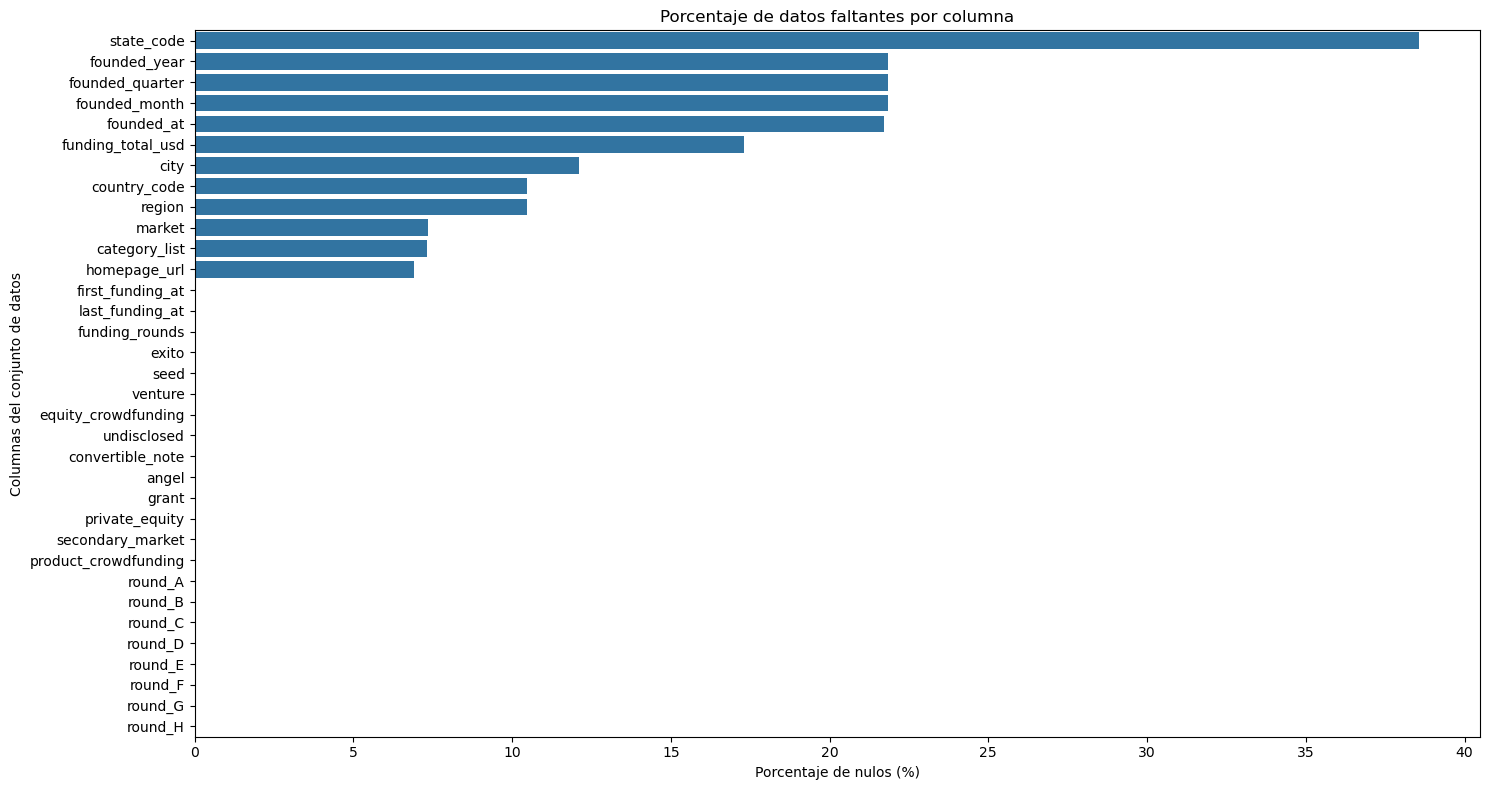

In [12]:
# 1. Calcular el número de valores nulos por columna
valores_nulos = df.isnull().sum()

# 2. Calcular el porcentaje de valores nulos por columna
porcentaje_nulos = (valores_nulos / len(df)) * 100

# 3. Crear un DataFrame resumen con los datos faltantes
datos_faltantes = pd.DataFrame({
    'Columna': df.columns,
    'Valores nulos': valores_nulos,
    'Porcentaje de nulos (%)': porcentaje_nulos
}).sort_values(by='Porcentaje de nulos (%)', ascending=False)

# 4. Mostrar la tabla
print(datos_faltantes)

# 5. Visualización con Seaborn
plt.figure(figsize=(15, 8))
sns.barplot(x='Porcentaje de nulos (%)', y='Columna', data=datos_faltantes)
plt.title('Porcentaje de datos faltantes por columna')
plt.xlabel('Porcentaje de nulos (%)')
plt.ylabel('Columnas del conjunto de datos')
plt.tight_layout()
plt.show()

Se puede ver que la variable con mayor número de datos faltantes está en `state_code`, lo que nos sugiere que muchos ejemplos no tienen dicha información, seguramente porque no son de Estados Unidos o son incompletos. `funding_total_usd` y `city` también tienen un significativo número de valores faltantes, lo que afecta al análisis dependiente de la geografía y información financiera.

Por otro lado, `country_code` y `region` tienen una falta moderada de datos, lo que podría dificultar la segmentación geográfica o el análisis de mercado.

Las variables `market` y `category_list` también tienen valores perdidos lo que podría afectar a los análisis que se hagan relacionados con los tipos de industria.

Finalmente, hay variables en las que casi no hay valores perdidos como `Round_A`, `Round_B`, `seed`.

### Interpretación

### Brechas en los Datos Geográficos  
La ausencia significativa de valores en las columnas ``state_code``, ``city``, ``country_code`` y ``region`` implica dificultades para realizar un análisis geográfico detallado. Esto puede deberse a que el conjunto de datos incluye empresas a nivel global, donde dicha información no siempre está disponible de forma uniforme. Sin embargo, esto **no representará un problema en nuestro análisis**, ya que más adelante, en la Parte 3, construiremos características geográficas basadas en conjuntos de datos adicionales.

### Brechas en Mercado y Categoría  
La falta de datos en las columnas ``market`` y ``category_list`` puede dificultar los estudios específicos por sector o industria, ya que se limita la comprensión del segmento en el que operan las empresas. **Tampoco supondrá un problema para nuestro análisis**, ya que posteriormente construiremos una característica basada en un mapeo industrial a partir de los datos de ``market`` y no utilizaremos la columna ``category_list``, ya que en el contexto del capital riesgo, solo la industria tiene un impacto significativo.

### Brechas en Financiación  
Una de las columnas con mayor cantidad de datos faltantes es ``funding_total_usd``. Esto probablemente se deba a que muchas startups no han recibido financiación, lo cual es bastante habitual, considerando que el capital riesgo es una industria altamente selectiva, y solo un pequeño porcentaje de startups consigue financiación.

Como se explicó anteriormente, una variable clave para el análisis es la columna ``status``, que es esencial para construir la variable objetivo. Las filas con valores vacíos en ``status`` son inutilizables y deben eliminarse. En cambio, para otras columnas, especialmente aquellas relacionadas con rondas de financiación (como ``pre_seed``, ``seed``, ``round_A``), **se deben rellenar con ceros** en lugar de eliminarlas. Esto se debe a que un valor vacío en una columna de financiación no implica necesariamente que se deba descartar la fila: las rondas de financiación siguen una secuencia cronológica, y una startup puede haber levantado solo una ronda ``pre_seed`` sin avanzar a rondas posteriores.


Podemos observar que las empresas de nuestros datos se fundaron entre 1902 y 2014

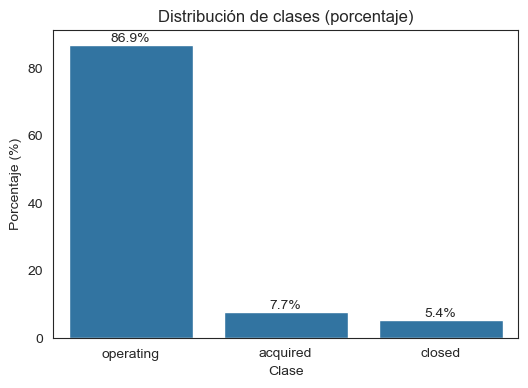

In [13]:
sns.set_style('white')
target = 'exito'


porcentajes = df[target].value_counts(normalize=True) * 100


plt.figure(figsize=(6,4))
ax = sns.barplot(x=porcentajes.index, y=porcentajes.values)
for i, v in enumerate(porcentajes.values):
    ax.text(i, v+1, f"{v:.1f}%", ha='center')
ax.set_title("Distribución de clases (porcentaje)")
ax.set_xlabel("Clase")
ax.set_ylabel("Porcentaje (%)")

plt.show()


In [14]:
df.head()

,homepage_url,category_list,market,funding_total_usd,exito,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,angel,grant,private_equity,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,1.0,2012-06-01,2012-06-01,2012-Q2,2012-01-01,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,http://enjoyandtv.com,|Games|,Games,4000000.0,operating,USA,CA,Los Angeles,Los Angeles,2.0,NaT,NaT,NaN,NaT,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,2012-10-01,2012-Q4,2012-01-01,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,NaN,London,London,1.0,2011-04-01,2011-04-01,2011-Q2,2011-01-01,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,2014-01-01,2014-Q1,2014-01-01,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

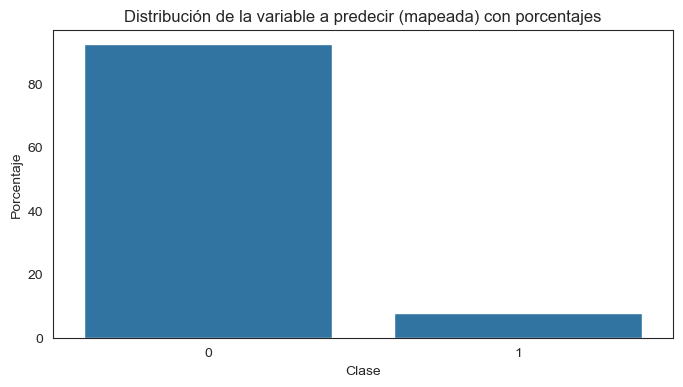

In [15]:
# target = 'exito'
# mapping = {'operating': 0, 'closed': 0, 'acquired': 1}
# df[target] = df[target].map(mapping)

# Calcular los porcentajes de cada clase en la variable 'exito'
# percentages = df[target].value_counts(normalize=True) * 100
mapping = {
    'acquired':  1,
    'closed':    0,
    'operating': 0,
    'ipo':       0
}
df['exito'] = df['exito'].map(mapping) \
                       .fillna(0) \
                       .astype(int)

# 2) Calcular porcentajes
percentages = df['exito'].value_counts(normalize=True) * 100 
# Crear el gráfico de barras con porcentajes
plt.figure(figsize=(8, 4))
sns.barplot(x=percentages.index, y=percentages.values)

# Configuración del gráfico
plt.title('Distribución de la variable a predecir (mapeada) con porcentajes')
plt.xlabel('Clase')
plt.ylabel('Porcentaje')

plt.show

In [16]:
# Función para agrupar por rangos
def year_group(row):
    year = row['founded_year'].year if pd.notnull(row['founded_year']) else None
    if year is None:
        return ''
    if 1900 <= year <= 1925:
        return 'less_than_1925'
    elif 1925 < year <= 1950:
        return '1925_1950'
    elif 1950 < year <= 1975:
        return '1950_1975'
    elif 1975 < year <= 2000:
        return '1975_2000'
    elif year > 2000:
        return '2000_2014'
    else:
        return ''

# Aplicar la función
df['founded_year_group'] = df.apply(year_group, axis=1)

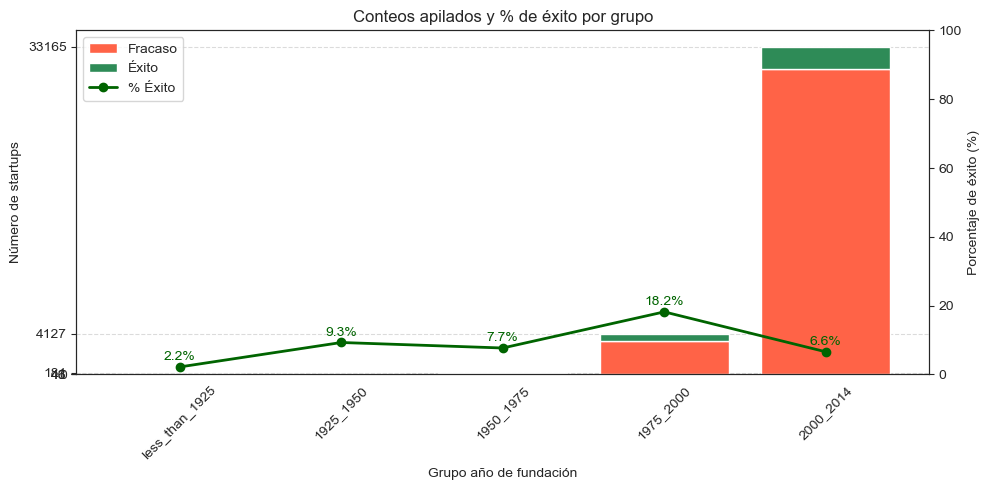

In [17]:
# 1) Preparar los datos
grouped = df.groupby('founded_year_group')['exito'].value_counts().unstack(fill_value=0)

ordered_groups = [
    'less_than_1925',
    '1925_1950',
    '1950_1975',
    '1975_2000',
    '2000_2014'
]

fails  = grouped.loc[ordered_groups, 0]
succs  = grouped.loc[ordered_groups, 1]
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)

# 2) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(10,5))

bar1 = ax1.bar(ordered_groups, fails,  label='Fracaso', color='tomato')
bar2 = ax1.bar(ordered_groups, succs, bottom=fails, label='Éxito',   color='seagreen')

# 3) Fijar los ticks del eje Y a los totales (y al 0)
yticks = np.concatenate([[0], totals.values])
ax1.set_yticks(sorted(yticks))
ax1.set_ylabel("Número de startups")
ax1.set_xlabel("Grupo año de fundación")
ax1.set_title("Conteos apilados y % de éxito por grupo")
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 4) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(ordered_groups, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# 5) Anotar % de éxito encima de cada punto
for x, pct in zip(ordered_groups, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 6) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()


Se puede observar que casi todas las empresas se fundan entre el año `2000` y `2014`. Por ello, ahora ploteamos la gráfica de solo los años `2000` a `2014`.

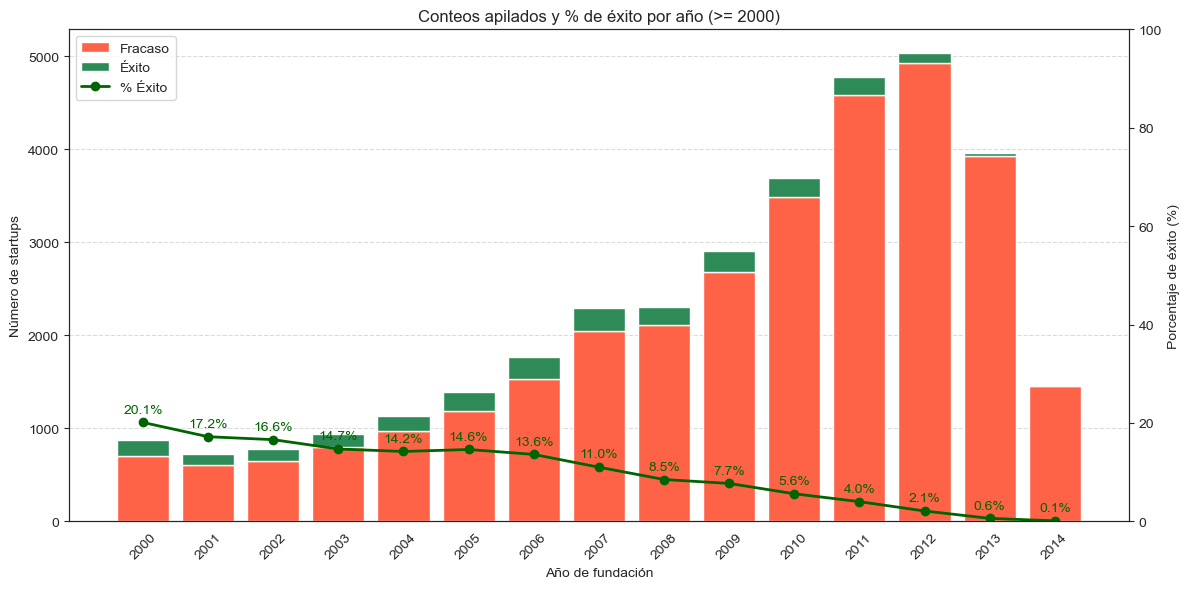

In [18]:
# 1) Filtrar los datos para años de fundación >= 2000
# Asegúrate de que la columna está en formato datetime
df['founded_year'] = pd.to_datetime(df['founded_year'], errors='coerce')

# Filtrar usando el año extraído
df_new = df[df['founded_year'].dt.year >= 2000].copy()

# Convertir 'founded_year' a solo el año como entero para graficar
df_new['founded_year'] = df_new['founded_year'].dt.year


# 2) Preparar los datos agrupados por año de fundación
grouped = df_new.groupby('founded_year')['exito'].value_counts().unstack(fill_value=0)

fails = grouped.get(0, pd.Series(dtype=int))
succs = grouped.get(1, pd.Series(dtype=int))
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)
years = grouped.index.tolist()

# 3) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(12, 6))

bar1 = ax1.bar(years, fails, label='Fracaso', color='tomato')
bar2 = ax1.bar(years, succs, bottom=fails, label='Éxito', color='seagreen')

# 4) Fijar las etiquetas del eje X a todos los años
ax1.set_xticks(years)
ax1.set_ylabel("Número de startups")
ax1.set_xlabel("Año de fundación")
ax1.set_title("Conteos apilados y % de éxito por año (>= 2000)")
ax1.tick_params(axis='x', rotation=45)

# El eje Y ahora usará los ticks predeterminados de Matplotlib
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 5) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(years, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# 6) Anotar % de éxito encima de cada punto
for x, pct in zip(years, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 7) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

Sin embargo, el intervalo de tiempo en el que las empresas tienen mayor éxito (en proporción) es entre `1975` y el año `2000`, por lo que mostramos también su gráfica.

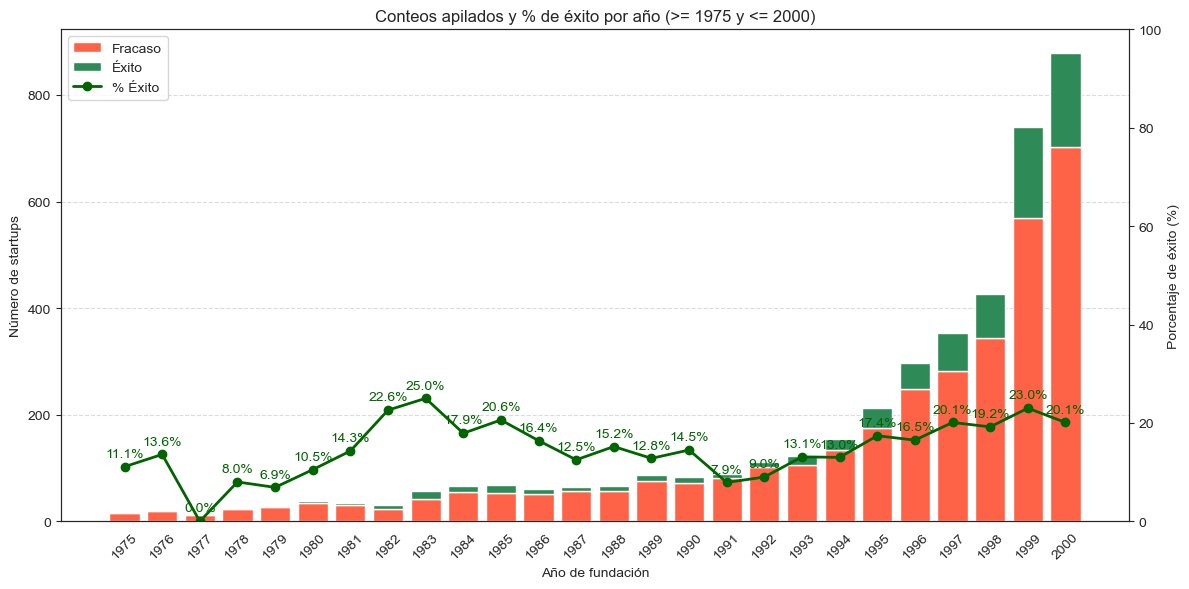

In [19]:
# 1) Filtrar los datos para años de fundación >= 2000
# Asegúrate de que 'founded_year' está en formato datetime
df['founded_year'] = pd.to_datetime(df['founded_year'], errors='coerce')

# Extrae el año como entero y filtra
df_new = df[
    (df['founded_year'].dt.year >= 1975) &
    (df['founded_year'].dt.year <= 2000)
].copy()

# Crea la nueva columna como enteros para graficar
df_new['founded_year'] = df_new['founded_year'].dt.year

# 2) Preparar los datos agrupados por año de fundación
grouped = df_new.groupby('founded_year')['exito'].value_counts().unstack(fill_value=0)

fails = grouped.get(0, pd.Series(dtype=int))
succs = grouped.get(1, pd.Series(dtype=int))
totals = fails + succs
pct_succs = (succs / totals * 100).round(1)
years = grouped.index.tolist()

# 3) Dibujar las barras apiladas
fig, ax1 = plt.subplots(figsize=(12, 6))

bar1 = ax1.bar(years, fails, label='Fracaso', color='tomato')
bar2 = ax1.bar(years, succs, bottom=fails, label='Éxito', color='seagreen')

# 4) Fijar las etiquetas del eje X a todos los años
ax1.set_xticks(years)
ax1.set_ylabel("Número de startups")
ax1.set_xlabel("Año de fundación")
ax1.set_title("Conteos apilados y % de éxito por año (>= 1975 y <= 2000)")
ax1.tick_params(axis='x', rotation=45)

# El eje Y ahora usará los ticks predeterminados de Matplotlib
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 5) Eje secundario de porcentaje
ax2 = ax1.twinx()
ax2.plot(years, pct_succs, color='darkgreen', marker='o', linewidth=2, label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

# 6) Anotar % de éxito encima de cada punto
for x, pct in zip(years, pct_succs):
    ax2.text(x, pct + 2, f"{pct}%", ha='center', color='darkgreen')

# 7) Leyenda combinada
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

### Análisis de la intensidad de financiación

En este bloque de código vamos a explorar cómo el monto total de financiación recibido por cada startup se relaciona con su probabilidad de éxito:

1. **Discretización en intervalos**  
   - Definimos una serie de rangos (bins) que agrupan las startups según franjas de inversión (por ejemplo, `<100K`, `100K–1M`, etc.).

2. **Cálculo de éxitos y fracasos**  
   - Agrupamos el número de startups adquiridas (`exito = 1`) y no adquiridas (`exito = 0`) en cada intervalo.

3. **Visualización**  
   - Generamos un gráfico de barras **apiladas** para mostrar el conteo de éxitos y fracasos por intervalo.  
   - Sobre el mismo eje, trazamos una **línea** que indica el porcentaje de éxito dentro de cada rango de financiación.

Este análisis nos ayuda a identificar de manera intuitiva si existe algún umbral de inversión por encima del cual las startups muestran una mayor probabilidad de ser adquiridas.


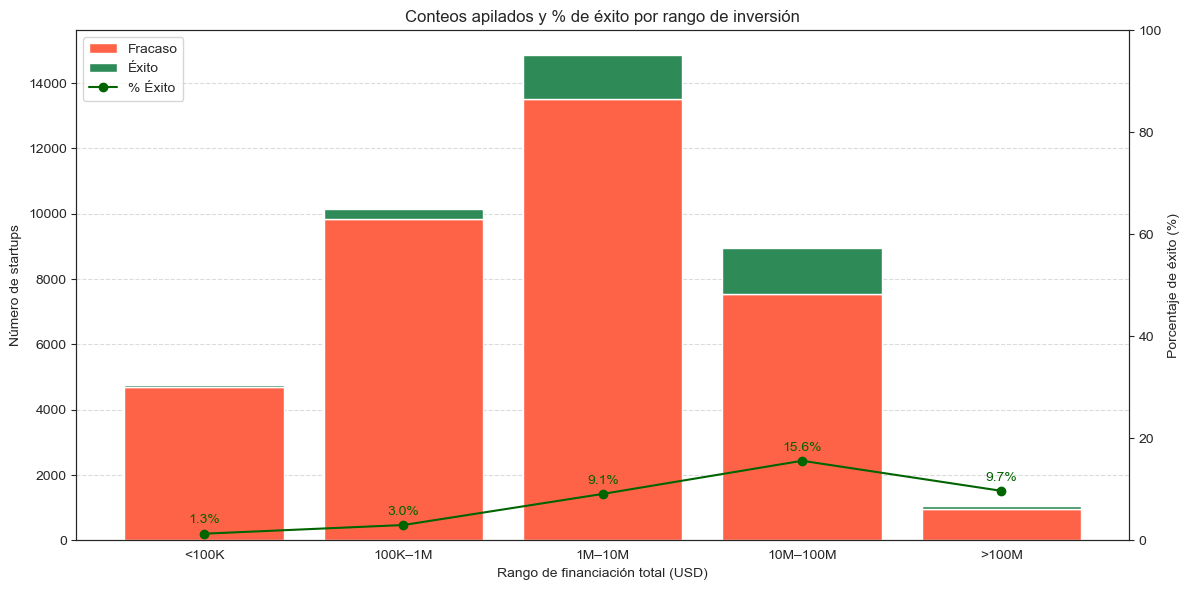

In [20]:
df_plot = df.copy()

# 1) LIMPIEZA Y CONVERSIÓN de funding_total_usd en la copia
df_plot['funding_total_usd'] = (
    df_plot['funding_total_usd']
      .astype(str)
      .str.replace(',', '', regex=False)
)
df_plot['funding_total_usd'] = pd.to_numeric(df_plot['funding_total_usd'], errors='coerce')
df_plot = df_plot.dropna(subset=['funding_total_usd']).copy()

# 2) DEFINIR BINS Y ETIQUETAS en la copia
bins   = [0, 1e5, 1e6, 1e7, 1e8, df_plot['funding_total_usd'].max()]
labels = ['<100K', '100K–1M', '1M–10M', '10M–100M', '>100M']
df_plot['fnd_bin'] = pd.cut(
    df_plot['funding_total_usd'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 3) AGRUPAR ÉXITOS/FRACASOS en la copia
grouped = (
    df_plot
    .groupby('fnd_bin')['exito']
    .value_counts()
    .unstack(fill_value=0)
    .reindex(labels, fill_value=0)
)
fails  = grouped[0]
succs  = grouped[1]
totals = fails + succs
pct    = (succs / totals * 100).round(1).fillna(0)

# 4) PLOT Apilado + Línea de % usando la copia
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(labels, fails,  color='tomato',    label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='Éxito')
ax1.set_xlabel("Rango de financiación total (USD)")
ax1.set_ylabel("Número de startups")
ax1.set_title("Conteos apilados y % de éxito por rango de inversión")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(labels, pct, color='darkgreen', marker='o', label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

for x, p in zip(labels, pct):
    ax2.text(x, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

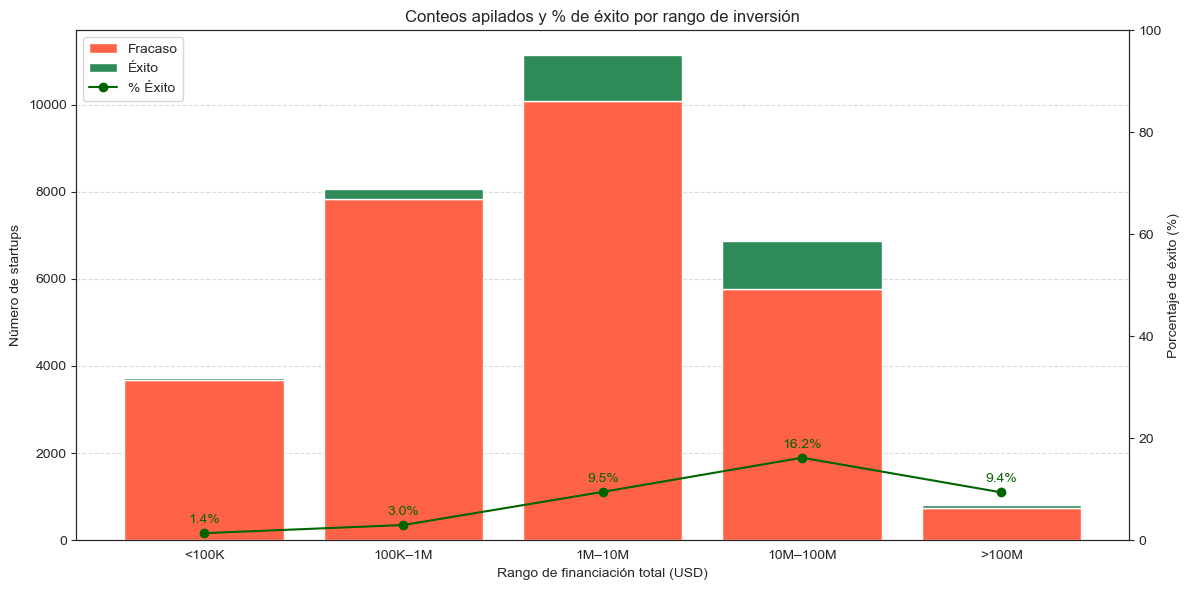

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Partimos del df original, sin tocarlo:
df_plot = df.copy()

# 1) Convertir a datetime y filtrar años >= 1990
df_plot['founded_year'] = pd.to_datetime(df_plot['founded_year'], errors='coerce')
df_plot['founded_year_int'] = df_plot['founded_year'].dt.year
df_plot = df_plot[df_plot['founded_year_int'] >= 1990].copy()

# 2) Asegurarnos de no tener NaN en funding_total_usd
df_plot['funding_total_usd'] = (
    df_plot['funding_total_usd']
      .astype(str)
      .str.replace(',', '', regex=False)
)
df_plot['funding_total_usd'] = pd.to_numeric(df_plot['funding_total_usd'], errors='coerce')
df_plot = df_plot.dropna(subset=['funding_total_usd'])

# 3) Definir bins y etiquetas
bins   = [0, 1e5, 1e6, 1e7, 1e8, df_plot['funding_total_usd'].max()]
labels = ['<100K', '100K–1M', '1M–10M', '10M–100M', '>100M']
df_plot['fnd_bin'] = pd.cut(
    df_plot['funding_total_usd'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# 4) Agrupar éxitos/fracasos (exito == 1 / exito == 0)
grouped = (
    df_plot
      .groupby('fnd_bin')['exito']
      .value_counts()
      .unstack(fill_value=0)
      .reindex(labels, fill_value=0)
)
fails = grouped[0]
succs = grouped[1]
totals= fails + succs
pct   = (succs / totals * 100).round(1).fillna(0)

# 5) Plot apilado + línea de porcentaje
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(labels, fails,  color='tomato',    label='Fracaso')
ax1.bar(labels, succs, bottom=fails, color='seagreen', label='Éxito')
ax1.set_xlabel("Rango de financiación total (USD)")
ax1.set_ylabel("Número de startups")
ax1.set_title("Conteos apilados y % de éxito por rango de inversión")
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.plot(labels, pct, color='darkgreen', marker='o', label='% Éxito')
ax2.set_ylabel("Porcentaje de éxito (%)")
ax2.set_ylim(0, 100)

for x, p in zip(labels, pct):
    ax2.text(x, p + 2, f"{p:.1f}%", ha='center', color='darkgreen')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper left')

plt.tight_layout()
plt.show()

### Impacto del número de rondas de financiación

Este gráfico muestra cómo el número de rondas de financiación influye en la probabilidad de adquisición:

1. **Conteos apilados**  
   - Barras rojas (`Fracaso`): startups no adquiridas.  
   - Barras verdes (`Éxito`): startups adquiridas.  

2. **Porcentaje de éxito**  
   - Línea y marcadores en verde oscuro indican el porcentaje de startups adquiridas por cada número de rondas.  

Con este análisis podemos ver si más rondas de financiación se traducen en una mayor tasa de adquisiciones.  


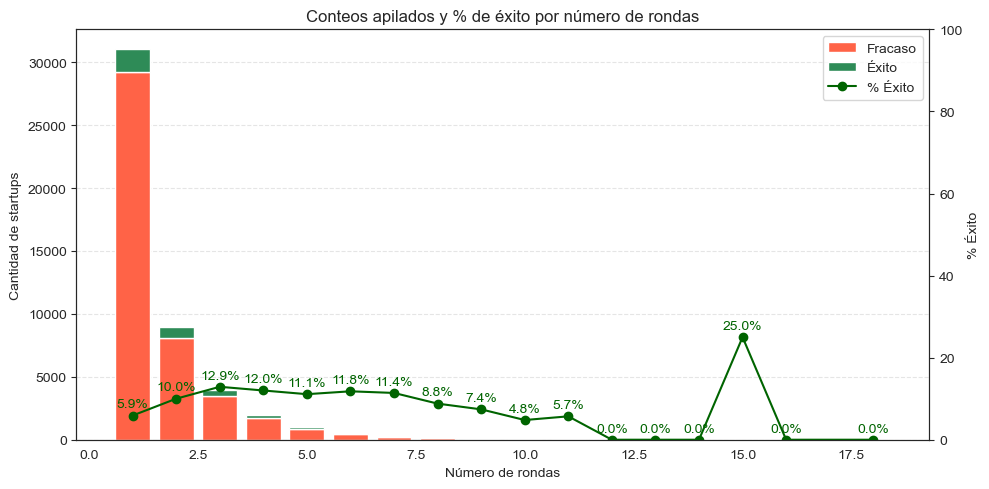

In [22]:
# 1) Agrupamos por número de rondas y exito
grp2 = (
    df.groupby('funding_rounds')['exito']
      .value_counts()
      .unstack(fill_value=0)
      .sort_index()
)
fails2 = grp2.get(0, pd.Series(dtype=int))
succs2 = grp2.get(1, pd.Series(dtype=int))
rnds   = fails2.index
tot2   = fails2 + succs2
pct2   = (succs2 / tot2 * 100).round(1)

# 2) Plot
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(rnds, fails2,  color='tomato',    label='Fracaso')
ax1.bar(rnds, succs2, bottom=fails2, color='seagreen', label='Éxito')
ax1.set_xlabel("Número de rondas")
ax1.set_ylabel("Cantidad de startups")
ax1.set_title("Conteos apilados y % de éxito por número de rondas")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(rnds, pct2, color='darkgreen', marker='o', label='% Éxito')
ax2.set_ylabel("% Éxito")
ax2.set_ylim(0,100)

for x, p in zip(rnds, pct2):
    ax2.text(x, p+2, f"{p}%", ha='center', color='darkgreen')

h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper right')

plt.tight_layout()
plt.show()


### Combinación Sector–País (Top 5×Top 5)

Este gráfico muestra cómo se distribuyen las startups en los 5 sectores más frecuentes y los 5 países principales:

1. **Barras apiladas**  
   - Cada barra representa un sector.  
   - Los segmentos apilados (colores) corresponden al número de startups en cada país.  

2. **Línea de porcentaje de éxito**  
   - Línea negra con marcadores muestra el porcentaje medio de adquisiciones por sector, considerando todos los países.  

Este análisis permite ver, de un vistazo, en qué combinaciones sector–país se concentra el mayor volumen de startups y cuáles tienen la mayor tasa de éxito.  


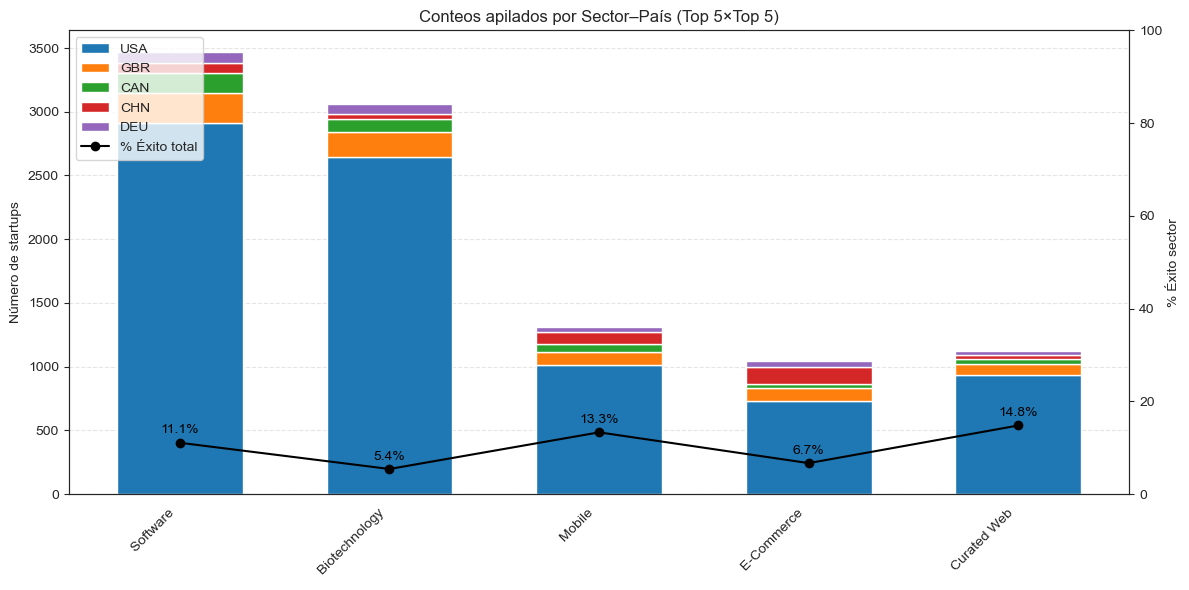

In [23]:
# 1) Filtramos top 5 de cada uno
top_secures   = df['market'].value_counts().head(5).index
top_countries = df['country_code'].value_counts().head(5).index
sub = df[df['market'].isin(top_secures) & df['country_code'].isin(top_countries)]

# 2) Pivot counts y % éxito
pivot_cnt = sub.pivot_table(
    index='market', columns='country_code', values='exito',
    aggfunc=['count','mean']
)
cnts = pivot_cnt['count']
pcts = (pivot_cnt['mean'] * 100).round(1)

# 3) Para cada sector dibujamos barras apiladas por país y % línea
fig, ax1 = plt.subplots(figsize=(12,6))
width = 0.6
x = np.arange(len(top_secures))

# apilado
bottom = np.zeros(len(top_secures))
for c in top_countries:
    vals = cnts[c].reindex(top_secures).fillna(0)
    ax1.bar(x, vals, width, bottom=bottom, label=c)
    bottom += vals

ax1.set_xticks(x)
ax1.set_xticklabels(top_secures, rotation=45, ha='right')
ax1.set_ylabel("Número de startups")
ax1.set_title("Conteos apilados por Sector–País (Top 5×Top 5)")
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# línea de % éxito promedio por sector (sobre todos los países)
avg_pct = sub.groupby('market')['exito'].mean().reindex(top_secures) * 100
ax2 = ax1.twinx()
ax2.plot(x, avg_pct, color='black', marker='o', label='% Éxito total')
ax2.set_ylabel("% Éxito sector")
ax2.set_ylim(0,100)

for xi, p in zip(x, avg_pct):
    ax2.text(xi, p+2, f"{p:.1f}%", ha='center', color='black')

# leyenda combinada
h1,l1 = ax1.get_legend_handles_labels()
h2,l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left')

plt.tight_layout()
plt.show()


### Top 25 Categorías de Mercado y Éxito

Este gráfico muestra las **25 categorías más frecuentes** de startups y su **porcentaje de éxito** (startups adquiridas):

1. **Barras**: representan el porcentaje de startups por categoría.  
2. **Color secundario**: indica el porcentaje de éxito en cada una.

Permite comparar la popularidad de cada categoría con su tasa de adquisición.

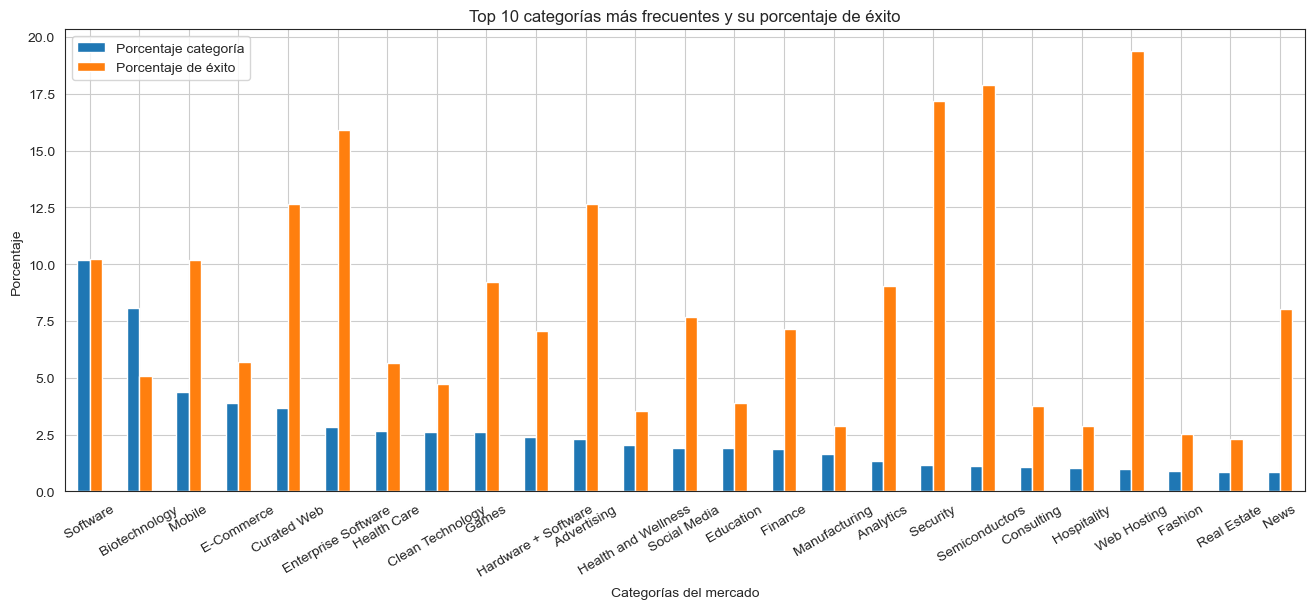

In [24]:
market_counts = df['market'].value_counts(normalize=True) * 100

# Calcular el porcentaje de 'exito = 1' para cada categoría en 'market'
success_percentage = df.groupby('market')['exito'].mean() * 100

# Crear un DataFrame con los porcentajes de las categorías y el porcentaje de éxito
result_df = pd.DataFrame({
    'Porcentaje categoría': market_counts,
    'Porcentaje de éxito': success_percentage
})

# Seleccionar las 10 categorías más frecuentes
top_categories = market_counts.head(25)

# Filtrar el DataFrame resultante para mostrar solo las categorías más frecuentes
result_df_top = result_df.loc[top_categories.index]

# Graficar
result_df_top.plot(kind='bar', figsize=(16, 6))

plt.title('Top 10 categorías más frecuentes y su porcentaje de éxito')
plt.xlabel('Categorías del mercado')
plt.ylabel('Porcentaje')
plt.xticks(rotation=30)
plt.grid()
plt.show()

Se puede observar que el número de startups **aumenta** cada año.

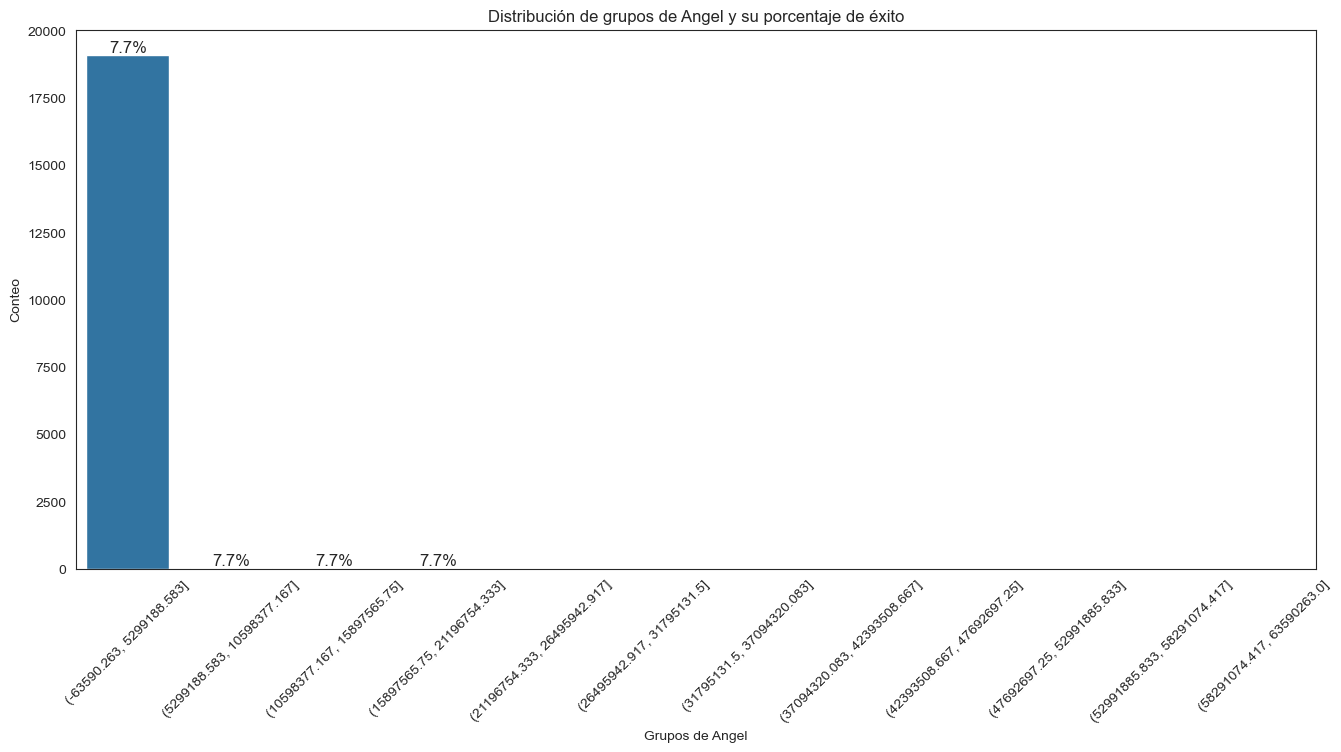

In [25]:
# Dividir la variable 'angel' en 12 grupos utilizando pd.cut
df['angel_group'] = pd.cut(df['angel'], bins=12)

# Calcular el porcentaje de 'exito = 1' para cada grupo en 'angel_group'
success_percentage_angel_group = df.groupby('angel_group')['exito'].mean() * 100

# Graficar la distribución de 'angel_group'
plt.figure(figsize=(16, 7))

# Gráfico de barras con el conteo de cada grupo en 'angel_group'
sns.countplot(x='angel_group', data=df.dropna())

# Añadir los porcentajes de éxito encima de las barras
for p in plt.gca().patches:
    height = p.get_height()
    # Obtener el grupo de 'angel_group' correspondiente
    group_label = p.get_x() + p.get_width() / 2
    group_label = df['angel_group'].iloc[int(group_label)]  # Identificar la categoría por índice
    
    # Añadir el texto con el porcentaje de éxito en el gráfico
    plt.text(p.get_x() + p.get_width() / 2, height + 1, f'{success_percentage_angel_group[group_label]:.1f}%', 
             ha='center', va='bottom', fontsize=12)

plt.title('Distribución de grupos de Angel y su porcentaje de éxito')
plt.xlabel('Grupos de Angel')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.show()


Podemos observar que casi todas las startups son de `Software` y `Biotechnology`, seguidas de `Mobile`,`E-Commerce` y `Curated Webs`.

Realizamos un análisis de la variable a predecir en este caso, exito.

De momento vamos a asignar, la clase 1 a acquired y 0 a closed. Pero podríamos realizar otra distribución de clases si fuera de interés para el trabajo

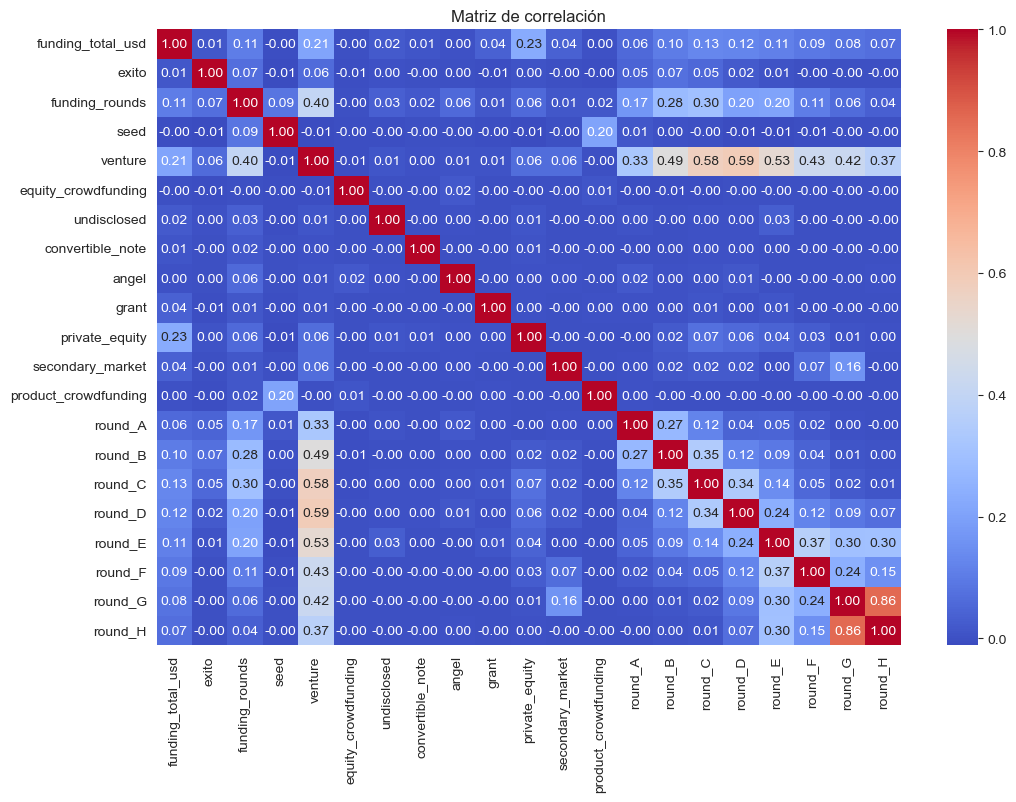

In [26]:
# Creamos una matriz de correlación entre las variables numéricas
numerical_df = df.select_dtypes(include=['number']) 
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

Text(0.5, 1.0, 'Relación entre funding_rounds, founded_year y exito')

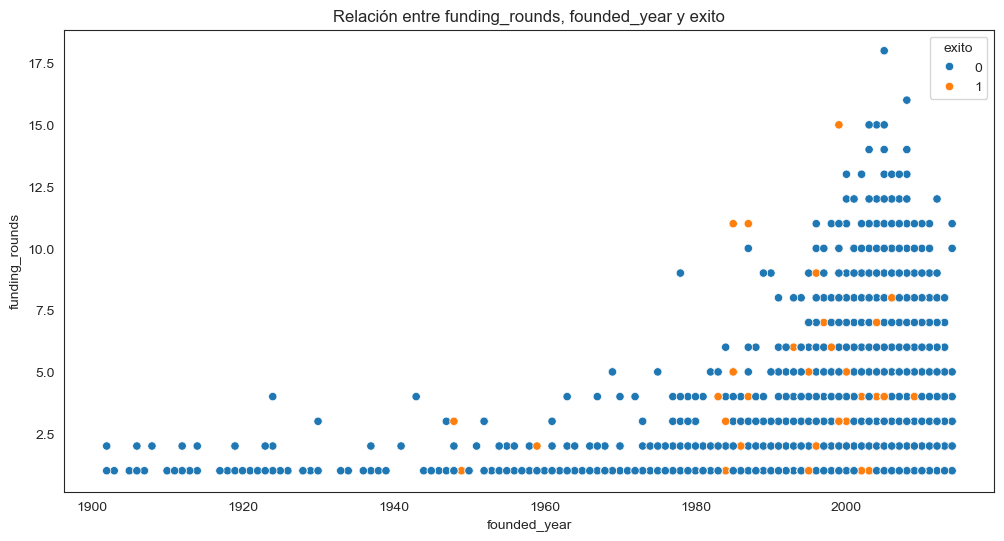

In [27]:
# Observamos que variables que están más correlacionadas con la variable de salida son funding_round y founded_year
# Observamos relacion entre funding_round, founded_year y variable objetivo 
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='founded_year', y='funding_rounds', hue='exito')
plt.title('Relación entre funding_rounds, founded_year y exito')

Más rondas de financiación aumentan la probabilidad de salida: Las startups con más rondas de financiación (4 o más) tienen mayor probabilidad de ser "adquiridas" o "cerradas" en comparación con aquellas con menos rondas (1-3), que suelen estar "operando". Esto sugiere que una financiación sostenida aumenta las posibilidades de un evento de salida.

<Figure size 1000x600 with 0 Axes>

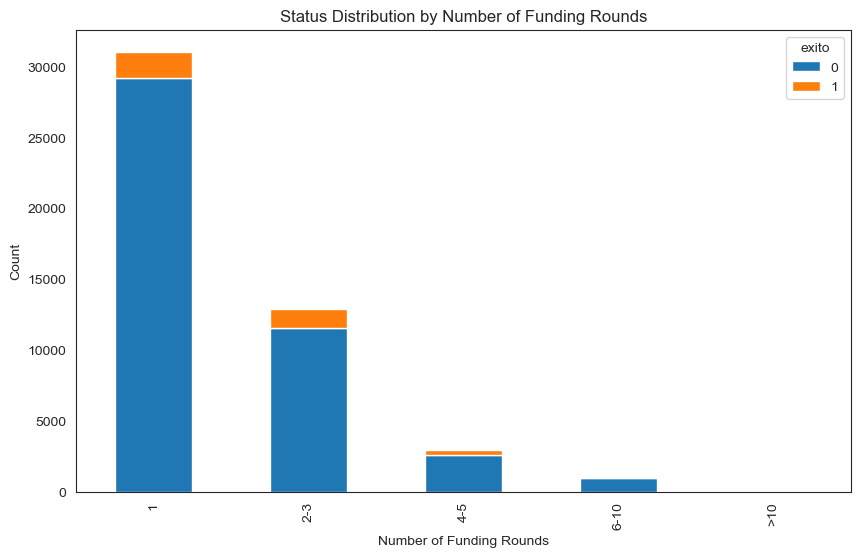

In [28]:
# Relationship 1: More Funding Rounds Increase Exit Likelihood
plt.figure(figsize=(10, 6))
df['funding_rounds_bin'] = pd.cut(df['funding_rounds'], bins=[0, 1, 3, 5, 10, float('inf')],
                                 labels=['1', '2-3', '4-5', '6-10', '>10'])
status_rounds = df.groupby(['funding_rounds_bin', 'exito']).size().unstack().fillna(0)
status_rounds.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Status Distribution by Number of Funding Rounds')
plt.xlabel('Number of Funding Rounds')
plt.ylabel('Count')
plt.legend(title='exito')
plt.show()


Mayores cantidades de financiación se correlacionan con adquisiciones: Las startups adquiridas tienen una mediana de financiación más alta ($10M) en comparación con las cerradas y las que están operando ($1M), lo que indica que más financiación aumenta la probabilidad de adquisición, mientras que menos financiación puede llevar al cierre.

<Figure size 1000x600 with 0 Axes>

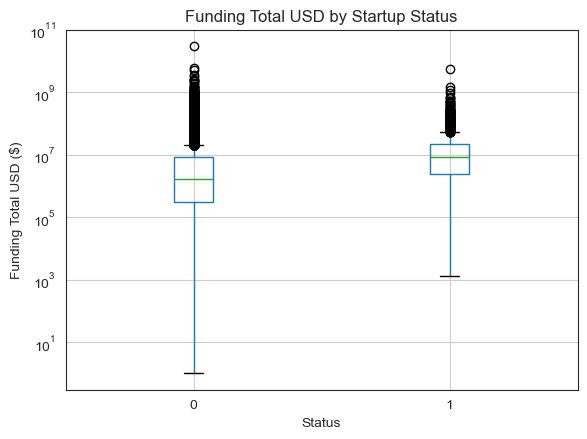

In [29]:
# Relationship 2: Higher Funding Amounts Correlate with Acquisitions
plt.figure(figsize=(10, 6))
df.boxplot(column='funding_total_usd', by='exito', showfliers=True)
plt.title('Funding Total USD by Startup Status')
plt.suptitle('')
plt.xlabel('Status')
plt.ylabel('Funding Total USD ($)')
plt.yscale('log')
plt.show()


La edad de la startup afecta su estado: Las startups más nuevas (post-2010) están mayormente "operando", mientras que las más antiguas (pre-2005) tienen más estados "adquiridas" y "cerradas". El período 2005-2010 muestra una mezcla equilibrada, sugiriendo que 5-15 años tras la fundación es un período crítico para salidas.


# ¿La edad de la Startup afecta a la variable objetivo?


Tendencias de financiación a lo largo del tiempo: La financiación total alcanzó su pico alrededor de 2010-2015, reflejando un auge en la inversión en startups, mientras que el número promedio de rondas de financiación por startup se mantiene estable (1-2.5). 

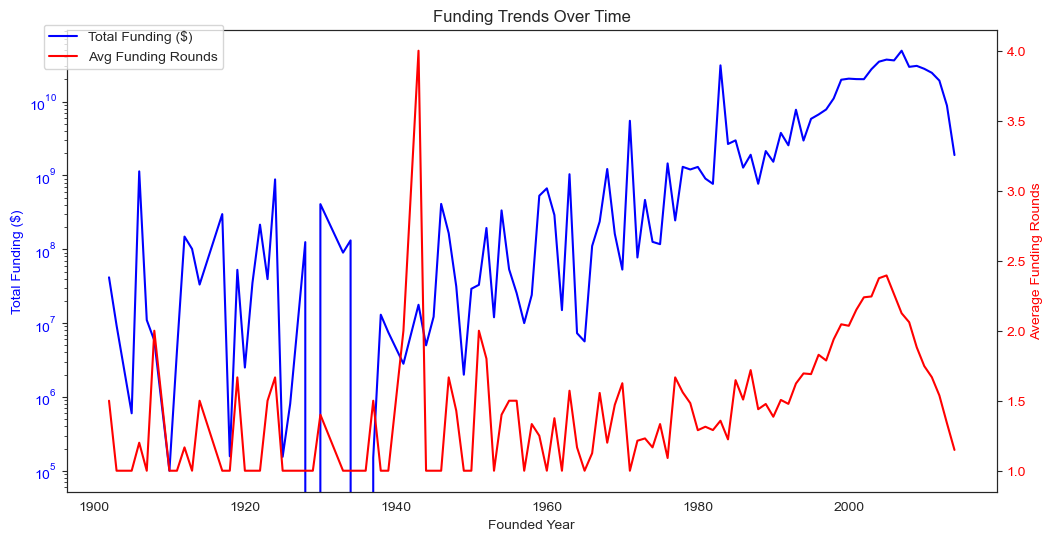

In [30]:

# Relationship 5: Funding Trends Over Time
df_yearly = df.groupby('founded_year').agg({
    'funding_total_usd': 'sum',
    'funding_rounds': 'mean'
}).reset_index()
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df_yearly['founded_year'], df_yearly['funding_total_usd'], 'b-', label='Total Funding ($)')
ax1.set_xlabel('Founded Year')
ax1.set_ylabel('Total Funding ($)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.plot(df_yearly['founded_year'], df_yearly['funding_rounds'], 'r-', label='Avg Funding Rounds')
ax2.set_ylabel('Average Funding Rounds', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title('Funding Trends Over Time')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()


## 4. Preparación de los datos para clasificación simple
Para poder realizar predicciones al principio, tenemos que lidiar con valores nulos primero realizaremos un analisis sencillo y los ignoraremos o sustituiremos, posteriormente usaremos tecnicas de imputacion y similares para intentar no perder informacion relevante.

Posteriormente aplicaremos una pipeline sencilla con knn para una primera clasificacion simple del problema

In [31]:
print("Valores únicos en df['exito'] antes del mapeo:")
print(df['exito'].unique())
# Asegúrate de partir del DataFrame correcto

X = df.drop(columns=['exito'])
y = df['exito']

# Separar columnas (ya tienes X definido)
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5))
    ]), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Pipeline completa con Random Forest
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight='balanced',
        random_state=42
    ))
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
#resultados = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline, beta=0.7)


Valores únicos en df['exito'] antes del mapeo:
[1 0]


In [32]:
# === 1. Separar variables
X = df.drop(columns=['exito'])
y = df['exito']

numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# === 3. Pipeline de preprocesamiento + modelo
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', KNNImputer(n_neighbors=5))
    ]), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# === 4. Dividir el conjunto (hold-out 70/30)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# === 5. Ejecutar evaluación
resultados = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)


==== Evaluación del modelo ====
F0.7-score: 0.1064
AUC-PR:      0.1477


### Limpiar data

Primero eliminamos las variables que sean creado para poder visualizar las gráficas.

In [33]:
# Lista de las columnas de EDA que quieres eliminar
cols_to_drop = [
    'founded_year_group',
    'angel_group',
    'funding_rounds_bin'
]

# Opción A: borrarlas directamente del df original
df.drop(columns=cols_to_drop, inplace=True)

df['founded_year'] =  pd.to_datetime(df['founded_year'], format='%Y', errors = 'coerce') # conveting column into date and ignoring errors

## 5. Imputación de valores perdidos

In [34]:
# División inicial: 60% entrenamiento, 40% restante
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# División secundaria: 50% validación, 50% prueba del 40% restante
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Tamaños de los conjuntos: \nEntrenamiento: {X_train.shape}, Validación: {X_val.shape}, Prueba: {X_test.shape}")

Tamaños de los conjuntos: 
Entrenamiento: (28837, 36), Validación: (9612, 36), Prueba: (9613, 36)


### Imputación de ``founded_year`` usando KNNImputer

#### Elección de la imputación frente a la eliminación de valores

En nuestro conjunto de datos, la columna ``founded_year`` contiene más de 10.000 registros faltantes. Eliminar una cantidad tan significativa de filas podría suponer una gran pérdida de información y sesgar potencialmente el análisis. Imputar estos valores, especialmente al tratarse de años, es una decisión razonable ya que preserva la integridad y el tamaño del dataset.

#### ¿Por qué usar KNNImputer?

Utilizamos ``KNNImputer`` porque permite estimar los años faltantes considerando la similitud entre las observaciones. Este método parte de la suposición de que las empresas fundadas en años cercanos pueden compartir características similares en otras variables, lo que convierte a KNN en una opción práctica para completar los valores ausentes de ``founded_year``.

#### Preparación de los datos e imputación

Antes de realizar la imputación, la columna ``founded_year`` debe convertirse de tipo fecha a formato entero para cumplir con los requisitos de ``KNNImputer``. Luego, aplicamos la imputación utilizando los vecinos más cercanos, asegurando que nuestros datos sigan siendo consistentes y útiles para el análisis posterior.

In [35]:
print("Distribución completa:", df['exito'].value_counts())

Distribución completa: exito
0    44371
1     3691
Name: count, dtype: int64


In [36]:
# ========================
# 1. Dataset SIN imputación
# ========================
df_base = df.copy()

X_base = df_base.drop(columns='exito')
y_base = df_base['exito']

num_cols = ['founded_year']
cat_cols = []  # puedes añadir categóricas si usas alguna

preprocessor_base = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline_base = ImbPipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

In [37]:
# ========================
# 2. Dataset CON imputación KNN
# ========================
df_knn = df.copy()

# Convertir a datetime si no lo es
if not pd.api.types.is_datetime64_any_dtype(df_knn['founded_year']):
    df_knn['founded_year'] = pd.to_datetime(df_knn['founded_year'], errors='coerce', format='%Y')

print("After conversion, null values:", df_knn['founded_year'].isnull().sum())

# Extraer año
df_knn['founded_year'] = df_knn['founded_year'].dt.year

# Imputación KNN
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_knn['founded_year'] = imputer.fit_transform(df_knn[['founded_year']]).round()

print("Null values after imputation:", df_knn['founded_year'].isnull().sum())

# Rellenar otras columnas si es necesario
cols_fill_zero = [
    'convertible_note', 'angel', 'grant', 'private_equity',
    'secondary_market', 'product_crowdfunding', 'round_A','round_B',
    'round_C', 'round_D', 'round_E', 'round_F', 'round_G','round_H'
]
df_knn[cols_fill_zero] = df_knn[cols_fill_zero].fillna(0)

After conversion, null values: 10500
Null values after imputation: 0


In [38]:
df = df_knn.copy()

#### 5.1 Validación

In [39]:
X_knn = df_knn.drop(columns='exito')
y_knn = df_knn['exito']

# División inicial: 60% entrenamiento, 40% restante
X_train_knn, X_temp, y_train_knn, y_temp = train_test_split(X_knn, y_knn, test_size=0.4, stratify=y_knn, random_state=42)

# División secundaria: 50% validación, 50% prueba del 40% restante
X_val_knn, X_test_knn, y_val_knn, y_test_knn = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

preprocessor_knn = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipeline_knn = ImbPipeline(steps=[
    ('preprocessor', preprocessor_knn),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])
# ========================
# 3. Evaluación
# ========================
puntuacion_sin_imputar = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline_base)
puntuacion_con_imputar = evaluar_pipeline(X_knn, y_knn, X_val_knn, y_val_knn, pipeline_knn)

print("Sin imputar:")
print(puntuacion_sin_imputar)

print("Con imputación KNN:")
print(puntuacion_con_imputar)

==== Evaluación del modelo ====
F0.7-score: 0.1905
AUC-PR:      0.1433
==== Evaluación del modelo ====
F0.7-score: 0.1966
AUC-PR:      0.1527
Sin imputar:
{'f_beta': np.float64(0.190515654320403), 'AUC-PR': np.float64(0.14328577187441066)}
Con imputación KNN:
{'f_beta': np.float64(0.19655272208425037), 'AUC-PR': np.float64(0.1527300957486866)}


## 6. Deteccion de outliers

### Análisis de valores atípicos

En esta parte nos centramos en analizar los **valores atípicos** dentro de las variables numéricas del dataset, especialmente aquellas que tienen que ver con las **rondas de financiación**.

Para ello, usamos **boxplots** que nos permiten detectar de forma visual qué observaciones se alejan mucho del resto. Estos gráficos son útiles para hacernos una idea general de cómo se distribuyen los datos y si hay valores extremos.

Sabemos que, en este tipo de datos, algunos outliers pueden ser simplemente **errores o datos mal introducidos**, pero otros pueden representar **casos reales pero extremos**, como startups que han recibido cantidades muy grandes de financiación. Por eso, en vez de eliminar automáticamente estos valores, decidimos evaluarlos según el **contexto del problema**.

Este análisis nos permite **decidir si eliminamos o ajustamos esos valores**, con el objetivo de que no distorsionen los modelos, pero sin perder información relevante. De esta forma, conseguimos que los datos con los que entrenamos los modelos sean más fiables.


In [40]:
print("Distribución completa:", df['exito'].value_counts())

Distribución completa: exito
0    44371
1     3691
Name: count, dtype: int64


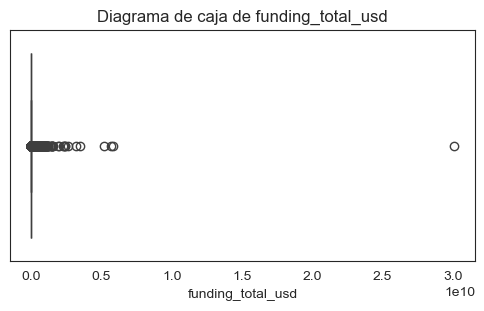

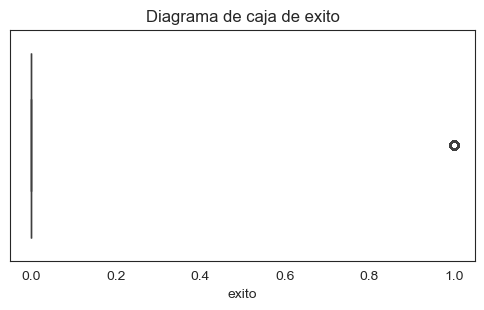

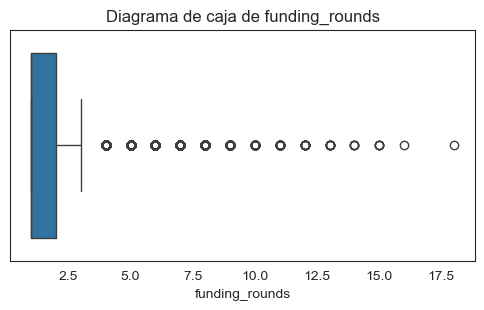

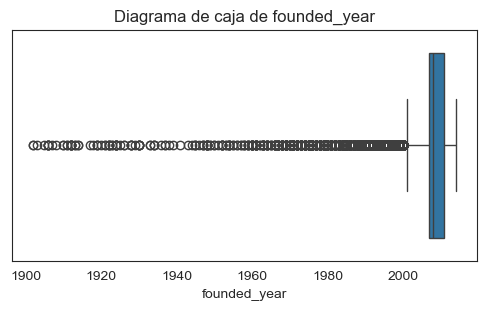

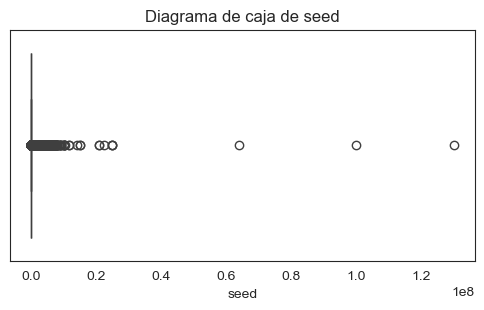

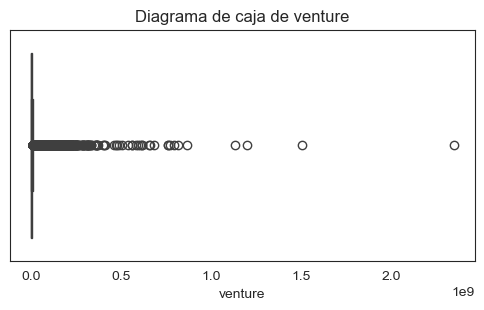

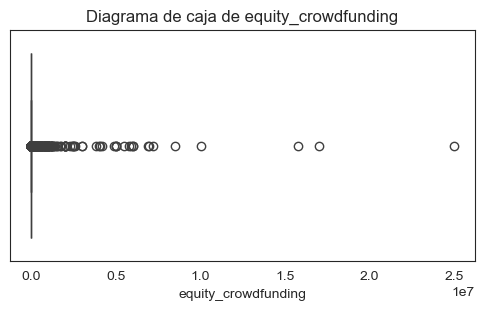

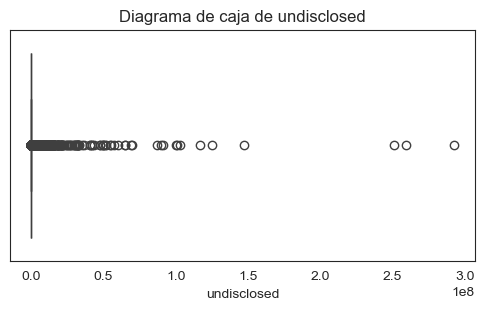

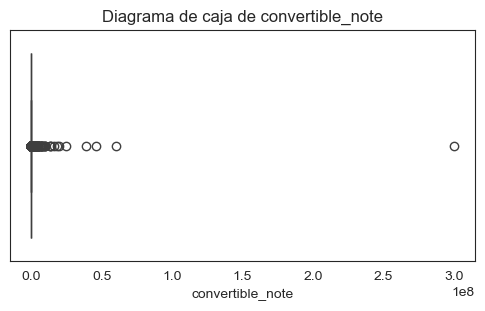

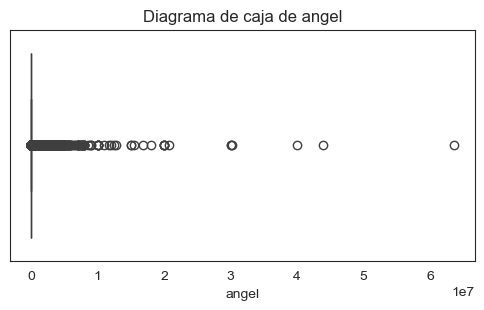

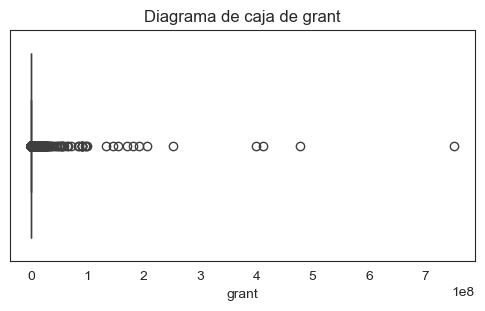

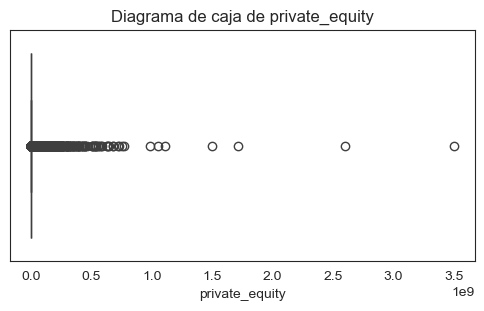

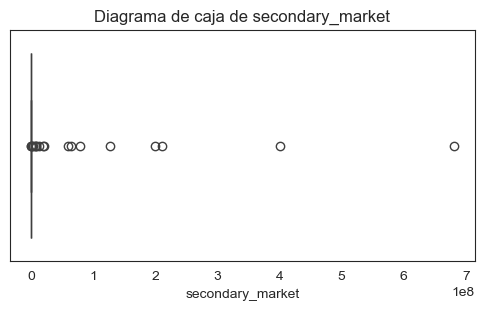

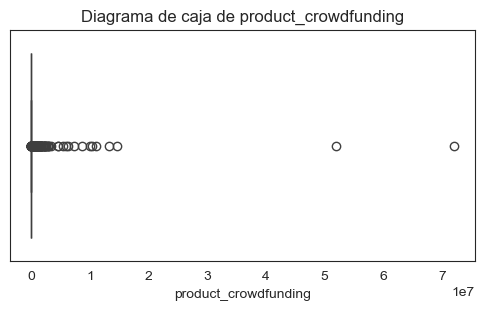

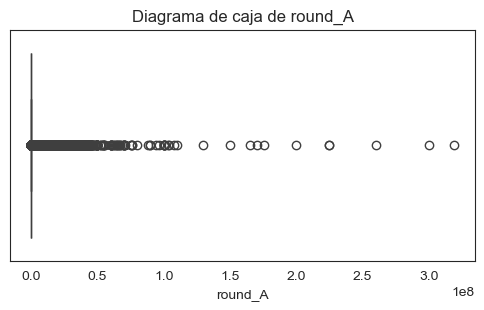

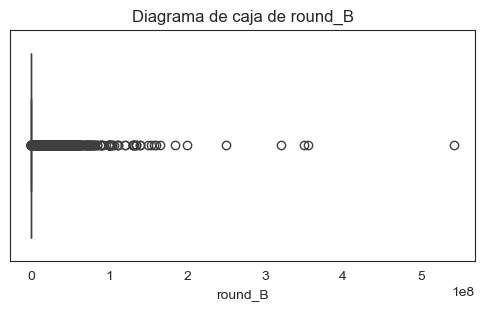

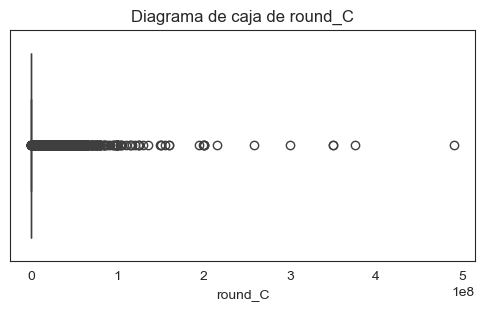

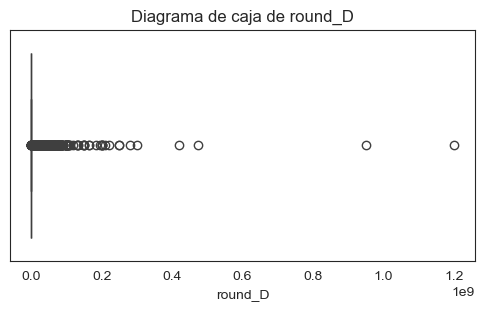

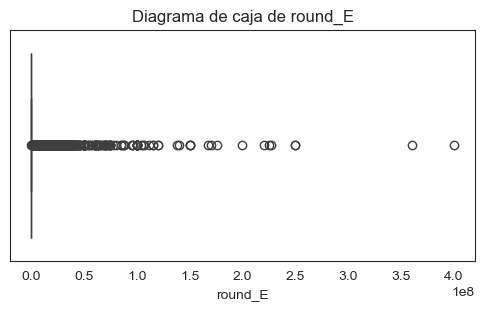

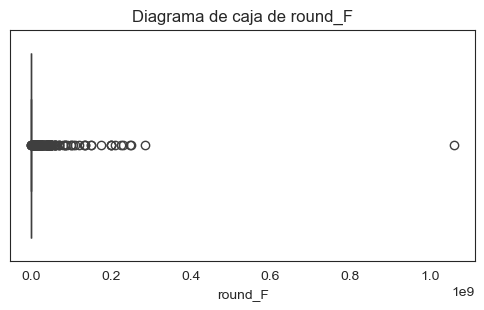

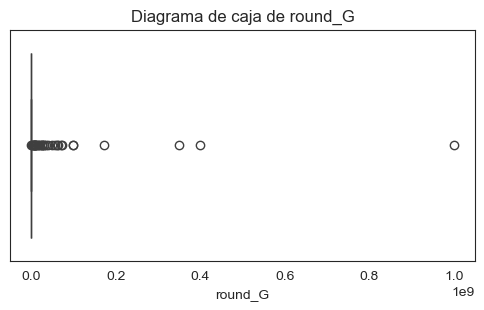

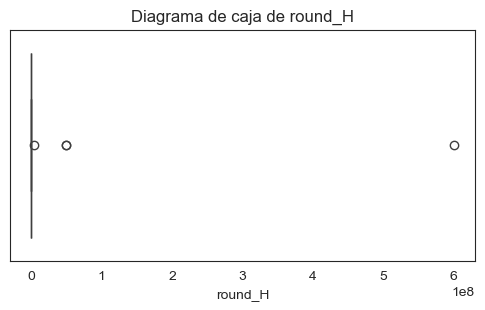

In [41]:
# Filtrar solo las columnas numéricas si es necesario
numeric_cols = df.select_dtypes(include=['float64', 'int64'])

# Dibujar boxplots para cada variable numérica
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Diagrama de caja de {col}')
    plt.show()


### Observaciones a partir de los boxplots

Los **diagramas de caja** que generamos muestran una **asimetría considerable** en la distribución de las variables de financiación. En la mayoría de los casos, los datos están muy concentrados en valores bajos, mientras que hay una **cola larga** hacia la derecha, lo que sugiere la presencia de **outliers o valores extremos**.

Esta distribución tan sesgada puede afectar negativamente al rendimiento de los modelos predictivos, ya que los algoritmos pueden verse influenciados por estos valores extremos.

Por eso, vamos a **revisar cada variable numérica por separado**, intentando entender qué está causando esa asimetría. En función del análisis, aplicaremos **transformaciones estadísticas o técnicas de normalización** que nos ayuden a reducir el sesgo.

El objetivo es que los datos estén en mejores condiciones para el modelado, lo que hará que los resultados de los modelos sean más **estables y fiables**.


### Buscamos variables relacionadas I

In [42]:
cutoffs = {
    'equity_crowdfunding': 3e6,       # Financiación por crowdfunding de acciones → 3 millones de dólares
    'product_crowdfunding': 3e6,      # Financiación por crowdfunding de productos → 3 millones de dólares
    'undisclosed': 20e6,              # Financiación de origen no revelado → 20 millones de dólares
    'venture': 50e6,                  # Financiación de capital riesgo → 50 millones de dólares
    'grant': 5e6,                     # Subvenciones → 5 millones de dólares
    'private_equity': 300e6,          # Capital privado → 300 millones de dólares
    'secondary_market': 100e6,        # Mercado secundario → 100 millones de dólares
    'convertible_note': 5e6,          # Notas convertibles → 5 millones de dólares
    'angel': 5e6,                     # Financiación de inversores ángeles → 5 millones de dólares
    'seed': 10e6,                     # Ronda semilla → 10 millones de dólares
    'round_A': 20e6,                  # Serie A → 20 millones de dólares
    'round_B': 30e6,                  # Serie B → 30 millones de dólares
    'round_C': 40e6,                  # Serie C → 40 millones de dólares
    'round_D': 60e6,                  # Serie D → 60 millones de dólares
    'round_E': 80e6,                  # Serie E → 80 millones de dólares
    'round_F': 100e6,                 # Serie F → 100 millones de dólares
}
# Guardar el número de filas original del conjunto de datos
original_data_count = df.shape[0]

# Aplicar los umbrales máximos definidos para cada tipo de financiación
# y filtrar las filas que superan dichos valores
for funding_type, cutoff in cutoffs.items():
    df = df[df[funding_type] <= cutoff]

# Mostrar información antes y después de eliminar los valores atípicos
print(f"Datos originales: {original_data_count} filas")
print(f"Forma del conjunto de datos tras eliminar los outliers de financiación: {df.shape}")


Datos originales: 48062 filas
Forma del conjunto de datos tras eliminar los outliers de financiación: (45640, 34)


### Justificación de los umbrales aplicados

**Rondas iniciales (Seed, Angel, A, B, C):**  
Los límites establecidos para estas etapas tempranas reflejan las cantidades de financiación que se observan con mayor frecuencia en startups en sus primeras fases. En este punto del desarrollo empresarial, las inversiones suelen ser más moderadas, por lo que se han definido umbrales realistas que permiten descartar operaciones atípicamente altas y mantener el análisis centrado en casos representativos.

**Rondas posteriores (D, E, F):**  
En etapas más avanzadas, es habitual que las empresas necesiten mayores sumas para consolidar su crecimiento o expandirse a nuevos mercados. Por ello, los límites aplicados son más altos y buscan capturar estos niveles de financiación sin que algunas operaciones excepcionales influyan en exceso en el comportamiento general del conjunto de datos.

**Financiación especializada (Private Equity, Crowdfunding, etc.):**  
Este tipo de financiación presenta una gran variabilidad según el sector o el contexto de inversión. Se han definido límites que permiten incluir una gran parte de los casos habituales, pero que al mismo tiempo filtran aquellas operaciones que se alejan significativamente de la norma y que podrían distorsionar los resultados del análisis.


In [43]:
# Análisis de valores atípicos (outliers) para la variable 'funding_rounds'

# Calcular el primer cuartil (Q1) y el tercer cuartil (Q3)
Q1_funding_rounds = df['funding_rounds'].quantile(0.25)
Q3_funding_rounds = df['funding_rounds'].quantile(0.75)
IQR_funding_rounds = Q3_funding_rounds - Q1_funding_rounds  # Rango intercuartílico

# Definir outliers como aquellos que están fuera de 1.5 * IQR por debajo de Q1 o por encima de Q3
outliers_IQR_funding_rounds = df[
    (df['funding_rounds'] < (Q1_funding_rounds - 1.5 * IQR_funding_rounds)) |
    (df['funding_rounds'] > (Q3_funding_rounds + 1.5 * IQR_funding_rounds))
]

# Calcular los Z-scores para detectar outliers extremos
z_scores_funding_rounds = np.abs(stats.zscore(df['funding_rounds']))
outliers_Z_funding_rounds = df[z_scores_funding_rounds > 3]

# Contar el número de valores atípicos detectados por cada método
outliers_IQR_count_funding_rounds = outliers_IQR_funding_rounds.shape[0]
outliers_Z_count_funding_rounds = outliers_Z_funding_rounds.shape[0]

# Imprimir los resultados
print(f"Número de outliers detectados con el método IQR: {outliers_IQR_count_funding_rounds}")
print(f"Número de outliers detectados con el método Z-score: {outliers_Z_count_funding_rounds}")


Número de outliers detectados con el método IQR: 2950
Número de outliers detectados con el método Z-score: 1343


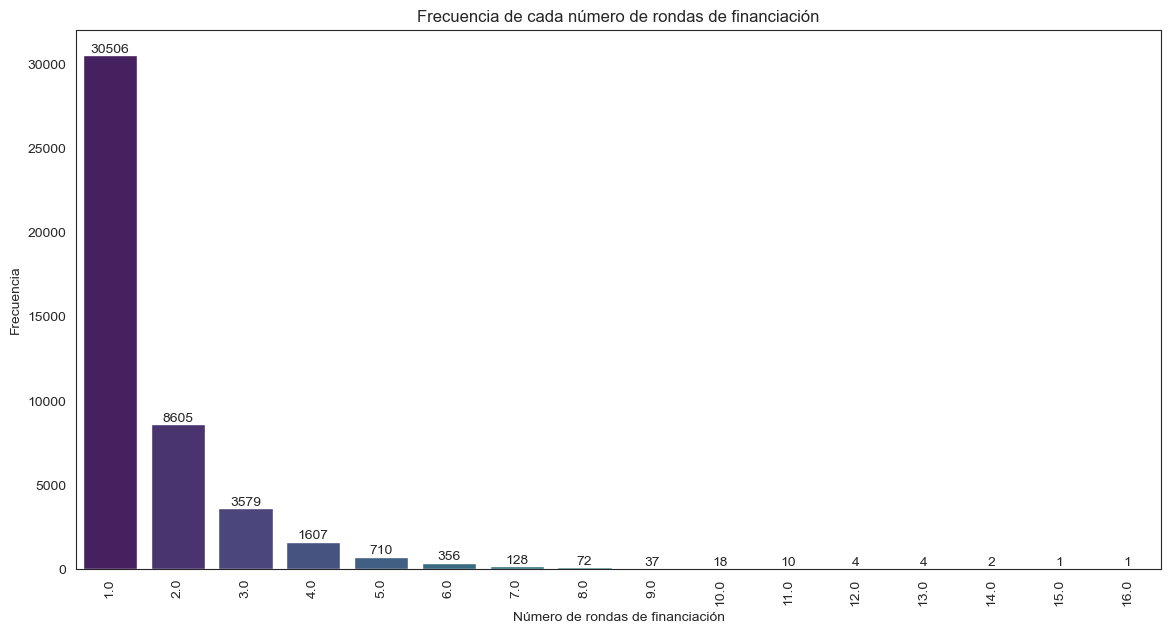

In [44]:
# Contar la frecuencia de cada número de rondas de financiación
funding_rounds_counts = df['funding_rounds'].value_counts().sort_index()

# Crear un gráfico de barras
plt.figure(figsize=(14, 7))
sns.barplot(x=funding_rounds_counts.index, y=funding_rounds_counts.values, palette='viridis')

# Añadir anotaciones con los valores exactos
for i, count in enumerate(funding_rounds_counts.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.title('Frecuencia de cada número de rondas de financiación')
plt.xlabel('Número de rondas de financiación')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)  # Rotar etiquetas si se solapan
plt.show()


### Validación

In [45]:
# === Aplicar eliminación de outliers por IQR
df_iqr = df.copy()
q1 = df_iqr['funding_rounds'].quantile(0.25)
q3 = df_iqr['funding_rounds'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df_iqr = df_iqr[(df_iqr['funding_rounds'] >= lower) & (df_iqr['funding_rounds'] <= upper)]

# === Aplicar eliminación de outliers por Z-score
df_z = df.copy()
z_scores = np.abs(stats.zscore(df_z['funding_rounds']))
df_z = df_z[z_scores <= 3]

# === Separar X e y
X_iqr = df_iqr.drop(columns='exito')
y_iqr = df_iqr['exito']
X_z = df_z.drop(columns='exito')
y_z = df_z['exito']

# === ColumnTransformer (sin funciones que eliminan filas)
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# === Pipelines
pipeline_iqr = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline_z = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# === Split estratificado para cada conjunto
for intento in range(10):
    X_train_iqr, X_val_iqr, y_train_iqr, y_val_iqr = train_test_split(X_iqr, y_iqr, test_size=0.3, stratify=y_iqr, random_state=42+intento)
    if len(np.unique(y_train_iqr)) > 1: break

for intento in range(10):
    X_train_z, X_val_z, y_train_z, y_val_z = train_test_split(X_z, y_z, test_size=0.3, stratify=y_z, random_state=42+intento)
    if len(np.unique(y_train_z)) > 1: break

# === Evaluación
print("🔍 Evaluación con IQR:")
resultado_iqr = evaluar_pipeline(X_train_iqr, y_train_iqr, X_val_iqr, y_val_iqr, pipeline_iqr)

print("\n🔍 Evaluación con Z-score:")
resultado_z = evaluar_pipeline(X_train_z, y_train_z, X_val_z, y_val_z, pipeline_z)


🔍 Evaluación con IQR:
==== Evaluación del modelo ====
F0.7-score: 0.1447
AUC-PR:      0.1478

🔍 Evaluación con Z-score:
==== Evaluación del modelo ====
F0.7-score: 0.1456
AUC-PR:      0.1408


### Criterio para limitar el número de rondas de financiación
Aunque el uso del IQR nos permitiría eliminar valores extremos, este método podría descartar demasiados casos relevantes, especialmente aquellos con un número razonable de rondas. Por eso, en lugar de aplicar un umbral estadístico, optamos por eliminar únicamente las startups que tienen más de 10 rondas de financiación.

Superar esta cifra suele ser poco habitual en el ámbito del venture capital y puede reflejar dificultades prolongadas para alcanzar la rentabilidad o una necesidad extraordinaria de capital. Limitar el número de rondas a un máximo de 10 nos permite mantener el enfoque en trayectorias de inversión más comunes y realistas, lo que mejora tanto la representatividad del conjunto de datos como la capacidad predictiva del modelo.

In [46]:
print("Tamaño del conjunto de datos antes de eliminar outliers en funding_rounds:", df.shape)
df = df[df['funding_rounds'] <= 10]
print("Tamaño del conjunto de datos después de eliminar outliers en funding_rounds:", df.shape)

Tamaño del conjunto de datos antes de eliminar outliers en funding_rounds: (45640, 34)
Tamaño del conjunto de datos después de eliminar outliers en funding_rounds: (45618, 34)


### Buscamos variables relacionadas II

<Axes: xlabel='founded_year', ylabel='Count'>

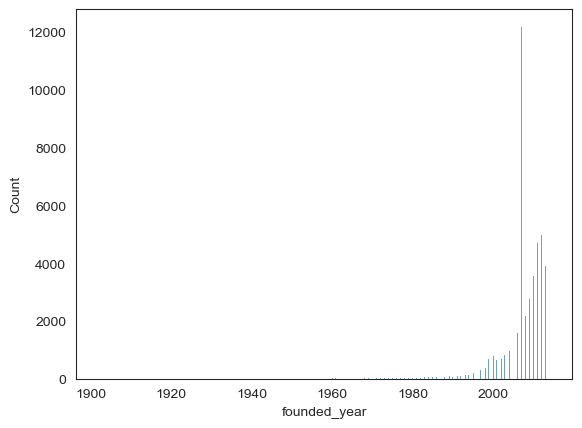

In [47]:
sns.histplot(df['founded_year'].dropna(), kde=False)

In [48]:
print("Tamaño del conjunto de datos antes de eliminar años anteriores a 1990:", df.shape)

df = df[df['founded_year'] >= 1990]

print("Tamaño del conjunto de datos después de eliminar años anteriores a 1990:", df.shape)


Tamaño del conjunto de datos antes de eliminar años anteriores a 1990: (45618, 34)
Tamaño del conjunto de datos después de eliminar años anteriores a 1990: (44769, 34)


<Axes: xlabel='founded_year', ylabel='Count'>

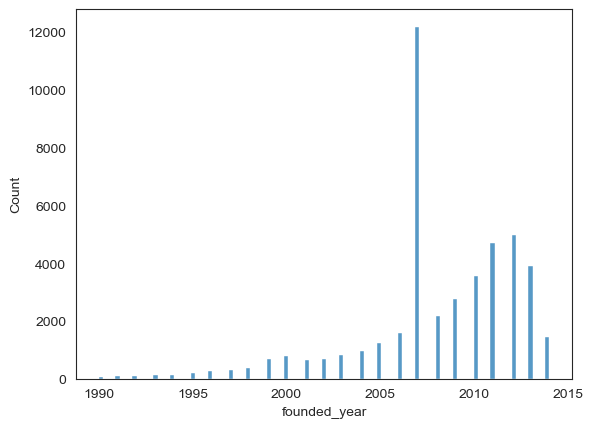

In [49]:
sns.histplot(df['founded_year'].dropna(), kde=False)

Al analizar datos de startups, la variable del año de fundación permite estimar su grado de madurez. Sin embargo, años de fundación excesivamente antiguos pueden distorsionar los análisis y corresponder a entidades que no representan las dinámicas actuales del emprendimiento. Por ello, se emplean técnicas estadísticas como el rango intercuartílico (IQR) y el Z-score para identificar y excluir estos casos atípicos. Esta depuración garantiza que el conjunto de datos se centre en empresas más representativas del panorama empresarial contemporáneo, mejorando así la validez de los análisis realizados.

In [50]:
def calcular_outliers_fecha(df, nombre_columna):
    # Convertir la fecha a número ordinal
    df[nombre_columna + '_ordinal'] = df[nombre_columna].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Calcular Q1, Q3 y el rango intercuartílico (IQR)
    Q1 = df[nombre_columna + '_ordinal'].quantile(0.25)
    Q3 = df[nombre_columna + '_ordinal'].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites para detectar outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Contar outliers usando el método del IQR
    outliers_inferiores_IQR = df[df[nombre_columna + '_ordinal'] < limite_inferior].shape[0]
    outliers_superiores_IQR = df[df[nombre_columna + '_ordinal'] > limite_superior].shape[0]
    
    # Contar outliers usando el método de Z-score
    z_scores = np.abs(stats.zscore(df[nombre_columna + '_ordinal'].dropna()))
    outliers_Z = np.sum(z_scores > 3)

    print(f"Número de outliers inferiores para {nombre_columna} (método IQR): {outliers_inferiores_IQR}")
    print(f"Número de outliers superiores para {nombre_columna} (método IQR): {outliers_superiores_IQR}")
    print(f"Número de outliers para {nombre_columna} (método Z-score): {outliers_Z}")

# Aplicar la función a cada columna de fecha
columnas_fecha = ['founded_at', 'founded_month', 'first_funding_at', 'last_funding_at']
for columna in columnas_fecha:
    if columna in df.columns:
        calcular_outliers_fecha(df, columna)


Número de outliers inferiores para founded_at (método IQR): 1343
Número de outliers superiores para founded_at (método IQR): 0
Número de outliers para founded_at (método Z-score): 44
Número de outliers inferiores para founded_month (método IQR): 1303
Número de outliers superiores para founded_month (método IQR): 0
Número de outliers para founded_month (método Z-score): 501
Número de outliers inferiores para first_funding_at (método IQR): 735
Número de outliers superiores para first_funding_at (método IQR): 0
Número de outliers para first_funding_at (método Z-score): 509
Número de outliers inferiores para last_funding_at (método IQR): 1068
Número de outliers superiores para last_funding_at (método IQR): 0
Número de outliers para last_funding_at (método Z-score): 419


### Validación

In [51]:
def remove_datetime_outliers_by_z(df, datetime_col, threshold=3):
    # Convert to ordinal
    df[datetime_col + '_ordinal'] = df[datetime_col].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)

    # Calculate z-scores
    z_scores = np.abs(stats.zscore(df[datetime_col + '_ordinal'].dropna()))
    outliers_mask = df[datetime_col + '_ordinal'].dropna().index[z_scores > threshold]
    
    print(f"{datetime_col}: Eliminados {len(outliers_mask)} outliers con Z-score")
    
    return df.drop(index=outliers_mask)

# Aplica a todas las columnas datetime
datetime_columns = ['founded_at', 'founded_month', 'first_funding_at', 'last_funding_at']
df_z = df.copy()
for col in datetime_columns:
    if col in df_z.columns:
        df_z = remove_datetime_outliers_by_z(df_z, col)

# === Separar X e y
X_z = df_z.drop(columns='exito')
y_z = df_z['exito']

# === Definir columnas
num_cols = X_z.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_z.select_dtypes(include=['object']).columns.tolist()

# === ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# === Pipeline con SMOTE + RandomForest
pipeline_z = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# === Split estratificado (asegurando ambas clases)
for intento in range(10):
    X_train_z, X_val_z, y_train_z, y_val_z = train_test_split(X_z, y_z, test_size=0.3, stratify=y_z, random_state=42+intento)
    if len(np.unique(y_train_z)) > 1:
        break

# === Evaluación
print("\n🔍 Evaluación tras eliminar outliers temporales con Z-score:")
resultado_z = evaluar_pipeline(X_train_z, y_train_z, X_val_z, y_val_z, pipeline_z)

founded_at: Eliminados 44 outliers con Z-score
founded_month: Eliminados 501 outliers con Z-score
first_funding_at: Eliminados 470 outliers con Z-score
last_funding_at: Eliminados 240 outliers con Z-score

🔍 Evaluación tras eliminar outliers temporales con Z-score:
==== Evaluación del modelo ====
F0.7-score: 0.1082
AUC-PR:      0.2745


Después de haber eliminado previamente los valores atípicos en ``funding_year``, utilizamos los z-scores para eliminar outliers en las variables temporales, ya que este enfoque proporciona una base estadística sólida que tiene en cuenta la distribución de los datos y permite manejar de forma efectiva los valores extremos.

In [52]:
def eliminar_outliers_fecha(df, nombre_columna, umbral_z=3):
    # Convertimos la fecha a un valor numérico ordinal
    df[nombre_columna + '_ordinal'] = df[nombre_columna].map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)
    
    # Calculamos los z-scores
    z_scores = np.abs(stats.zscore(df[nombre_columna + '_ordinal'].dropna()))
    
    # Identificamos los índices que superan el umbral de z-score
    indices_outliers = np.where(z_scores > umbral_z)[0]
    
    # Eliminamos las filas correspondientes
    df.drop(df.index[indices_outliers], inplace=True)
    
    # Mostramos cuántas filas se eliminaron
    num_filas_eliminadas = len(indices_outliers)
    print(f"Filas eliminadas en '{nombre_columna}': {num_filas_eliminadas}")

# Mostramos el tamaño del conjunto de datos antes de la eliminación
print(f"Tamaño del conjunto antes de eliminar outliers (global): {df.shape}")

# Aplicamos la función a cada columna de tipo fecha
columnas_fecha = ['founded_at', 'founded_month', 'first_funding_at', 'last_funding_at']
for columna in columnas_fecha:
    if columna in df.columns:
        eliminar_outliers_fecha(df, columna)

# Mostramos el tamaño final del conjunto de datos
print(f"Tamaño del conjunto después de eliminar outliers (global): {df.shape}")


Tamaño del conjunto antes de eliminar outliers (global): (44769, 38)
Filas eliminadas en 'founded_at': 44
Filas eliminadas en 'founded_month': 500
Filas eliminadas en 'first_funding_at': 500
Filas eliminadas en 'last_funding_at': 423
Tamaño del conjunto después de eliminar outliers (global): (43302, 38)


In [53]:
# Distribution of numerical columns after outlier analysis to check, if all still have values in them
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
print("Distribucion de variables numéricas:\n")
df[numerical_columns].describe().T

Distribucion de variables numéricas:



,count,mean,std,min,25%,50%,75%,max
funding_total_usd,35421.0,8.459030e+06,6.228743e+07,1.0,300000.0,1586185.0,7000000.0,5.800000e+09
exito,43302.0,7.327606e-02,2.605921e-01,0.0,0.0,0.0,0.0,1.000000e+00
funding_rounds,43302.0,1.594707e+00,1.088910e+00,1.0,1.0,1.0,2.0,1.000000e+01
founded_year,43302.0,2.008073e+03,4.196965e+00,1990.0,2007.0,2008.0,2011.0,2.014000e+03
seed,43302.0,2.159456e+05,6.411236e+05,0.0,0.0,0.0,40000.0,1.000000e+07
venture,43302.0,3.924277e+06,8.250985e+06,0.0,0.0,0.0,3690187.5,5.000000e+07
equity_crowdfunding,43302.0,3.059212e+03,5.879975e+04,0.0,0.0,0.0,0.0,3.000000e+06
undisclosed,43302.0,4.901925e+04,6.570073e+05,0.0,0.0,0.0,0.0,2.000000e+07
convertible_note,43302.0,8.962601e+03,1.333088e+05,0.0,0.0,0.0,0.0,5.000000e+06
angel,43302.0,4.992387e+04,2.889956e+05,0.0,0.0,0.0,0.0,5.000000e+06


In [54]:
# Como la columna round_H ahora está vacía (lo cual tiene sentido, ya que casi nunca ocurre también en la realidad), la eliminaremos del conjunto de datos
#df.drop('round_H', axis=1, inplace=True)

## 7. Transformación del tipo de variable

En primer lugar, antes de estandarizar los datos, nos tenemos que asegurar de que están en su tipo correcto.

In [55]:
# Ahora aplica pd.cut en línea sobre esa columna
df['founded_year'] = pd.cut(
    df['founded_year'],
    bins=[1900, 1925, 1950, 1975, 2000, 2015],
    labels=['1900–25','25–50','50–75','75–00','00–14'],
    include_lowest=True
)
df['founded_year'] = df['founded_year'].cat.codes.replace(-1, np.nan)


Creacion de variables (Feature Engineering -> La parte de EDA, esta realizada ya en el primer hito)

Agrupamos los países por continentes y los mercados por industrias como técnica de agregación de características, lo que reduce la dimensionalidad del dataset y estabiliza la variabilidad. Esto simplifica los modelos y mejora su capacidad de generalización. Para las industrias, seguimos la clasificación oficial de Crunchbase:https://support.crunchbase.com/hc/en-us/articles/360043146954-What-Industries-are-included-in-Crunchbase-


In [56]:
admin_services = str('Employer Benefits Programs, Human Resource Automation, Corporate IT, Distribution, Service Providers, Archiving Service, Call Center, Collection Agency, College Recruiting, Courier Service, Debt Collections, Delivery, Document Preparation, Employee Benefits, Extermination Service, Facilities Support Services, Housekeeping Service, Human Resources, Knowledge Management, Office Administration, Packaging Services, Physical Security, Project Management, Staffing Agency, Trade Shows, Virtual Workforce').split(', ')
advertising = str('Creative Industries, Promotional, Advertising Ad Exchange, Ad Network, Ad Retargeting, Ad Server, Ad Targeting, Advertising, Advertising Platforms, Affiliate Marketing, Local Advertising, Mobile Advertising, Outdoor Advertising, SEM, Social Media Advertising, Video Advertising').split(', ')
agriculture = str('Agriculture, AgTech, Animal Feed, Aquaculture, Equestrian, Farming, Forestry, Horticulture, Hydroponics, Livestock').split(', ')
app = str('Application Performance Monitoring, App Stores, Application Platforms, Enterprise Application, App Discovery, Apps, Consumer Applications, Enterprise Applications, Mobile Apps, Reading Apps, Web Apps').split(', ')
artificial_intelli = str('Artificial Intelligence, Intelligent Systems, Machine Learning, Natural Language Processing, Predictive Analytics').split(', ')
biotechnology = str('Synthetic Biology, Bio-Pharm, Bioinformatics, Biometrics, Biopharma, Biotechnology, Genetics, Life Science, Neuroscience, Quantified Self').split(', ')
clothing = str('Fashion, Laundry and Dry-cleaning, Lingerie, Shoes').split(', ')
shopping = str('Consumer Behavior, Customer Support Tools, Discounts, Reviews and Recommendations, Auctions, Classifieds, Collectibles, Consumer Reviews, Coupons, E-Commerce, E-Commerce Platforms, Flash Sale, Gift, Gift Card, Gift Exchange, Gift Registry, Group Buying, Local Shopping, Made to Order, Marketplace, Online Auctions, Personalization, Point of Sale, Price Comparison, Rental, Retail, Retail Technology, Shopping, Shopping Mall, Social Shopping, Sporting Goods, Vending and Concessions, Virtual Goods, Wholesale').split(', ')
community = str("Self Development, Sex, Forums, Match-Making, Babies, Identity, Women, Kids, Entrepreneur, Networking, Adult, Baby, Cannabis, Children, Communities, Dating, Elderly, Family, Funerals, Humanitarian, Leisure, LGBT, Lifestyle, Men's, Online Forums, Parenting, Pet, Private Social Networking, Professional Networking, Q&A, Religion, Retirement, Sex Industry, Sex Tech, Social, Social Entrepreneurship, Teenagers, Virtual World, Wedding, Women's, Young Adults").split(', ')
electronics  = str('Mac, iPod Touch, Tablets, iPad, iPhone, Computer, Consumer Electronics, Drones, Electronics, Google Glass, Mobile Devices, Nintendo, Playstation, Roku, Smart Home, Wearables, Windows Phone, Xbox').split(', ')
consumer_goods= str('Commodities, Sunglasses, Groceries, Batteries, Cars, Beauty, Comics, Consumer Goods, Cosmetics, DIY, Drones, Eyewear, Fast-Moving Consumer Goods, Flowers, Furniture, Green Consumer Goods, Handmade, Jewelry, Lingerie, Shoes, Tobacco, Toys').split(', ')
content = str('E-Books, MicroBlogging, Opinions, Blogging Platforms, Content Delivery Network, Content Discovery, Content Syndication, Creative Agency, DRM, EBooks, Journalism, News, Photo Editing, Photo Sharing, Photography, Printing, Publishing, Social Bookmarking, Video Editing, Video Streaming').split(', ')
data = str('Optimization, A/B Testing, Analytics, Application Performance Management, Artificial Intelligence, Big Data, Bioinformatics, Biometrics, Business Intelligence, Consumer Research, Data Integration, Data Mining, Data Visualization, Database, Facial Recognition, Geospatial, Image Recognition, Intelligent Systems, Location Based Services, Machine Learning, Market Research, Natural Language Processing, Predictive Analytics, Product Research, Quantified Self, Speech Recognition, Test and Measurement, Text Analytics, Usability Testing').split(', ')
design = str('Visualization, Graphics, Design, Designers, CAD, Consumer Research, Data Visualization, Fashion, Graphic Design, Human Computer Interaction, Industrial Design, Interior Design, Market Research, Mechanical Design, Product Design, Product Research, Usability Testing, UX Design, Web Design').split(', ')
education = str('Universities, College Campuses, University Students, High Schools, All Students, Colleges, Alumni, Charter Schools, College Recruiting, Continuing Education, Corporate Training, E-Learning, EdTech, Education, Edutainment, Higher Education, Language Learning, MOOC, Music Education, Personal Development, Primary Education, Secondary Education, Skill Assessment, STEM Education, Textbook, Training, Tutoring, Vocational Education').split(', ')
energy = str('Gas, Natural Gas Uses, Oil, Oil & Gas, Battery, Biofuel, Biomass Energy, Clean Energy, Electrical Distribution, Energy, Energy Efficiency, Energy Management, Energy Storage, Fossil Fuels, Fuel, Fuel Cell, Oil and Gas, Power Grid, Renewable Energy, Solar, Wind Energy').split(', ')
events = str('Concerts, Event Management, Event Promotion, Events, Nightclubs, Nightlife, Reservations, Ticketing, Wedding').split(', ')
financial = str('Debt Collecting, P2P Money Transfer, Investment Management, Trading, Accounting, Angel Investment, Asset Management, Auto Insurance, Banking, Bitcoin, Commercial Insurance, Commercial Lending, Consumer Lending, Credit, Credit Bureau, Credit Cards, Crowdfunding, Cryptocurrency, Debit Cards, Debt Collections, Finance, Financial Exchanges, Financial Services, FinTech, Fraud Detection, Funding Platform, Gift Card, Health Insurance, Hedge Funds, Impact Investing, Incubators, Insurance, InsurTech, Leasing, Lending, Life Insurance, Micro Lending, Mobile Payments, Payments, Personal Finance, Prediction Markets, Property Insurance, Real Estate Investment, Stock Exchanges, Trading Platform, Transaction Processing, Venture Capital, Virtual Currency, Wealth Management').split(', ')
food = str('Specialty Foods, Bakery, Brewing, Cannabis, Catering, Coffee, Confectionery, Cooking, Craft Beer, Dietary Supplements, Distillery, Farmers Market, Food and Beverage, Food Delivery, Food Processing, Food Trucks, Fruit, Grocery, Nutrition, Organic Food, Recipes, Restaurants, Seafood, Snack Food, Tea, Tobacco, Wine And Spirits, Winery').split(', ')
gaming = str('Game, Games, Casual Games, Console Games, Contests, Fantasy Sports, Gambling, Gamification, Gaming, MMO Games, Online Games, PC Games, Serious Games, Video Games').split(', ')
government = str('Polling, Governance, CivicTech, Government, GovTech, Law Enforcement, Military, National Security, Politics, Public Safety, Social Assistance').split(', ')
hardware= str('Cable, 3D, 3D Technology, Application Specific Integrated Circuit (ASIC), Augmented Reality, Cloud Infrastructure, Communication Hardware, Communications Infrastructure, Computer, Computer Vision, Consumer Electronics, Data Center, Data Center Automation, Data Storage, Drone Management, Drones, DSP, Electronic Design Automation (EDA), Electronics, Embedded Systems, Field-Programmable Gate Array (FPGA), Flash Storage, Google Glass, GPS, GPU, Hardware, Industrial Design, Laser, Lighting, Mechanical Design, Mobile Devices, Network Hardware, NFC, Nintendo, Optical Communication, Playstation, Private Cloud, Retail Technology, RFID, RISC, Robotics, Roku, Satellite Communication, Semiconductor, Sensor, Sex Tech, Telecommunications, Video Conferencing, Virtual Reality, Virtualization, Wearables, Windows Phone, Wireless, Xbox').split(', ')
health_care = str('Senior Health, Physicians, Electronic Health Records, Doctors, Healthcare Services, Diagnostics, Alternative Medicine, Assisted Living, Assistive Technology, Biopharma, Cannabis, Child Care, Clinical Trials, Cosmetic Surgery, Dental, Diabetes, Dietary Supplements, Elder Care, Electronic Health Record (EHR), Emergency Medicine, Employee Benefits, Fertility, First Aid, Funerals, Genetics, Health Care, Health Diagnostics, Home Health Care, Hospital, Medical, Medical Device, mHealth, Nursing and Residential Care, Nutraceutical, Nutrition, Outpatient Care, Personal Health, Pharmaceutical, Psychology, Rehabilitation, Therapeutics, Veterinary, Wellness').split(', ')
it = str('Distributors, Algorithms, ICT, M2M, Technology, Business Information Systems, CivicTech, Cloud Data Services, Cloud Management, Cloud Security, CMS, Contact Management, CRM, Cyber Security, Data Center, Data Center Automation, Data Integration, Data Mining, Data Visualization, Document Management, E-Signature, Email, GovTech, Identity Management, Information and Communications Technology (ICT), Information Services, Information Technology, Intrusion Detection, IT Infrastructure, IT Management, Management Information Systems, Messaging, Military, Network Security, Penetration Testing, Private Cloud, Reputation, Sales Automation, Scheduling, Social CRM, Spam Filtering, Technical Support, Unified Communications, Video Chat, Video Conferencing, Virtualization, VoIP').split(', ')
internet = str('Online Identity, Cyber, Portals, Web Presence Management, Domains, Tracking, Web Tools, Curated Web, Search, Cloud Computing, Cloud Data Services, Cloud Infrastructure, Cloud Management, Cloud Storage, Darknet, Domain Registrar, E-Commerce Platforms, Ediscovery, Email, Internet, Internet of Things, ISP, Location Based Services, Messaging, Music Streaming, Online Forums, Online Portals, Private Cloud, Product Search, Search Engine, SEM, Semantic Search, Semantic Web, SEO, SMS, Social Media, Social Media Management, Social Network, Unified Communications, Vertical Search, Video Chat, Video Conferencing, Visual Search, VoIP, Web Browsers, Web Hosting').split(', ')
invest = str('Angel Investment, Banking, Commercial Lending, Consumer Lending, Credit, Credit Cards, Financial Exchanges, Funding Platform, Hedge Funds, Impact Investing, Incubators, Micro Lending, Stock Exchanges, Trading Platform, Venture Capital').split(', ')
manufacturing = str('Innovation Engineering, Civil Engineers, Heavy Industry, Engineering Firms, Systems, 3D Printing, Advanced Materials, Foundries, Industrial, Industrial Automation, Industrial Engineering, Industrial Manufacturing, Machinery Manufacturing, Manufacturing, Paper Manufacturing, Plastics and Rubber Manufacturing, Textiles, Wood Processing').split(', ')
media = str('Writers, Creative, Television, Entertainment, Media, Advice, Animation, Art, Audio, Audiobooks, Blogging Platforms, Broadcasting, Celebrity, Concerts, Content, Content Creators, Content Discovery, Content Syndication, Creative Agency, Digital Entertainment, Digital Media, DRM, EBooks, Edutainment, Event Management, Event Promotion, Events, Film, Film Distribution, Film Production, Guides, In-Flight Entertainment, Independent Music, Internet Radio, Journalism, Media and Entertainment, Motion Capture, Music, Music Education, Music Label, Music Streaming, Music Venues, Musical Instruments, News, Nightclubs, Nightlife, Performing Arts, Photo Editing, Photo Sharing, Photography, Podcast, Printing, Publishing, Reservations, Social Media, Social News, Theatre, Ticketing, TV, TV Production, Video, Video Editing, Video on Demand, Video Streaming, Virtual World').split(', ')
message = str('Unifed Communications, Chat, Email, Meeting Software, Messaging, SMS, Unified Communications, Video Chat, Video Conferencing, VoIP, Wired Telecommunications').split(', ')
mobile = str('Android, Google Glass, iOS, mHealth, Mobile, Mobile Apps, Mobile Devices, Mobile Payments, Windows Phone, Wireless').split(', ')
music = str('Audio, Audiobooks, Independent Music, Internet Radio, Music, Music Education, Music Label, Music Streaming, Musical Instruments, Podcast').split(', ')
resource = str('Biofuel, Biomass Energy, Fossil Fuels, Mineral, Mining, Mining Technology, Natural Resources, Oil and Gas, Precious Metals, Solar, Timber, Water, Wind Energy').split(', ')
navigation = str('Maps, Geospatial, GPS, Indoor Positioning, Location Based Services, Mapping Services, Navigation').split(', ')
other = str('Mass Customization, Monetization, Testing, Subscription Businesses, Mobility, Incentives, Peer-to-Peer, Nonprofits, Alumni, Association, B2B, B2C, Blockchain, Charity, Collaboration, Collaborative Consumption, Commercial, Consumer, Crowdsourcing, Customer Service, Desktop Apps, Emerging Markets, Enterprise, Ethereum, Franchise, Freemium, Generation Y, Generation Z, Homeless Shelter, Infrastructure, Knowledge Management, LGBT Millennials, Non Profit, Peer to Peer, Professional Services, Project Management, Real Time, Retirement, Service Industry, Sharing Economy, Small and Medium Businesses, Social Bookmarking, Social Impact, Subscription Service, Technical Support, Underserved Children, Universities').split(', ')
payment = str('Billing, Bitcoin, Credit Cards, Cryptocurrency, Debit Cards, Fraud Detection, Mobile Payments, Payments, Transaction Processing, Virtual Currency').split(', ')
platforms = str('Development Platforms, Android, Facebook, Google, Google Glass, iOS, Linux, macOS, Nintendo, Operating Systems, Playstation, Roku, Tizen, Twitter, WebOS, Windows, Windows Phone, Xbox').split(', ')
privacy = str('Digital Rights Management, Personal Data, Cloud Security, Corrections Facilities, Cyber Security, DRM, E-Signature, Fraud Detection, Homeland Security, Identity Management, Intrusion Detection, Law Enforcement, Network Security, Penetration Testing, Physical Security, Privacy, Security').split(', ')
services = str('Funeral Industry, English-Speaking, Spas, Plumbers, Service Industries, Staffing Firms, Translation, Career Management, Business Services, Services, Accounting, Business Development, Career Planning, Compliance, Consulting, Customer Service, Employment, Environmental Consulting, Field Support, Freelance, Intellectual Property, Innovation Management, Legal, Legal Tech, Management Consulting, Outsourcing, Professional Networking, Quality Assurance, Recruiting, Risk Management, Social Recruiting, Translation Service').split(', ')
realestate= str('Office Space, Self Storage, Brokers, Storage, Home Owners, Self Storage , Realtors, Home & Garden, Utilities, Home Automation, Architecture, Building Maintenance, Building Material, Commercial Real Estate, Construction, Coworking, Facility Management, Fast-Moving Consumer Goods, Green Building, Home and Garden, Home Decor, Home Improvement, Home Renovation, Home Services, Interior Design, Janitorial Service, Landscaping, Property Development, Property Management, Real Estate, Real Estate Investment, Rental Property, Residential, Self-Storage, Smart Building, Smart Cities, Smart Home, Timeshare, Vacation Rental').split(', ')
sales = str('Advertising, Affiliate Marketing, App Discovery, App Marketing, Brand Marketing, Cause Marketing, Content Marketing, CRM, Digital Marketing, Digital Signage, Direct Marketing, Direct Sales, Email Marketing, Lead Generation, Lead Management, Local, Local Advertising, Local Business, Loyalty Programs, Marketing, Marketing Automation, Mobile Advertising, Multi-level Marketing, Outdoor Advertising, Personal Branding, Public Relations, Sales, Sales Automation, SEM, SEO, Social CRM, Social Media Advertising, Social Media Management, Social Media Marketing, Sponsorship, Video Advertising').split(', ')
science = str('Face Recognition, New Technologies, Advanced Materials, Aerospace, Artificial Intelligence, Bioinformatics, Biometrics, Biopharma, Biotechnology, Chemical, Chemical Engineering, Civil Engineering, Embedded Systems, Environmental Engineering, Human Computer Interaction, Industrial Automation, Industrial Engineering, Intelligent Systems, Laser, Life Science, Marine Technology, Mechanical Engineering, Nanotechnology, Neuroscience, Nuclear, Quantum Computing, Robotics, Semiconductor, Software Engineering, STEM Education').split(', ')
software = str('Business Productivity, 3D Technology, Android, App Discovery, Application Performance Management, Apps, Artificial Intelligence, Augmented Reality, Billing, Bitcoin, Browser Extensions, CAD, Cloud Computing, Cloud Management, CMS, Computer Vision, Consumer Applications, Consumer Software, Contact Management, CRM, Cryptocurrency, Data Center Automation, Data Integration, Data Storage, Data Visualization, Database, Developer APIs, Developer Platform, Developer Tools, Document Management, Drone Management, E-Learning, EdTech, Electronic Design Automation (EDA), Embedded Software, Embedded Systems, Enterprise Applications, Enterprise Resource Planning (ERP), Enterprise Software, Facial Recognition, File Sharing, IaaS, Image Recognition, iOS, Linux, Machine Learning, macOS, Marketing Automation, Meeting Software, Mobile Apps, Mobile Payments, MOOC, Natural Language Processing, Open Source, Operating Systems, PaaS, Predictive Analytics, Presentation Software, Presentations, Private Cloud, Productivity Tools, QR Codes, Reading Apps, Retail Technology, Robotics, SaaS, Sales Automation, Scheduling, Sex Tech, Simulation, SNS, Social CRM, Software, Software Engineering, Speech Recognition, Task Management, Text Analytics, Transaction Processing, Video Conferencing, Virtual Assistant, Virtual Currency, Virtual Desktop, Virtual Goods, Virtual Reality, Virtual World, Virtualization, Web Apps, Web Browsers, Web Development').split(', ')
sports = str('American Football, Baseball, Basketball, Boating, Cricket, Cycling, Diving, eSports, Fantasy Sports, Fitness, Golf, Hockey, Hunting, Outdoors, Racing, Recreation, Rugby, Sailing, Skiing, Soccer, Sporting Goods, Sports, Surfing, Swimming, Table Tennis, Tennis, Ultimate Frisbee, Volley Ball').split(', ')
sustainability = str('Green, Wind, Biomass Power Generation, Renewable Tech, Environmental Innovation, Renewable Energies, Clean Technology, Biofuel, Biomass Energy, Clean Energy, CleanTech, Energy Efficiency, Environmental Engineering, Green Building, Green Consumer Goods, GreenTech, Natural Resources, Organic, Pollution Control, Recycling, Renewable Energy, Solar, Sustainability, Waste Management, Water Purification, Wind Energy').split(', ')
transportation = str('Taxis, Air Transportation, Automotive, Autonomous Vehicles, Car Sharing, Courier Service, Delivery Service, Electric Vehicle, Ferry Service, Fleet Management, Food Delivery, Freight Service, Last Mile Transportation, Limousine Service, Logistics, Marine Transportation, Parking, Ports and Harbors, Procurement, Public Transportation, Railroad, Recreational Vehicles, Ride Sharing, Same Day Delivery, Shipping, Shipping Broker, Space Travel, Supply Chain Management, Taxi Service, Transportation, Warehousing, Water Transportation').split(', ')
travel = str('Adventure Travel, Amusement Park and Arcade, Business Travel, Casino, Hospitality, Hotel, Museums and Historical Sites, Parks, Resorts, Timeshare, Tour Operator, Tourism, Travel, Travel Accommodations, Travel Agency, Vacation Rental').split(', ')
video = str('Animation, Broadcasting, Film, Film Distribution, Film Production, Motion Capture, TV, TV Production, Video, Video Editing, Video on Demand, Video Streaming').split(', ')

In [57]:
#utilizamos un diccionario para asignar a cada uno su respectivo grupo
industry_keywords = {
    "Administrative Services": admin_services,
    "Software": software,
    "Advertising": advertising,
    "Agriculture": agriculture,
    "App" : app,
    "Artificial Intelligence": artificial_intelli,
    "Biotechnology": biotechnology,
    "Clothing" : clothing,
    "Shopping" : shopping,
    "Community" : community,
    "Electronics" : electronics,
    "Consumer Goods": consumer_goods,
    "Content": content,
    "Data" : data,
    "Design" : design,
    "Education" : education,
    "Energy" : energy,
    "Events" : events,
    "Financial" : financial,
    "Food" : food,
    "Gaming" : gaming,
    "Goverment" : government,
    "Hardware" : hardware,
    "Health Care" : health_care,
    "Video": video,
    "Travel": travel,
    "Transportation": transportation,
    "Sustainability": sustainability,
    "Sports": sports,
    "Software": software,
    "Science": science,
    "Sales": sales,
    "Real Estate": realestate,
    "Services": services,
    "Privacy": privacy,
    "Platforms": platforms,
    "Payment": payment,
    "Other": other,
    "Navigation": navigation,
    "Resource": resource,
    "Music": music,
    "Mobile": mobile,
    "Message" : message,
    "Media": media,
    "Manufacturing": manufacturing,
    "Invest": invest,
    "Internet": internet,
    "IT": it
}

In [58]:
def get_industry_group(market_string):
    if not isinstance(market_string, str):  # Comprobamos que es string
        return "Unknown" 
    for industry, keywords in industry_keywords.items():
        # Expresion regular para buscar palabras clave
        pattern = '|'.join(map(re.escape, keywords))
        if re.search(pattern, market_string, flags=re.IGNORECASE):
            return industry
    return "Other" 

df['industry_group'] = df['market'].apply(get_industry_group)

In [59]:
print("Number of unique industries:", df['industry_group'].nunique())
df.groupby('industry_group').size().sort_values(ascending = False).reset_index()

Number of unique industries: 46


,industry_group,0
0,Software,7937
1,Unknown,3254
2,Biotechnology,3044
3,Health Care,2769
4,Internet,2589
5,Shopping,2338
6,Mobile,1873
7,Community,1761
8,Advertising,1472
9,Gaming,1275


Mapeo de los paises - Continentes (no lo he hecho hace falta otro dataset)

Creacion de categorías para distintos fundings.. -> transformación de continuas en categoricas (binning).</br>
El binning sirve para convertir variables continuas en categorías, lo que hace que el modelo sea más fácil de entender y puede ayudar a que funcione mejor. También reduce el impacto de pequeñas variaciones o errores en los datos, algo útil cuando hay mucho ruido en el conjunto.

In [60]:
df = df.drop(['market'], axis=1) #ya tenemos industry_group, no necesitamos market

In [61]:
def calculate_funding_total(df):
    df["funding_total_usd"] = df["funding_total_usd"].fillna(0)
       
    columns_to_sum = ['funding_rounds', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed', 
                      'convertible_note', 'angel', 'grant', 'private_equity', 'secondary_market', 
                      'product_crowdfunding', 'round_A', 'round_B', 'round_C', 'round_D', 
                      'round_E', 'round_F', 'round_G', 'round_H']
    df["funding_total_usd"] = df[columns_to_sum].sum(axis=1)

calculate_funding_total(df)

In [62]:
df[['funding_rounds', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'angel', 'grant',
       'private_equity',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
      'funding_total_usd']].describe().T

,count,mean,std,min,25%,50%,75%,max
funding_rounds,43302.0,1.594707e+00,1.088910e+00,1.0,1.0,1.0,2.00,10.0
seed,43302.0,2.159456e+05,6.411236e+05,0.0,0.0,0.0,40000.00,10000000.0
venture,43302.0,3.924277e+06,8.250985e+06,0.0,0.0,0.0,3690187.50,50000000.0
equity_crowdfunding,43302.0,3.059212e+03,5.879975e+04,0.0,0.0,0.0,0.00,3000000.0
undisclosed,43302.0,4.901925e+04,6.570073e+05,0.0,0.0,0.0,0.00,20000000.0
convertible_note,43302.0,8.962601e+03,1.333088e+05,0.0,0.0,0.0,0.00,5000000.0
angel,43302.0,4.992387e+04,2.889956e+05,0.0,0.0,0.0,0.00,5000000.0
grant,43302.0,1.454310e+04,1.926798e+05,0.0,0.0,0.0,0.00,5000000.0
private_equity,43302.0,1.009406e+06,1.157698e+07,0.0,0.0,0.0,0.00,300000000.0
secondary_market,43302.0,2.322890e+03,3.110197e+05,0.0,0.0,0.0,0.00,60000000.0


In [63]:
#A partir del analisis, definimos las etiquetas por los cuantiles

etiquetas = ["low", "medium", "medium-high", "high"]

df["category_total"] = pd.qcut(df["funding_total_usd"], q=4, labels=etiquetas)

df.groupby('category_total',observed=False).size()

category_total
low            11006
medium         10728
medium-high    10742
high           10826
dtype: int64

Dividir la variable de financiación total en rangos como "baja", "media", "media-alta" y "alta" facilita bastante el análisis porque reduce la dispersión que hay en los datos. En muchos casos, no se tiene el dato exacto o hay startups con cifras muy distintas, lo que hace difícil compararlas directamente. Al agrupar por niveles, se puede tener una idea general de cuánto ha recibido cada startup sin entrar en números concretos, lo cual es útil para hacer comparaciones rápidas o sacar conclusiones cuando los datos son incompletos o poco claros.

In [64]:
#Comprobamos rendimiento del modelo con las nuevas variables
X = df.drop(columns=['exito'])
y = df['exito']

# Separar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Crear un preprocesador
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Crear pipeline con SMOTE + RandomForest
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Dividir los datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Evaluar el modelo
print("\n🔍 Evaluación del modelo con las nuevas variables:")
resultado = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)



🔍 Evaluación del modelo con las nuevas variables:
==== Evaluación del modelo ====
F0.7-score: 0.1384
AUC-PR:      0.3025


## 8. Creación de nuevas variables

Creacion de avg_years_between_round ->  variable importante ya que las start ups normalmente crecen rapido y tienen unos 18-24 meses entre rondas de inversión hasta alcanzar exito. Es una variable creada a partir de fundin_duartion_days, last_funding_at y funding_rounds

In [65]:
df['funding_duration_days'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
df['avg_days_between_round'] = df['funding_duration_days'] / df['funding_rounds']

df['avg_years_between_round'] = df['avg_days_between_round'] / 365

df['avg_years_between_round']

0        0.000000
1        0.152055
2        0.000000
3        0.000000
4        0.054795
           ...   
49433    0.000000
49434    0.000000
49435    0.572055
49436    0.000000
49437    1.210959
Name: avg_years_between_round, Length: 43302, dtype: float64

In [66]:
if((df["avg_years_between_round"].isna().sum()) > 0): #eliminamos los nulos
    df = df.dropna(subset=["avg_years_between_round"])

Creacion de variable -> avg_amount_per_round -> Variable que representa cuanto dinero se consigue en el funding de distintas rondas, ya que la variable funding total no representa adecuadamente el funding que recibe una compañía, que podría ser muy bajo comparado con otra, pero puede haber tenido varias rondas menos de funding, lo que significaría que obtendría más por cada ronda. Para representar eso creamos la siguietne variable.

In [67]:
df["avg_raised_amount_usd"] = df["funding_total_usd"]/df["funding_rounds"]
df["avg_raised_amount_usd"]

0         1750001.0
1         2000001.0
2           40001.0
3         1500001.0
4           30001.0
            ...    
49433      320001.0
49434     3174603.0
49435       19480.6
49436     9300001.0
49437    13500001.0
Name: avg_raised_amount_usd, Length: 43292, dtype: float64

In [68]:
#Compramobos rendimiento tras añadir estas 2 variables de funding
X = df.drop(columns=['exito'])
y = df['exito']

# Separar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Crear un preprocesador
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='mean'), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Crear pipeline con SMOTE + RandomForest
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Dividir los datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Evaluar el modelo
print("\n🔍 Evaluación del modelo con las nuevas variables:")
resultado = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)


🔍 Evaluación del modelo con las nuevas variables:
==== Evaluación del modelo ====
F0.7-score: 0.1466
AUC-PR:      0.2981


## 9. Procesamiento de variables categóricas y numéricas mediante codificación, imputación y escalado


Evaluando combinación: OneHotEncoder, SimpleImputer_mean, NoScaler
Fb-score: 0.1104
ROC AUC: 0.8292
Tiempo de ejecución: 136.96 segundos

Evaluando combinación: OneHotEncoder, SimpleImputer_mean, StandardScaler
Fb-score: 0.1582
ROC AUC: 0.8301
Tiempo de ejecución: 160.34 segundos

Evaluando combinación: OneHotEncoder, SimpleImputer_mean, MinMaxScaler
Fb-score: 0.2608
ROC AUC: 0.8277
Tiempo de ejecución: 143.83 segundos

Evaluando combinación: OneHotEncoder, SimpleImputer_mean, RobustScaler
Fb-score: 0.1319
ROC AUC: 0.8282
Tiempo de ejecución: 148.13 segundos

Evaluando combinación: OrdinalEncoder, SimpleImputer_mean, NoScaler
Fb-score: 0.1779
ROC AUC: 0.8211
Tiempo de ejecución: 20.00 segundos

Evaluando combinación: OrdinalEncoder, SimpleImputer_mean, StandardScaler
Fb-score: 0.2379
ROC AUC: 0.8267
Tiempo de ejecución: 19.28 segundos

Evaluando combinación: OrdinalEncoder, SimpleImputer_mean, MinMaxScaler
Fb-score: 0.2307
ROC AUC: 0.8271
Tiempo de ejecución: 20.81 segundos

Evaluando

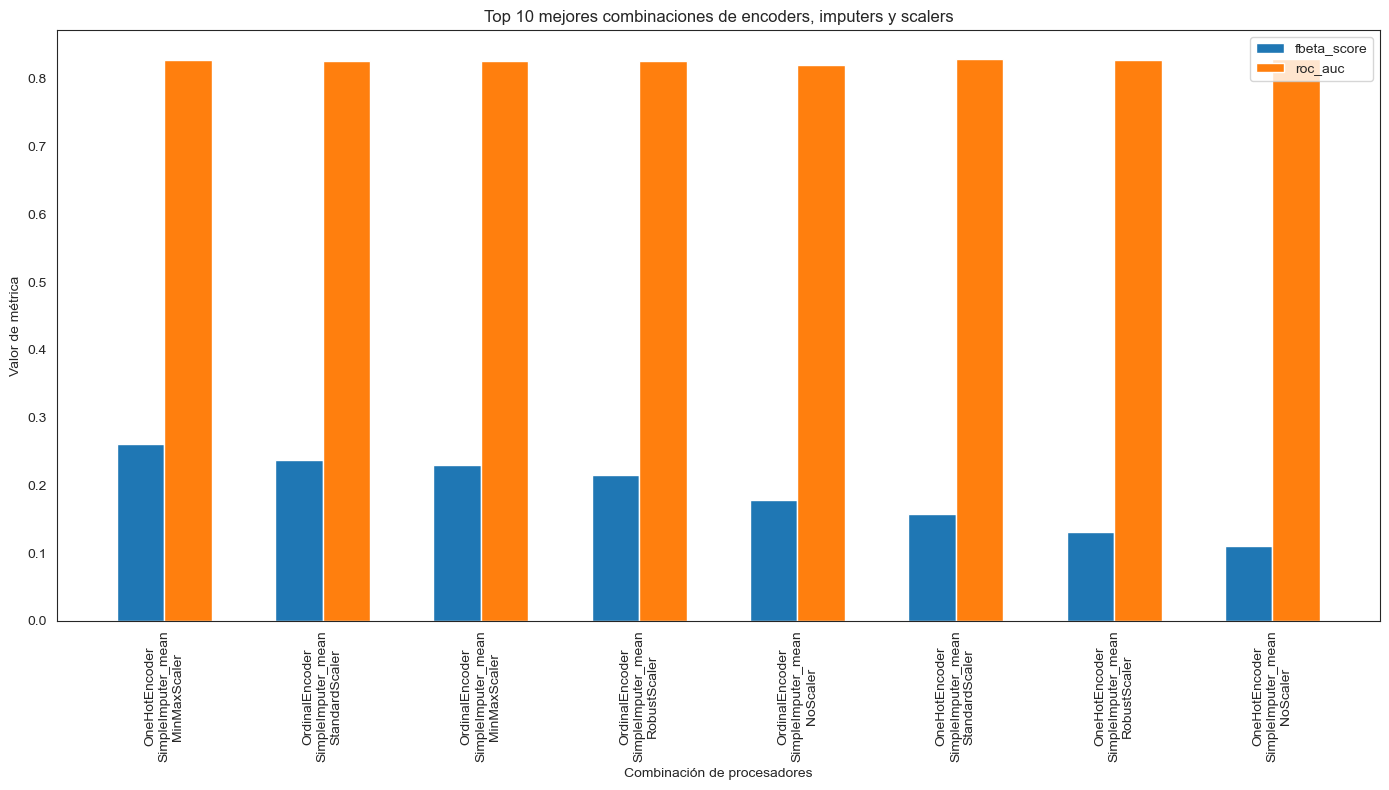

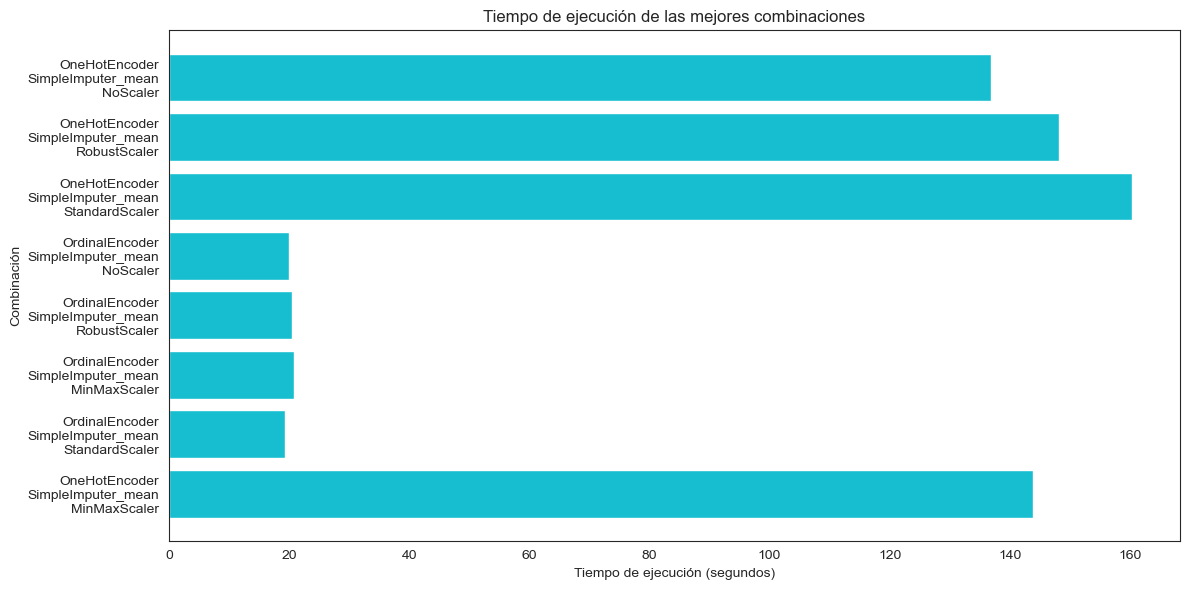


--- MEJOR COMBINACIÓN ---
Encoder: OneHotEncoder
Imputer: SimpleImputer_mean
Scaler: MinMaxScaler
F-beta score: 0.2608
ROC AUC: 0.8277


In [69]:

# --- Prepara los datos ---
# X = df.drop(columns=['exito'])
# y = df['exito']
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# --- Define las opciones ---
encoders = [
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore')),
    ('OrdinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('TargetEncoder', TargetEncoder())
]

imputer = SimpleImputer(strategy='mean')  # Solo numérico, categorical se imputa aparte

scalers = [
    ('NoScaler', None),
    ('StandardScaler', StandardScaler()),
    ('MinMaxScaler', MinMaxScaler()),
    ('RobustScaler', RobustScaler())
]

# --- Función de evaluación ---
def evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline):
    start_time = time()
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    fbeta = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    end_time = time()
    execution_time = end_time - start_time
    return {
        'fbeta_score': fbeta,
        'roc_auc': roc_auc,
        'execution_time': execution_time
    }

# --- Split ---
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# --- DataFrame para resultados ---
results_df = pd.DataFrame(columns=[
    'encoder', 'imputer', 'scaler', 
    'fbeta_score', 'roc_auc', 
    'execution_time'
])

# --- Probar combinaciones ---
for encoder_name, encoder in encoders:
    for scaler_name, scaler in scalers:
        print(f"\nEvaluando combinación: {encoder_name}, SimpleImputer_mean, {scaler_name}")

        # Numeric pipeline
        if scaler is not None:
            numeric_transformer = Pipeline([
                ('imputer', imputer),
                ('scaler', scaler)
            ])
        else:
            numeric_transformer = Pipeline([
                ('imputer', imputer)
            ])

        # Target Encoder requiere manejo especial
        if encoder_name == 'TargetEncoder':
            # Preprocesado numérico
            num_preprocessor = ColumnTransformer([
                ('num', numeric_transformer, num_cols)
            ], remainder='passthrough')
            X_train_num = pd.DataFrame(num_preprocessor.fit_transform(X_train), index=X_train.index)
            X_val_num = pd.DataFrame(num_preprocessor.transform(X_val), index=X_val.index)
            
            # Asegura que los nombres de columna sean str (necesario para TargetEncoder)
            X_train_num.columns = X_train_num.columns.astype(str)
            X_val_num.columns = X_val_num.columns.astype(str)
            
            # Procesamos categóricas: imputación (si hay NaN)
            X_train_cat = X_train[cat_cols].copy()
            X_val_cat = X_val[cat_cols].copy()
            # Imputar categóricas si hay NaN
            if X_train_cat.isnull().values.any():
                cat_imputer = SimpleImputer(strategy='most_frequent')
                X_train_cat = pd.DataFrame(cat_imputer.fit_transform(X_train_cat), columns=cat_cols, index=X_train_cat.index)
                X_val_cat = pd.DataFrame(cat_imputer.transform(X_val_cat), columns=cat_cols, index=X_val_cat.index)
            # TargetEncoder (por columnas)
            for col in cat_cols:
                encoder.fit(X_train_cat[col], y_train)
                X_train_num[col] = encoder.transform(X_train_cat[col])
                X_val_num[col] = encoder.transform(X_val_cat[col])
            # Pipeline solo sampler + clf
            pipeline = ImbPipeline(steps=[
                ('sampler', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
            ])
            try:
                resultado = evaluar_pipeline(X_train_num, y_train, X_val_num, y_val, pipeline)
            except Exception as e:
                print(f"Error con Target Encoder: {e}")
                continue

        else:
            # Pipeline para OneHot y Ordinal
            if encoder_name == 'OneHotEncoder':
                cat_pipeline = Pipeline([
                    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
                    ('encoder', encoder)
                ])
            else:  # OrdinalEncoder
                cat_pipeline = Pipeline([
                    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
                    ('encoder', encoder)
                ])

            preprocessor = ColumnTransformer([
                ('num', numeric_transformer, num_cols),
                ('cat', cat_pipeline, cat_cols)
            ])
            pipeline = ImbPipeline(steps=[
                ('preprocessor', preprocessor),
                ('sampler', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
            ])
            try:
                resultado = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)
            except Exception as e:
                print(f"Error con combinación {encoder_name}, SimpleImputer_mean, {scaler_name}: {e}")
                continue

        # Agrega resultado
        new_row = {
            'encoder': encoder_name,
            'imputer': 'SimpleImputer_mean',
            'scaler': scaler_name,
            'fbeta_score': resultado['fbeta_score'],
            'roc_auc': resultado['roc_auc'],
            'execution_time': resultado['execution_time']
        }
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)
        print(f"Fb-score: {resultado['fbeta_score']:.4f}")
        print(f"ROC AUC: {resultado['roc_auc']:.4f}")
        print(f"Tiempo de ejecución: {resultado['execution_time']:.2f} segundos")

# --- Mostrar los mejores resultados ---
results_df = results_df.sort_values('fbeta_score', ascending=False).reset_index(drop=True)
print("\n--- TOP 5 MEJORES COMBINACIONES ---")
print(results_df.head(5))

# Visualización de los mejores resultados
plt.figure(figsize=(14, 8))
top_results = results_df.head(10)
x_labels = [f"{row['encoder']}\n{row['imputer']}\n{row['scaler']}" for _, row in top_results.iterrows()]
metrics = ['fbeta_score', 'roc_auc']
colors = ['#1f77b4', '#ff7f0e']
bar_width = 0.3
for i, metric in enumerate(metrics):
    plt.bar(np.arange(len(top_results)) + i*bar_width, top_results[metric], width=bar_width, 
            label=metric, color=colors[i])
plt.xlabel('Combinación de procesadores')
plt.ylabel('Valor de métrica')
plt.title('Top 10 mejores combinaciones de encoders, imputers y scalers')
plt.xticks(np.arange(len(top_results)) + bar_width/2, x_labels, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Visualización de tiempos de ejecución
plt.figure(figsize=(12, 6))
plt.barh(x_labels, top_results['execution_time'], color='#17becf')
plt.xlabel('Tiempo de ejecución (segundos)')
plt.ylabel('Combinación')
plt.title('Tiempo de ejecución de las mejores combinaciones')
plt.tight_layout()
plt.show()

# Mejor combinación
best_combination = results_df.iloc[0]
print("\n--- MEJOR COMBINACIÓN ---")
print(f"Encoder: {best_combination['encoder']}")
print(f"Imputer: {best_combination['imputer']}")
print(f"Scaler: {best_combination['scaler']}")
print(f"F-beta score: {best_combination['fbeta_score']:.4f}")
print(f"ROC AUC: {best_combination['roc_auc']:.4f}")

### Discretización de la variable `homepage_url`

La variable `homepage_url` indica si una startup tiene o no una página web registrada. Aunque su contenido es textual, su presencia puede reflejar cierto grado de profesionalización o visibilidad que favorece el éxito de la start-up.

**Transformación aplicada**:  
Se ha convertido en una variable binaria (`has_url`), con valor `1` si la URL está presente y `0` en caso contrario.

Esta transformación permite incluir esta información como una característica útil en los modelos de clasificación.


In [70]:
df.head(10)

,homepage_url,category_list,funding_total_usd,exito,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,angel,grant,private_equity,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H,founded_at_ordinal,founded_month_ordinal,first_funding_at_ordinal,last_funding_at_ordinal,industry_group,category_total,funding_duration_days,avg_days_between_round,avg_years_between_round,avg_raised_amount_usd
0,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,1750001.0,1,USA,NY,New York City,New York,1.0,2012-06-01,2012-06-01,2012-Q2,4,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,734655.0,734655.0,734684.0,734684.0,Content,medium-high,0.0,0.0,0.000000,1750001.0
1,http://enjoyandtv.com,|Games|,4000002.0,0,USA,CA,Los Angeles,Los Angeles,2.0,NaT,NaT,NaN,4,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,733927.0,734038.0,Gaming,medium-high,111.0,55.5,0.152055,2000001.0
2,http://www.rockyourpaper.org,|Publishing|Education|,40001.0,0,EST,NaN,Tallinn,Tallinn,1.0,2012-10-26,2012-10-01,2012-Q4,4,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,734802.0,734777.0,734724.0,734724.0,Content,medium,0.0,0.0,0.000000,40001.0
3,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,1500001.0,0,GBR,NaN,London,London,1.0,2011-04-01,2011-04-01,2011-Q2,4,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,734228.0,734228.0,734228.0,734228.0,Electronics,medium-high,0.0,0.0,0.000000,1500001.0
4,NaN,|Tourism|Entertainment|Games|,60002.0,0,USA,TX,Dallas,Fort Worth,2.0,2014-01-01,2014-01-01,2014-Q1,4,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735234.0,735234.0,735462.0,735502.0,Travel,medium,40.0,20.0,0.054795,30001.0
6,http://www.dotfox.com,|Advertising|,4912394.0,0,ARG,NaN,Buenos Aires,Buenos Aires,1.0,NaT,NaT,NaN,4,2007-01-16,2007-01-16,0.0,0.0,0.0,4912393.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,732692.0,732692.0,Advertising,medium-high,0.0,0.0,0.000000,4912394.0
7,http://www.0-6.com,|Curated Web|,4000001.0,0,NaN,NaN,NaN,NaN,1.0,2007-01-01,2007-01-01,2007-Q1,4,2008-03-19,2008-03-19,0.0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,732677.0,732677.0,733120.0,733120.0,Internet,medium-high,0.0,0.0,0.000000,4000001.0
8,http://004gmbh.de/en/004-interact,|Software|,1.0,0,USA,IL,"Springfield, Illinois",Champaign,1.0,2010-01-01,2010-01-01,2010-Q1,4,2014-07-24,2014-07-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,733773.0,733773.0,735438.0,735438.0,Software,low,0.0,0.0,0.000000,1.0
9,http://www.01games.hk/,|Games|,41251.0,0,HKG,NaN,Hong Kong,Hong Kong,1.0,NaT,NaT,NaN,4,2014-07-01,2014-07-01,41250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,735415.0,735415.0,Gaming,medium,0.0,0.0,0.000000,41251.0
10,http://www.123listo.com,|E-Commerce|,40001.0,0,CHL,NaN,Santiago,Las Condes,1.0,2012-01-01,2012-01-01,2012-Q1,4,2013-02-18,2013-02-18,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,734503.0,734503.0,734917.0,734917.0,Shopping,medium,0.0,0.0,0.000000,40001.0


In [71]:
# Crear variable binaria: 1 si tiene homepage_url, 0 si está vacía o es NaN
df['homepage_url'] = df['homepage_url'].notna().astype(int)

#### 9.1 Validación

In [72]:
X = df.drop(columns=['exito'])
y = df['exito']

num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

if 'homepage_url' not in num_cols:
    num_cols.append('homepage_url')

# Mapear nombres a objetos reales
encoder_map = {
    'OneHotEncoder': OneHotEncoder(handle_unknown='ignore'),
    'OrdinalEncoder': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'TargetEncoder': TargetEncoder()
}
scaler_map = {
    'NoScaler': None,
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}
imputer_map = {
    'SimpleImputer_mean': SimpleImputer(strategy='mean'),
    'SimpleImputer_median': SimpleImputer(strategy='median'),
    'SimpleImputer_most_frequent': SimpleImputer(strategy='most_frequent')
}

# Obtener objetos desde resultados
best_encoder_name = best_combination['encoder']
best_imputer_name = best_combination['imputer']
best_scaler_name = best_combination['scaler']

best_encoder = encoder_map[best_encoder_name]
best_imputer = imputer_map[best_imputer_name]
best_scaler = scaler_map[best_scaler_name]

# Dividir
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Pipeline numérico
if best_scaler is not None:
    numeric_transformer = Pipeline([
        ('imputer', best_imputer),
        ('scaler', best_scaler)
    ])
else:
    numeric_transformer = best_imputer

# Pipeline categórico
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', best_encoder)
])

# Preprocesamiento completo
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Pipeline completo
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Evaluar
resultado = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)

# Mostrar resultados
print("\n--- Evaluación con la mejor combinación + homepage_url ---")
print(f"Encoder: {best_encoder_name}")
print(f"Imputer: {best_imputer_name}")
print(f"Scaler: {best_scaler_name}")
print(f"F-beta score: {resultado['fbeta_score']:.4f}")
print(f"ROC AUC: {resultado['roc_auc']:.4f}")
print(f"Tiempo: {resultado['execution_time']:.2f} s")




--- Evaluación con la mejor combinación + homepage_url ---
Encoder: OneHotEncoder
Imputer: SimpleImputer_mean
Scaler: MinMaxScaler
F-beta score: 0.2703
ROC AUC: 0.8275
Tiempo: 95.94 s


Se puede observar que ha mejorado tanto el F-beta score como el valor de ROC AUC.

## 10. Estandarización de los datos

Según la variable, aplicaremos un tipo de estandarización u otro.

Para que todas las variables numéricas estén en rangos comparables:

- **Z-score (StandardScaler)** en aquellas columnas con distribución relativamente “normal”  
  Calcula \((x - \mu)/\sigma\), de modo que la media quede en 0 y la desviación típica en 1.  

- **Min-Max (MinMaxScaler)** en las columnas con valores muy dispersos  
  Reescala los datos al rango \([0,1]\) según \((x - \min) / (\max - \min)\).  

Con esto, evitamos que las magnitudes de unas variables dominen a las otras cuando entren en el modelo.



Evaluando con scaler: standard
Fb-score: 0.1552
ROC AUC: 0.8262
Tiempo: 101.65 s

Evaluando con scaler: minmax
Fb-score: 0.2703
ROC AUC: 0.8275
Tiempo: 95.44 s

Evaluando con scaler: robust
Fb-score: 0.1389
ROC AUC: 0.8306
Tiempo: 91.01 s

Evaluando con scaler: none
Fb-score: 0.1220
ROC AUC: 0.8273
Tiempo: 81.34 s

--- Resultados por tipo de escalado ---
     scaler  fbeta_score   roc_auc  execution_time
0    minmax     0.270270  0.827489       95.436586
1  standard     0.155158  0.826207      101.648628
2    robust     0.138914  0.830618       91.009763
3      none     0.122040  0.827350       81.343237


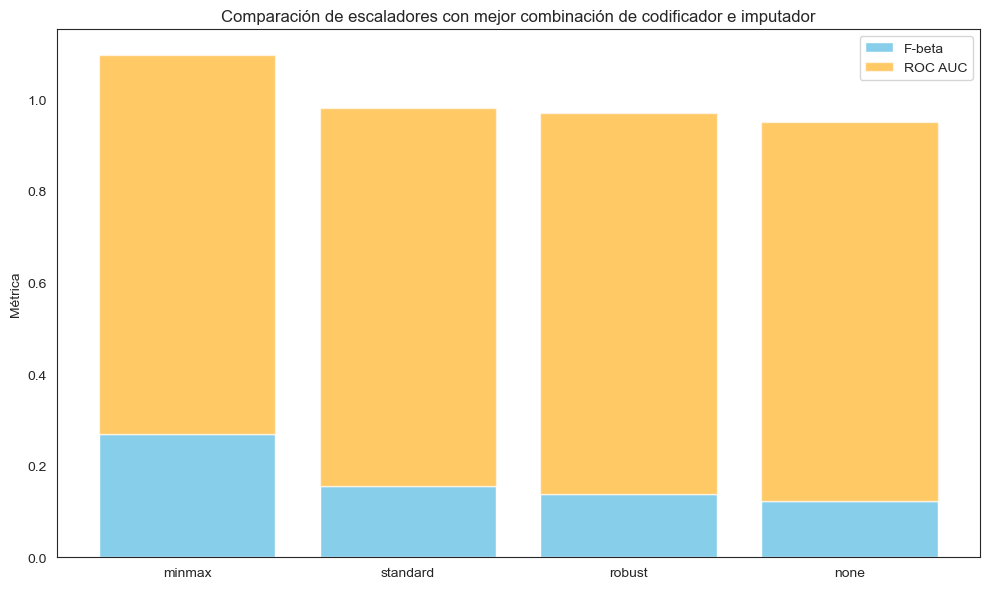

In [73]:
scaling_methods = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'none': FunctionTransformer()  # identidad
}

# DataFrame para guardar resultados
scaler_results = pd.DataFrame(columns=[
    'scaler', 'fbeta_score', 'roc_auc', 'execution_time'
])

# Dividir datos (por si no estaba hecho aún)
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

for scaler_name, scaler in scaling_methods.items():
    print(f"\nEvaluando con scaler: {scaler_name}")
    
    # Pipeline numérico
    if scaler_name != 'none':
        numeric_transformer = Pipeline([
            ('imputer', best_imputer),
            ('scaler', scaler)
        ])
    else:
        numeric_transformer = best_imputer  # solo imputación

    # Pipeline categórico (fijo)
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', best_encoder)
    ])
    
    # Preprocesamiento
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])
    
    # Pipeline completo
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('sampler', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])
    
    # Evaluar
    resultado = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)
    
    # Guardar resultado
    scaler_results = pd.concat([scaler_results, pd.DataFrame([{
        'scaler': scaler_name,
        'fbeta_score': resultado['fbeta_score'],
        'roc_auc': resultado['roc_auc'],
        'execution_time': resultado['execution_time']
    }])], ignore_index=True)

    print(f"Fb-score: {resultado['fbeta_score']:.4f}")
    print(f"ROC AUC: {resultado['roc_auc']:.4f}")
    print(f"Tiempo: {resultado['execution_time']:.2f} s")

# Ordenar resultados por fbeta_score
scaler_results = scaler_results.sort_values('fbeta_score', ascending=False).reset_index(drop=True)

print("\n--- Resultados por tipo de escalado ---")
print(scaler_results)

# Visualización opcional
plt.figure(figsize=(10, 6))
plt.bar(scaler_results['scaler'], scaler_results['fbeta_score'], color='skyblue', label='F-beta')
plt.bar(scaler_results['scaler'], scaler_results['roc_auc'], color='orange', alpha=0.6, label='ROC AUC', bottom=scaler_results['fbeta_score'])
plt.ylabel("Métrica")
plt.title("Comparación de escaladores con mejor combinación de codificador e imputador")
plt.legend()
plt.tight_layout()
plt.show()


In [74]:
df_copy = df.copy()

## 11. Selección de variables

Ahora que hemos creado nuevas variables, vamos a utilizar técnicas de selección para identificar las más relevantes para nuestro modelo. Utilizaremos métodos basados en filtros, wrappers y análisis de correlaciones.

### 11.1 Métodos basados en filtros

Aplicamos técnicas de selección de variables basadas en filtros para identificar las variables más relevantes para la predicción de adquisiciones. Utilizaremos los métodos SelectKBest con la puntuación f_classif para evaluar la importancia de cada variable.


Evaluando filtro: VarianceThreshold(th=0.001)...
F-beta: 0.2266 | ROC AUC: 0.7658 | Tiempo: 34.45s

Evaluando filtro: VarianceThreshold(th=0.01)...
F-beta: 0.2156 | ROC AUC: 0.7520 | Tiempo: 17.97s

Evaluando filtro: VarianceThreshold(th=0.05)...
F-beta: 0.2585 | ROC AUC: 0.7203 | Tiempo: 11.71s

Evaluando filtro: VarianceThreshold(th=0.1)...
F-beta: 0.2335 | ROC AUC: 0.7241 | Tiempo: 8.63s

Evaluando filtro: SelectKBest(f_classif,k=5)...
F-beta: 0.2915 | ROC AUC: 0.7825 | Tiempo: 25.73s

Evaluando filtro: SelectKBest(f_classif,k=10)...
F-beta: 0.3019 | ROC AUC: 0.7911 | Tiempo: 25.54s

Evaluando filtro: SelectKBest(f_classif,k=15)...
F-beta: 0.3193 | ROC AUC: 0.8073 | Tiempo: 24.51s

Evaluando filtro: SelectKBest(f_classif,k=20)...
F-beta: 0.3166 | ROC AUC: 0.8087 | Tiempo: 24.76s

Evaluando filtro: SelectKBest(chi2,k=5)...
Error evaluando SelectKBest(chi2,k=5): Input X must be non-negative.

Evaluando filtro: SelectKBest(chi2,k=10)...
Error evaluando SelectKBest(chi2,k=10): Input X 

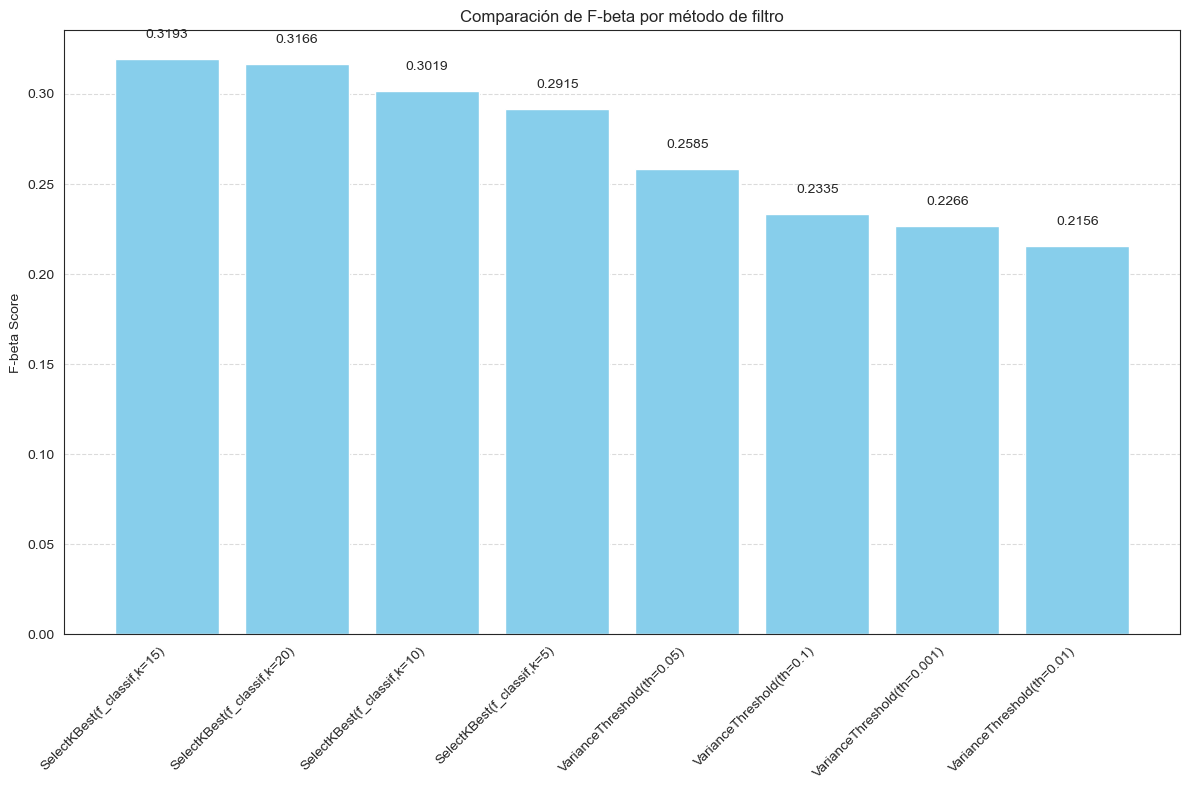

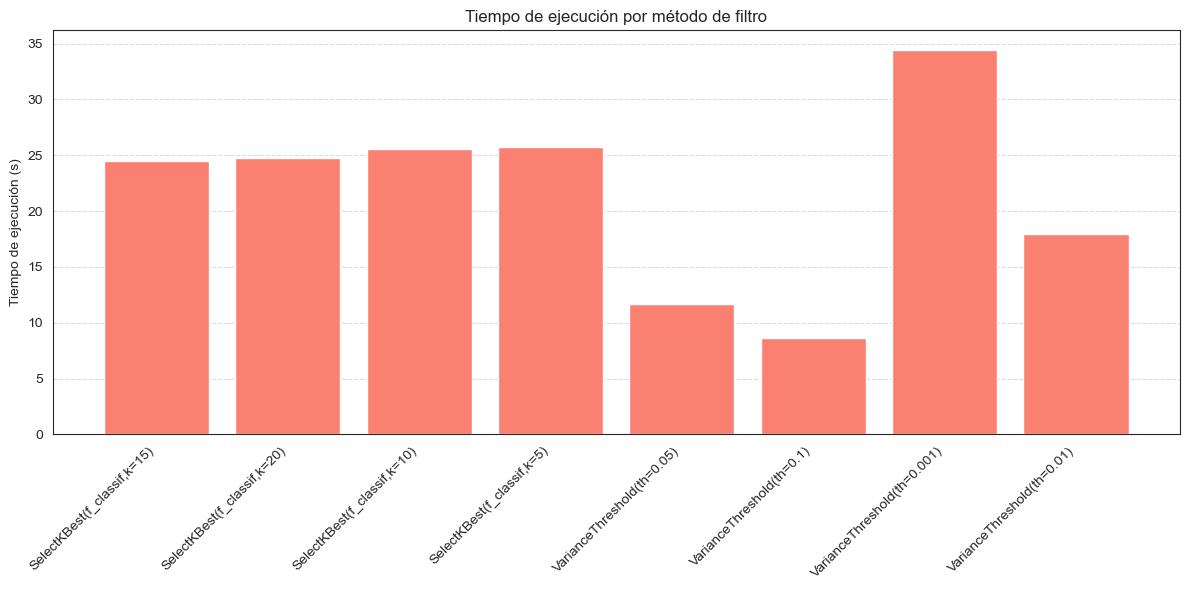

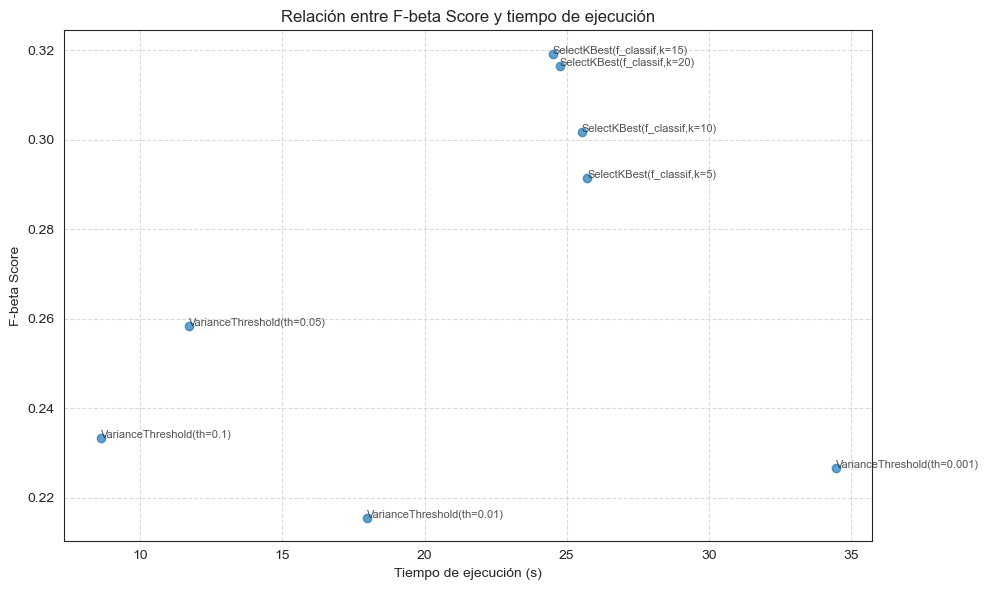

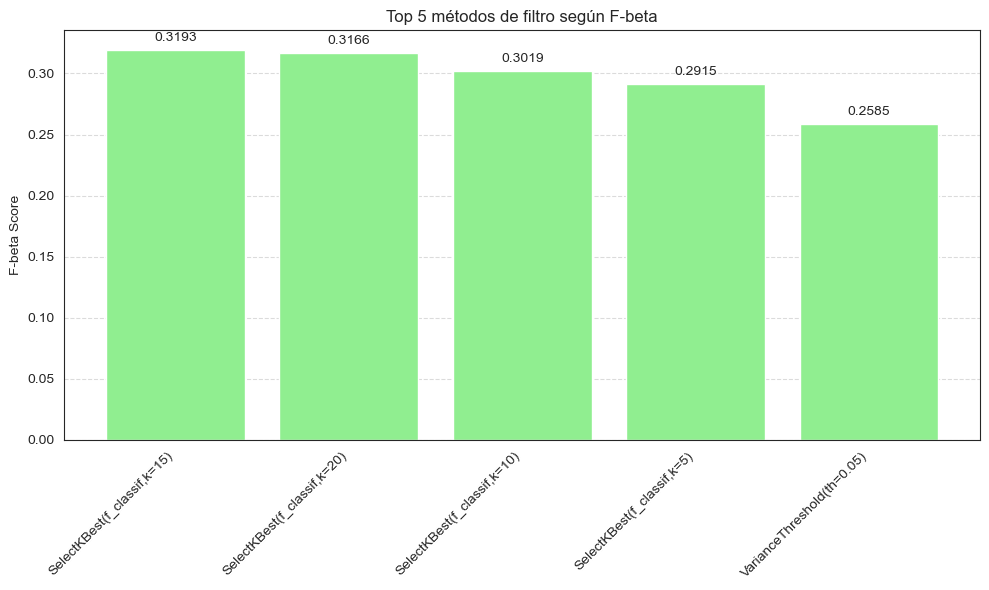

In [75]:
# División de datos (debes tener definidas X, y, num_cols, cat_cols antes de ejecutar)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Métodos de filtro a comparar con varios valores de parámetros
filter_methods = {
    # Varios umbrales para VarianceThreshold
    'VarianceThreshold(th=0.001)': VarianceThreshold(threshold=0.001),
    'VarianceThreshold(th=0.01)': VarianceThreshold(threshold=0.01),
    'VarianceThreshold(th=0.05)': VarianceThreshold(threshold=0.05),
    'VarianceThreshold(th=0.1)': VarianceThreshold(threshold=0.1),
    
    # Varios valores de k para SelectKBest con f_classif
    'SelectKBest(f_classif,k=5)': SelectKBest(f_classif, k=5),
    'SelectKBest(f_classif,k=10)': SelectKBest(f_classif, k=10),
    'SelectKBest(f_classif,k=15)': SelectKBest(f_classif, k=15),
    'SelectKBest(f_classif,k=20)': SelectKBest(f_classif, k=20),
    
    # Varios valores de k para SelectKBest con chi2
    'SelectKBest(chi2,k=5)': SelectKBest(chi2, k=5),
    'SelectKBest(chi2,k=10)': SelectKBest(chi2, k=10),
    'SelectKBest(chi2,k=15)': SelectKBest(chi2, k=15),
    'SelectKBest(chi2,k=20)': SelectKBest(chi2, k=20)
}

# Configuramos el preprocesador estándar
standard_preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', best_imputer),
        ('scaler', best_scaler)
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', best_encoder)
    ]), cat_cols)
], remainder='drop')

# Preprocesador específico para chi2 (valores no negativos)
chi2_preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', best_imputer),
        ('scaler', RobustScaler())  # Aseguramos valores no negativos para chi2
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', best_encoder)
    ]), cat_cols)
], remainder='drop')

# Clasificador base
clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# DataFrame para resultados
results = pd.DataFrame(columns=['filter', 'fbeta_score', 'roc_auc', 'execution_time'])

# Evaluación de cada método
for name, selector in filter_methods.items():
    print(f"\nEvaluando filtro: {name}...")
    
    # Elegimos el preprocesador adecuado según el método
    if 'chi2' in name:
        current_preprocessor = chi2_preprocessor
    else:
        current_preprocessor = standard_preprocessor
    
    # Configurar pipeline con conversión a denso
    pipeline = ImbPipeline(steps=[
        ('preprocessor', current_preprocessor),
        ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x)),
        ('selector', selector),
        ('sampler', SMOTE(random_state=42)),
        ('clf', clf)
    ])
    
    try:
        start = time()
        score = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)
        elapsed = time() - start
        
        new_result = pd.DataFrame([{
            'filter': name,
            'fbeta_score': score['fbeta_score'],
            'roc_auc': score['roc_auc'],
            'execution_time': elapsed
        }])
        
        results = pd.concat([results, new_result], ignore_index=True)
        print(f"F-beta: {score['fbeta_score']:.4f} | ROC AUC: {score['roc_auc']:.4f} | Tiempo: {elapsed:.2f}s")
    except Exception as e:
        print(f"Error evaluando {name}: {e}")

# Si no hay resultados, informamos al usuario
if results.empty:
    print("\nNo se pudo evaluar ningún método de filtro correctamente. Revise los errores anteriores.")
else:
    # Localiza la fila con mayor F-beta
    best_scaler_row = scaler_results.loc[scaler_results['fbeta_score'].idxmax()]
    # Imprime el nombre del scaler y sus métricas
    print("\n--- Resultados SIN filtros ---")
    print(f"  – F-beta:  {best_scaler_row['fbeta_score']:.4f}")
    print(f"  – ROC AUC: {best_scaler_row['roc_auc']:.4f}")
    # Ordenar resultados
    results = results.sort_values('fbeta_score', ascending=False).reset_index(drop=True)
    print("\n--- Resultados de filtros ---")
    print(results)

    # Visualización de los mejores resultados
    plt.figure(figsize=(12, 8))
    bars = plt.bar(results['filter'], results['fbeta_score'], color='skyblue')
    plt.ylabel('F-beta Score')
    plt.title('Comparación de F-beta por método de filtro')
    plt.xticks(rotation=45, ha='right')
    
    # Añadir etiquetas de valor en las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Visualización de tiempo de ejecución
    plt.figure(figsize=(12, 6))
    plt.bar(results['filter'], results['execution_time'], color='salmon')
    plt.ylabel('Tiempo de ejecución (s)')
    plt.title('Tiempo de ejecución por método de filtro')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Gráfico de dispersión f-beta vs tiempo
    plt.figure(figsize=(10, 6))
    plt.scatter(results['execution_time'], results['fbeta_score'], alpha=0.7)
    
    # Añadir etiquetas a los puntos
    for i, txt in enumerate(results['filter']):
        plt.annotate(txt, (results['execution_time'].iloc[i], results['fbeta_score'].iloc[i]),
                    fontsize=8, alpha=0.8)

    plt.xlabel('Tiempo de ejecución (s)')
    plt.ylabel('F-beta Score')
    plt.title('Relación entre F-beta Score y tiempo de ejecución')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Visualizamos los mejores 5 métodos
    top_5 = results.head(5)
    plt.figure(figsize=(10, 6))
    bars = plt.bar(top_5['filter'], top_5['fbeta_score'], color='lightgreen')
    plt.ylabel('F-beta Score')
    plt.title('Top 5 métodos de filtro según F-beta')
    plt.xticks(rotation=45, ha='right')
    
    # Añadir etiquetas de valor en las barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                 f'{height:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [76]:
# 1. Asegúrate de usar el preprocesador correcto
preprocessor = standard_preprocessor
#imprimir numero de variables en X
print(f"X tiene {X.shape[1]} variables después del preprocesamiento.")
# 2. Crea el pipeline solo hasta el filtro (sin SMOTE ni clasificador)
from sklearn.pipeline import Pipeline

pipeline_vt = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x)),
    ('selector', SelectKBest(f_classif,k=15))
])

# 3. Ajusta el pipeline (solo hasta el filtro) con los datos de entrenamiento
pipeline_vt.fit(X_train, y_train)

# 4. Obtiene las columnas originales después del preprocesador
# Obtén los nombres de las columnas después del preprocesamiento (puede ser complicado si usas OneHotEncoder)
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    # Si usas versiones viejas de sklearn:
    from itertools import chain
    num_names = num_cols
    cat_names = []
    if hasattr(best_encoder, 'get_feature_names_out'):
        cat_names = best_encoder.get_feature_names_out(cat_cols)
    elif hasattr(best_encoder, 'get_feature_names'):
        cat_names = best_encoder.get_feature_names(cat_cols)
    feature_names = list(chain(num_names, cat_names))

# 5. Obtiene la máscara booleana de las columnas seleccionadas por VarianceThreshold
mask = pipeline_vt.named_steps['selector'].get_support()

# 6. Saca los nombres de las columnas seleccionadas
selected_features = feature_names[mask] if hasattr(feature_names, '__getitem__') else [f for f, m in zip(feature_names, mask) if m]

print("Variables seleccionadas por VarianceThreshold(th=0.001):")
for feat in selected_features:
    print(feat)

X tiene 42 variables después del preprocesamiento.
Variables seleccionadas por VarianceThreshold(th=0.001):
num__funding_total_usd
num__venture
num__round_B
num__round_C
num__founded_at_ordinal
num__founded_month_ordinal
num__first_funding_at_ordinal
num__last_funding_at_ordinal
num__avg_raised_amount_usd
cat__country_code_USA
cat__state_code_CA
cat__state_code_missing
cat__region_SF Bay Area
cat__category_total_high
cat__category_total_medium


Tiene sentido las variables que escogemos, ya que son varias de las que le hemos dado especial importancia durante el analisis

### 9.2 Métodos basados en wrappers

Ahora aplicaremos métodos basados en wrappers para seleccionar variables, específicamente la técnica Recursive Feature Elimination (RFE) que elimina iterativamente las variables menos importantes.

In [77]:
%pip install mlxtend
%pip install Boruta


Note: you may need to restart the kernel to use updated packages.


Evaluando RFE (LR, k=15)...
Done in 6.57s | fb: 0.270 | features: 15
Evaluando RFECV (LR, min=3)...
Done in 16.75s | fb: 0.340 | features: 5
Evaluando SFS (LR, k=15)...
Done in 58.69s | fb: 0.208 | features: 15
Evaluando Boruta (RF)...
Error en Boruta (RF): Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.
             wrapper  f1_score   roc_auc       time n_features
0  RFECV (LR, min=3)  0.339623  0.781250  16.752681          5
1     RFE (LR, k=15)  0.270270  0.745929   6.574659         15
2     SFS (LR, k=15)  0.208333  0.724258  58.694956         15


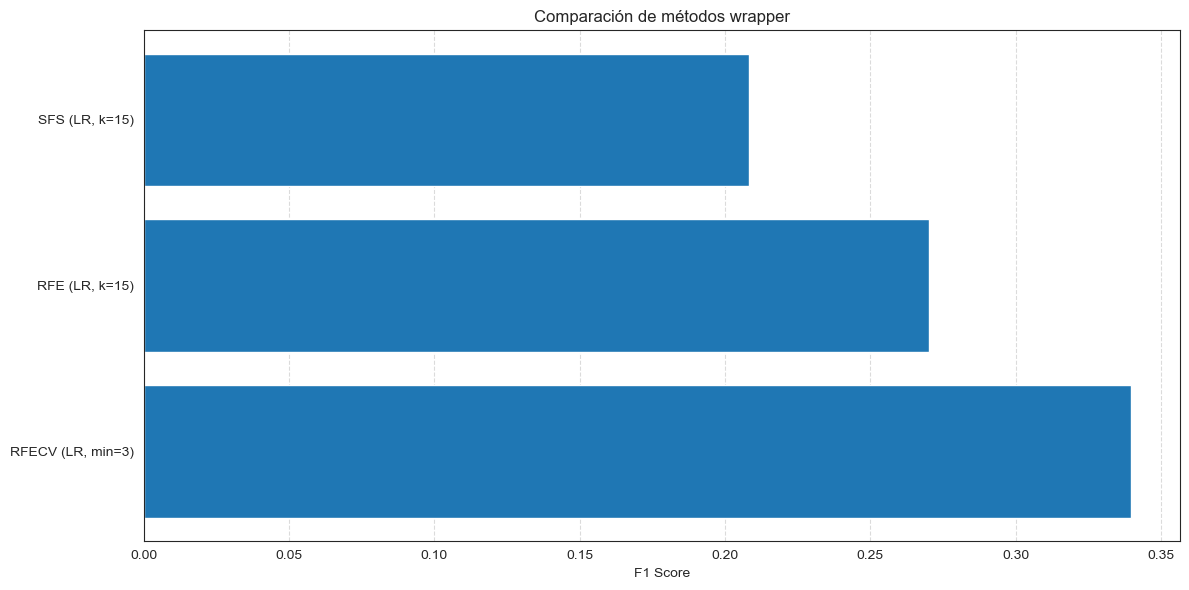

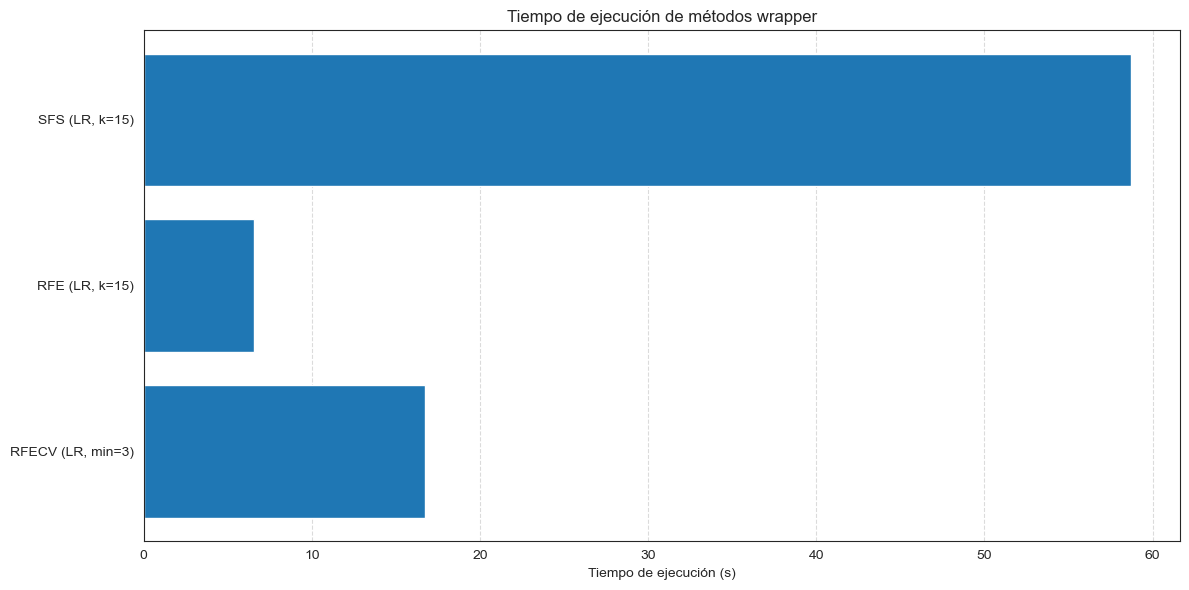

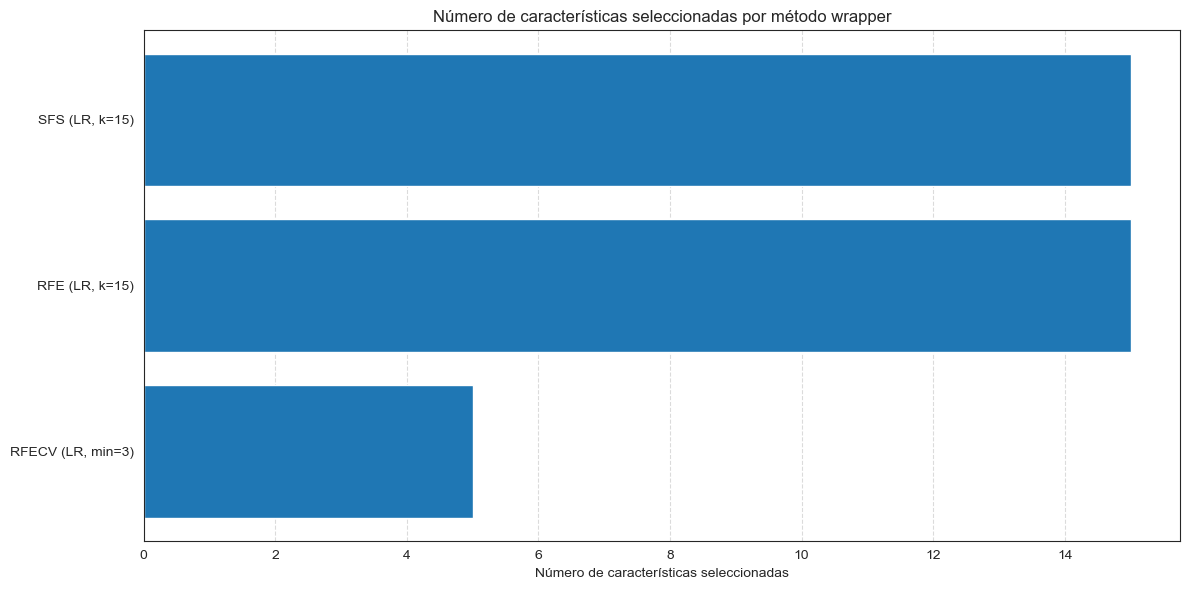

In [78]:
#escogemos 15 variables basandonos en el resultado de la selección anterior
from mlxtend.feature_selection import SequentialFeatureSelector as SFS, SequentialFeatureSelector as SBS
from boruta import BorutaPy

# 0) Transformar columnas datetime a atributos numéricos y quitar las originales
date_cols = ['founded_at', 'first_funding_at', 'last_funding_at', 'founded_year', 'founded_month']
for c in date_cols:
    if c in X.columns:
        X[c] = pd.to_datetime(X[c], errors='coerce')
        # Extraer año y mes por separado (si te interesa)
        X[c + '_year']  = X[c].dt.year
        X[c + '_month'] = X[c].dt.month
        # Y eliminar la original
        X.drop(columns=[c], inplace=True)

# 1) Ahora sí redefinir num_cols y cat_cols:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# 2) Reconstruir tu preprocesador
numeric_pipeline = Pipeline([
    ('imputer', best_imputer),
    ('scaler',  best_scaler),
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', best_encoder),
])
standard_preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols),
], remainder='drop')
# --- Configuración base y datos ---
sample_size = 250
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

if len(X_train_full) > sample_size:
    X_train = X_train_full.sample(n=sample_size, random_state=42)
    y_train = y_train_full.loc[X_train.index]
else:
    X_train = X_train_full.copy()
    y_train = y_train_full.copy()

if len(X_val_full) > sample_size:
    X_val = X_val_full.sample(n=sample_size, random_state=42)
    y_val = y_val_full.loc[X_val.index]
else:
    X_val = X_val_full.copy()
    y_val = y_val_full.copy()


# --- Modelos base ---
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42, n_jobs=-1)

# --- Métodos wrapper ---
wrappers = {
    'RFE (LR, k=15)': RFE(estimator=lr, n_features_to_select=15),
    'RFECV (LR, min=3)': RFECV(estimator=lr, cv=3, scoring='f1', min_features_to_select=3),
    'SFS (LR, k=15)': SFS(lr, k_features=15, forward=True, floating=False, scoring='f1', cv=3, n_jobs=-1),
    'Boruta (RF)': BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
    # 'Genético (RF)': ... # Ver abajo
}



def get_selected_features_count(pipeline, X, y):
    sel = pipeline.named_steps['sel']
    X_proc = pipeline.named_steps['pre'].transform(X)
    sel.fit(X_proc, y)
    if hasattr(sel, 'get_support'):
        return sel.get_support().sum()
    elif hasattr(sel, 'support_'):
        return sel.support_.sum()
    elif hasattr(sel, 'k_feature_idx_'):
        return len(sel.k_feature_idx_)
    else:
        return None

results = pd.DataFrame(columns=['wrapper', 'f1_score', 'roc_auc', 'time', 'n_features'])

for name, selector in wrappers.items():
    print(f"Evaluando {name}...")
    pipeline = ImbPipeline(steps=[
        ('pre', standard_preprocessor),
        ('sel', selector),
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))
    ])
    start = time()
    try:
        scores = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)
        elapsed = time() - start
        n_feats = get_selected_features_count(pipeline, X_train, y_train)
        new_result = pd.DataFrame([{
            'wrapper': name,
            'f1_score': scores['fbeta_score'],
            'roc_auc':  scores['roc_auc'],
            'time':     scores['execution_time'],
            'n_features': n_feats
        }])
        results = pd.concat([results, new_result], ignore_index=True)
        print(f"Done in {elapsed:.2f}s | fb: {scores['fbeta_score']:.3f} | features: {n_feats}")
    except Exception as e:
        print(f"Error en {name}: {e}")

# Si quieres incluir un método genético, deberás instalar sklearn-genetic-opt e implementarlo aparte.
# Ejemplo (opcional, requiere instalación previa):
# from geneticalgorithm import geneticalgorithm as ga
# from sklearn_genetic import GASearchCV

# Mostrar resultados ordenados
results = results.sort_values('f1_score', ascending=False).reset_index(drop=True)
print(results)

# Visualización
plt.figure(figsize=(12, 6))
plt.barh(results['wrapper'], results['f1_score'])
plt.xlabel('F1 Score')
plt.title('Comparación de métodos wrapper')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(results['wrapper'], results['time'])
plt.xlabel('Tiempo de ejecución (s)')
plt.title('Tiempo de ejecución de métodos wrapper')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(results['wrapper'], results['n_features'])
plt.xlabel('Número de características seleccionadas')
plt.title('Número de características seleccionadas por método wrapper')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Vemos que obtenemos buenos resultados en rfe, pero decidimos priorizar el uso de filtros debido a la eficiencia computacional

## 10. Detección de ruido

In [79]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [80]:
# (Re)definimos noise_tools en esta celda
noise_tools = {
    'TomekLinks (all)': TomekLinks(sampling_strategy='all'),
    'ENN (mode)'       : EditedNearestNeighbours(sampling_strategy='all', kind_sel='mode', n_neighbors=3),
    'AllKNN (mode)'    : AllKNN(sampling_strategy='all', kind_sel='mode', n_neighbors=3)
}
# Localiza la fila con mayor F-beta
best_scaler_row = scaler_results.loc[scaler_results['fbeta_score'].idxmax()]
# Imprime el nombre del scaler y sus métricas
print("\n--- Resultados SIN detección de ruido ---")
print(f"  – F-beta:  {best_scaler_row['fbeta_score']:.4f}")
print(f"  – ROC AUC: {best_scaler_row['roc_auc']:.4f}")
rows = []
for name, noise_sampler in noise_tools.items():
    print(f"\n--- {name} ---")
    # 1) detectamos cuántos quedan tras el ruido, sobre datos ya preprocesados
    X_proc = standard_preprocessor.fit_transform(X_train)
    if hasattr(X_proc, "toarray"):
        X_proc = X_proc.toarray()
    X_no, y_no = noise_sampler.fit_resample(X_proc, y_train)
    removed = len(y_train) - len(y_no)

    # 2) si se cargó sólo una clase, saltamos
    counts = Counter(y_no)
    if len(counts) < 2:
        print(f"  ⚠️ Sólo queda la clase {next(iter(counts))}. Método skippeado.")
        rows.append({
            "method":    name + " (skipped)",
            "f1_score":  np.nan,
            "roc_auc":   np.nan,
            "time":      np.nan,
            "n_removed": removed
        })
        continue

    # 3) elegimos sampler de equilibrio (SMOTE o ROS si queda sólo 1 minoritario)
    minority_count = min(counts.values())
    if minority_count < 2:
        sampler = RandomOverSampler(sampling_strategy="not majority", random_state=42)
        sampler_name = "ROS"
    else:
        k = min(5, minority_count - 1)
        sampler = SMOTE(random_state=42, k_neighbors=k)
        sampler_name = f"SMOTE(k={k})"

    # 4) construimos el pipeline completo y usamos evaluar_pipeline
    pipe = ImbPipeline(steps=[
        ('pre',       standard_preprocessor),
        ('to_dense',  FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x)),
        ('noise',     noise_sampler),
        ('balance',   sampler),
        ('clf',       RandomForestClassifier(
                          random_state=42,
                          n_jobs=-1,
                          class_weight='balanced'
                      ))
    ])

    scores = evaluar_pipeline(X_train, y_train, X_val, y_val, pipe)
    rows.append({
        "method":    f"{name} + {sampler_name}",
        "f1_score":  scores['fbeta_score'],
        "roc_auc":   scores['roc_auc'],
        "time":      scores['execution_time'],
        "n_removed": removed
    })
    print(f"  ► {sampler_name} | F1={scores['fbeta_score']:.3f} | "
          f"AUC={scores['roc_auc']:.3f} | removed={removed} | "
          f"time={scores['execution_time']:.2f}s")

# 5) volcamos resultados a DataFrame
noise_results = pd.DataFrame(rows).sort_values("f1_score", ascending=False).reset_index(drop=True)
print("\n—— Resultados ——")
print(noise_results)



--- Resultados SIN detección de ruido ---
  – F-beta:  0.2703
  – ROC AUC: 0.8275

--- TomekLinks (all) ---
  ► SMOTE(k=5) | F1=0.000 | AUC=0.767 | removed=12 | time=0.45s

--- ENN (mode) ---
  ⚠️ Sólo queda la clase 0. Método skippeado.

--- AllKNN (mode) ---
  ⚠️ Sólo queda la clase 0. Método skippeado.

—— Resultados ——
                          method  f1_score   roc_auc      time  n_removed
0  TomekLinks (all) + SMOTE(k=5)       0.0  0.767122  0.445659         12
1           ENN (mode) (skipped)       NaN       NaN       NaN         21
2        AllKNN (mode) (skipped)       NaN       NaN       NaN         37


Parece ser que la eliminación de ruido tampoco mejora nuestros valores de `f-beta score` y `AUC`, por lo que tampoco lo usaremos. Nota: AllKNN se skipea porque en nuestro conjunto submuestreado queda tan poca minoría que acaba eliminándola por completo, quedando sólo la clase mayoritaria.

## 11. Efecto de uso de árboles de decisión

In [81]:
%pip install xgboost
%pip install catboost
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



Buscando hiperparámetros para Random Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores hiperparámetros: {'clf__max_depth': 10, 'clf__n_estimators': 100}

Buscando hiperparámetros para XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores hiperparámetros: {'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 120}

Buscando hiperparámetros para CatBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores hiperparámetros: {'clf__depth': 6, 'clf__iterations': 200, 'clf__learning_rate': 0.05}

Evaluando Random Forest...
Fb-score: 0.3632 | ROC AUC: 0.8381 | Tiempo: 21.93s

Evaluando XGBoost...
Fb-score: 0.3586 | ROC AUC: 0.8370 | Tiempo: 1.11s

Evaluando CatBoost...
Fb-score: 0.3232 | ROC AUC: 0.8433 | Tiempo: 4.06s

--- Resultados finales ---
           model  fbeta_score   roc_auc  execution_time
0  Random Forest     0.363173  0.838106       21.928710
1        XGBoost     0.358648  0.837039        1.1

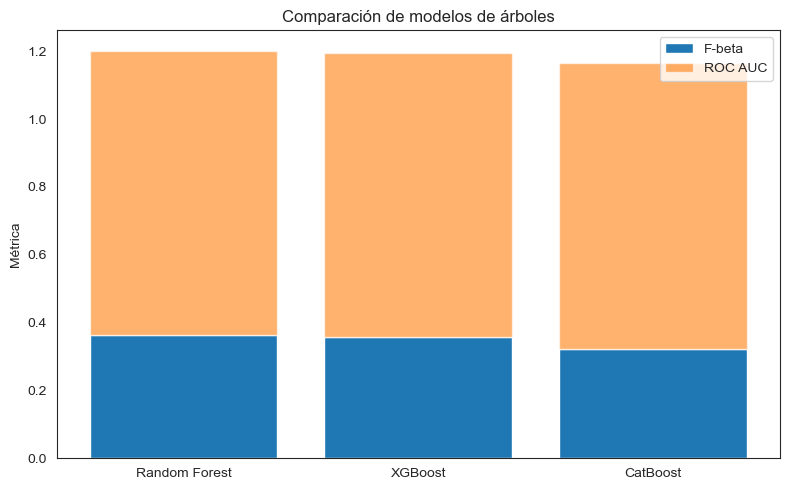

In [82]:
from sklearn.model_selection import GridSearchCV



# 1) División de datos
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 2) Preprocesador
numeric_pipeline = Pipeline([
    ('imputer', best_imputer),      
    ('scaler', best_scaler)        
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Si tu encoder lo necesita
    ('encoder', best_encoder)     
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
], remainder='drop')

# 3) Espacios de búsqueda pequeños
param_grid_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [5, 10],
}

param_grid_xgb = {
    'clf__n_estimators': [60, 120],
    'clf__max_depth': [5, 8],
    'clf__learning_rate': [0.05, 0.1],
}

param_grid_cat = {
    'clf__iterations': [200, 400],
    'clf__depth': [4, 6],
    'clf__learning_rate': [0.05, 0.1],
}

# 4) Pipelines
pipeline_rf = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('filter', SelectKBest(f_classif, k=15)),
    ('clf', RandomForestClassifier(random_state=42))
])

pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('filter', SelectKBest(f_classif, k=15)),
    ('clf', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

pipeline_cat = ImbPipeline([
    ('preprocessor', preprocessor),
    ('sampler', SMOTE(random_state=42)),
    ('filter', SelectKBest(f_classif, k=15)),
    ('clf', CatBoostClassifier(random_state=42, verbose=0))
])

# 5) GridSearch para cada modelo
searchers = [
    ('Random Forest', pipeline_rf, param_grid_rf),
    ('XGBoost', pipeline_xgb, param_grid_xgb),
    ('CatBoost', pipeline_cat, param_grid_cat)
]

best_models = {}
for name, pipe, param_grid in searchers:
    print(f"\nBuscando hiperparámetros para {name}...")
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring='f1',
        cv=3,
        verbose=2,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    print("Mejores hiperparámetros:", grid.best_params_)
    best_models[name] = grid.best_estimator_


results = pd.DataFrame(columns=['model', 'fbeta_score', 'roc_auc', 'execution_time'])

for name, pipeline in best_models.items():
    print(f"\nEvaluando {name}...")
    start = time()
    score = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)
    elapsed = time() - start

    results = pd.concat([
        results,
        pd.DataFrame([{
            'model': name,
            'fbeta_score': score['fbeta_score'],
            'roc_auc': score['roc_auc'],
            'execution_time': elapsed
        }])
    ], ignore_index=True)
    print(f"Fb-score: {score['fbeta_score']:.4f} | ROC AUC: {score['roc_auc']:.4f} | Tiempo: {elapsed:.2f}s")

# 7) Ordenar y mostrar resultados
results = results.sort_values('fbeta_score', ascending=False).reset_index(drop=True)
print("\n--- Resultados finales ---")
print(results)

# 8) Visualización
plt.figure(figsize=(8, 5))
plt.bar(results['model'], results['fbeta_score'], label='F-beta')
plt.bar(results['model'], results['roc_auc'],
        bottom=results['fbeta_score'], alpha=0.6, label='ROC AUC')
plt.ylabel('Métrica')
plt.title('Comparación de modelos de árboles')
plt.legend()
plt.tight_layout()
plt.show()

A continuación realizamos lo mismo pero probando con diferentes umbrales y diferentes técnicas de muestreo.

## 12. Muestreo de datos para problemas no balanceados

### 12.1 Sin cambiar umbrales


Evaluando random_forest + Ninguno
  F-beta: 0.0638 | ROC AUC: 0.8418 | Tiempo: 5.47s

Evaluando xgboost + Ninguno
  F-beta: 0.0386 | ROC AUC: 0.8469 | Tiempo: 0.82s

Evaluando catboost + Ninguno
  F-beta: 0.0519 | ROC AUC: 0.8484 | Tiempo: 2.68s

Evaluando random_forest + SMOTE
  F-beta: 0.3687 | ROC AUC: 0.8386 | Tiempo: 12.60s

Evaluando xgboost + SMOTE
  F-beta: 0.3586 | ROC AUC: 0.8370 | Tiempo: 1.39s

Evaluando catboost + SMOTE
  F-beta: 0.3423 | ROC AUC: 0.8424 | Tiempo: 4.14s

Evaluando random_forest + RandomOver
  F-beta: 0.3366 | ROC AUC: 0.8434 | Tiempo: 11.62s

Evaluando xgboost + RandomOver
  F-beta: 0.3144 | ROC AUC: 0.8484 | Tiempo: 1.01s

Evaluando catboost + RandomOver
  F-beta: 0.3172 | ROC AUC: 0.8542 | Tiempo: 3.85s

Evaluando random_forest + RandomUnder
  F-beta: 0.3019 | ROC AUC: 0.8425 | Tiempo: 1.73s

Evaluando xgboost + RandomUnder
  F-beta: 0.3044 | ROC AUC: 0.8483 | Tiempo: 0.75s

Evaluando catboost + RandomUnder
  F-beta: 0.3061 | ROC AUC: 0.8530 | Tiempo: 1

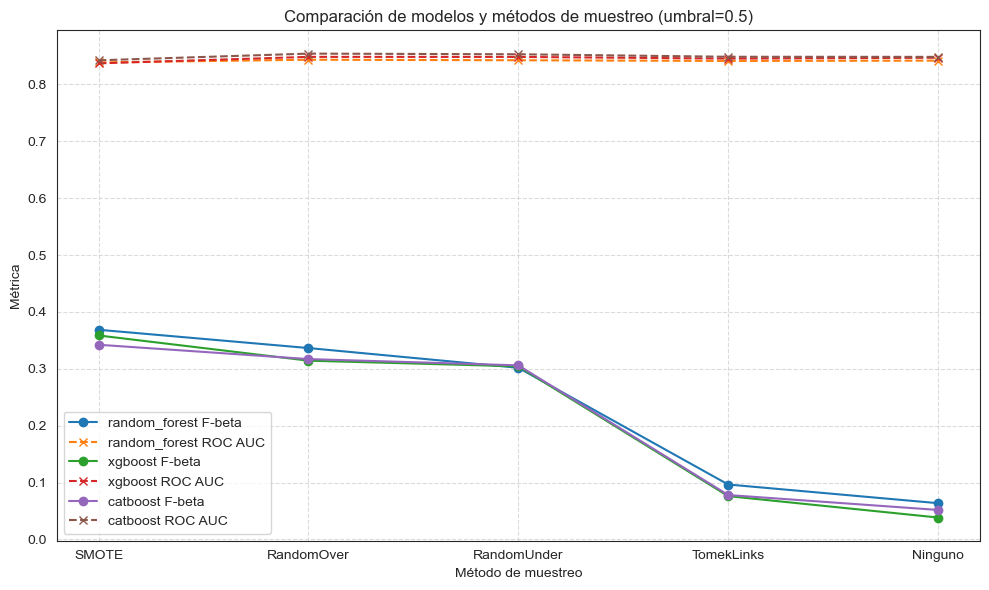

In [83]:
# 1) División de datos
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 2) Modelos
models = {
    'random_forest': RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        random_state=42
    ),
    'xgboost': XGBClassifier(
        n_estimators=120,
        max_depth=5,
        learning_rate=0.05,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    'catboost': CatBoostClassifier(
        iterations=200,
        depth=4,
        learning_rate=0.05,
        random_state=42,
        verbose=0
    ),
}

# 3) Métodos de muestreo
samplers = {
    'Ninguno': None,
    'SMOTE': SMOTE(random_state=42),
    'RandomOver': RandomOverSampler(random_state=42),
    'RandomUnder': RandomUnderSampler(random_state=42),
    'TomekLinks': TomekLinks(sampling_strategy='auto')
}

# 4) DataFrame para resultados
results = pd.DataFrame(columns=[
    'model', 'sampler', 'fbeta_score', 'roc_auc', 'execution_time'
])

# 5) Bucle de evaluación
for sampler_name, sampler in samplers.items():
    for model_name, clf in models.items():
        print(f"\nEvaluando {model_name} + {sampler_name}")
        
        # 2) Preprocesador
        numeric_pipeline = Pipeline([
            ('imputer', best_imputer),      
            ('scaler', best_scaler)        
        ])

        categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Si tu encoder lo necesita
            ('encoder', best_encoder)     
        ])

        preprocessor = ColumnTransformer([
            ('num', numeric_pipeline, num_cols),
            ('cat', categorical_pipeline, cat_cols)
        ], remainder='drop')
        
        steps = [('preprocessor', preprocessor)]
        if sampler is not None:
            steps.append(('sampler', sampler))
        steps.append(('filter', SelectKBest(f_classif, k=15)))
        steps.append(('clf', clf))
        
        pipeline = ImbPipeline(steps)
        
        start = time()
        score = evaluar_pipeline(X_train, y_train, X_val, y_val, pipeline)
        elapsed = time() - start
        
        # Añadir fila
        new_row = pd.DataFrame([{
            'model': model_name,
            'sampler': sampler_name,
            'fbeta_score': score['fbeta_score'],
            'roc_auc': score['roc_auc'],
            'execution_time': elapsed
        }])
        results = pd.concat([results, new_row], ignore_index=True)
        
        print(f"  F-beta: {score['fbeta_score']:.4f} | "
              f"ROC AUC: {score['roc_auc']:.4f} | "
              f"Tiempo: {elapsed:.2f}s")

# 6) Ordenar y mostrar resultados
results = results.sort_values('fbeta_score', ascending=False).reset_index(drop=True)
print("\n--- Resultados finales (umbral=0.5) ---")
print(results)

# 7) Visualización conjunta
plt.figure(figsize=(10, 6))
for model_name in results['model'].unique():
    subset = results[results['model'] == model_name]
    plt.plot(subset['sampler'], subset['fbeta_score'],
             marker='o', label=f'{model_name} F-beta')
    plt.plot(subset['sampler'], subset['roc_auc'],
             marker='x', linestyle='--', label=f'{model_name} ROC AUC')

plt.xlabel('Método de muestreo')
plt.ylabel('Métrica')
plt.title('Comparación de modelos y métodos de muestreo (umbral=0.5)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## 13. Cambio de umbrales de clasificación


Modelo: random_forest  |  Muestreo: Ninguno
  F-beta: 0.3719 | ROC AUC: 0.8423 | Umbral: 0.20 | Tiempo: 11.39s

Modelo: xgboost  |  Muestreo: Ninguno
  F-beta: 0.3794 | ROC AUC: 0.8471 | Umbral: 0.15 | Tiempo: 0.65s

Modelo: catboost  |  Muestreo: Ninguno
  F-beta: 0.3860 | ROC AUC: 0.8484 | Umbral: 0.15 | Tiempo: 2.88s

Modelo: random_forest  |  Muestreo: SMOTE
  F-beta: 0.3725 | ROC AUC: 0.8381 | Umbral: 0.60 | Tiempo: 24.70s

Modelo: xgboost  |  Muestreo: SMOTE
  F-beta: 0.3597 | ROC AUC: 0.8343 | Umbral: 0.60 | Tiempo: 1.08s

Modelo: catboost  |  Muestreo: SMOTE
  F-beta: 0.3742 | ROC AUC: 0.8424 | Umbral: 0.35 | Tiempo: 4.73s

Modelo: random_forest  |  Muestreo: RandomOver
  F-beta: 0.3862 | ROC AUC: 0.8445 | Umbral: 0.70 | Tiempo: 24.06s

Modelo: xgboost  |  Muestreo: RandomOver
  F-beta: 0.3835 | ROC AUC: 0.8479 | Umbral: 0.70 | Tiempo: 0.81s

Modelo: catboost  |  Muestreo: RandomOver
  F-beta: 0.3851 | ROC AUC: 0.8542 | Umbral: 0.70 | Tiempo: 3.89s

Modelo: random_forest  |  M

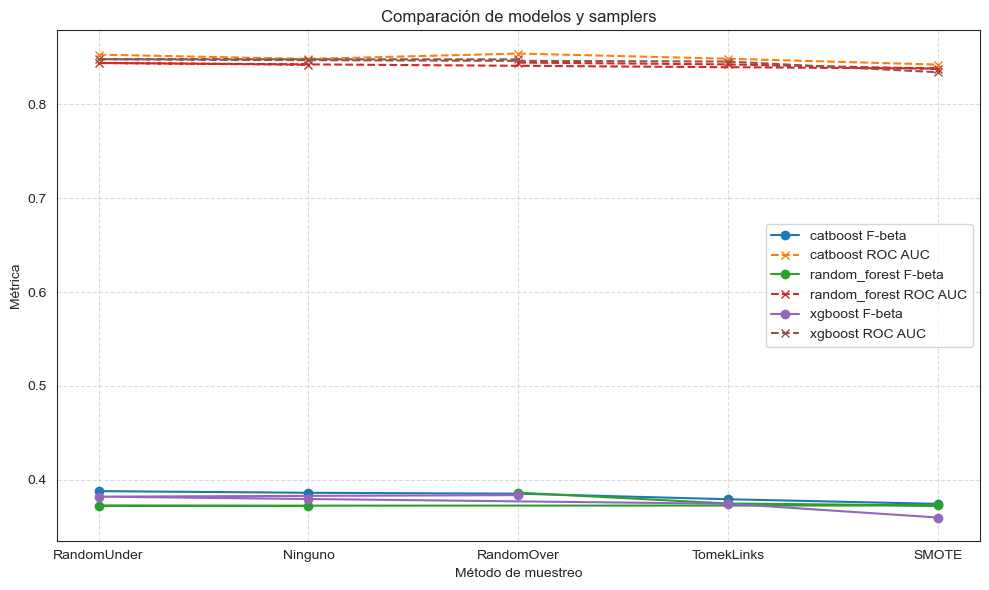

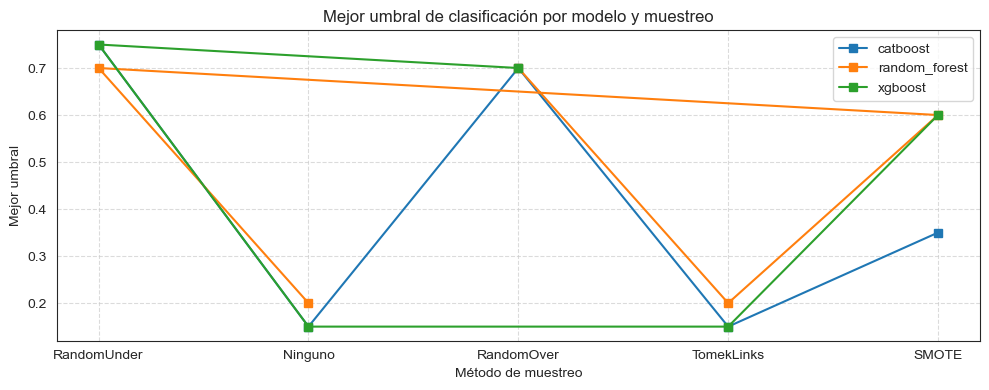

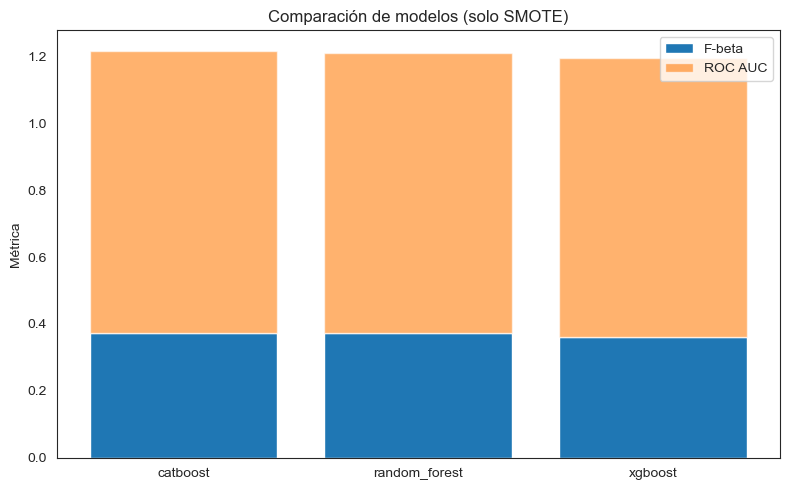

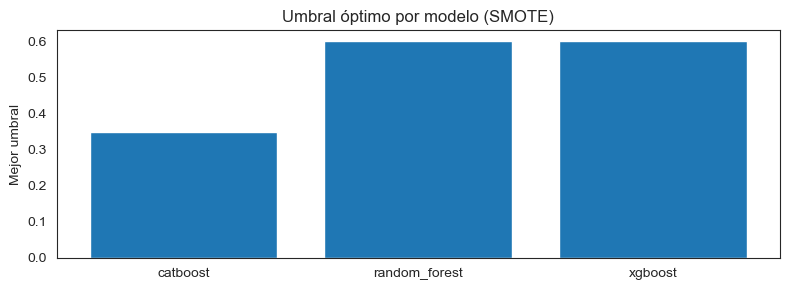

In [84]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
# función auxiliar para evaluar con cambio de umbral
def evaluar_pipeline_umbral(X_train, y_train, X_val, y_val, pipeline,
                            beta=1,
                            thresholds=np.arange(0.1, 0.91, 0.05)):
    pipeline.fit(X_train, y_train)
    y_proba = pipeline.predict_proba(X_val)[:, 1]
    best_result = {'fbeta_score': -np.inf, 'roc_auc': None, 'best_threshold': 0.5}
    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        try:
            fbeta = fbeta_score(y_val, y_pred, beta=beta)
            rocauc = roc_auc_score(y_val, y_proba)
        except Exception:
            continue
        if fbeta > best_result['fbeta_score']:
            best_result = {'fbeta_score': fbeta,
                           'roc_auc': rocauc,
                           'best_threshold': thr}
    return best_result

# 1) División de datos
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 2) Modelos
models = {
    'random_forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42
    ),
    'xgboost': XGBClassifier(
        n_estimators=60,
        max_depth=5,
        learning_rate=0.05,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    'catboost': CatBoostClassifier(
        iterations=200,
        depth=4,
        learning_rate=0.05,
        random_state=42,
        verbose=0
    ),
}

# 3) Métodos de muestreo
samplers = {
    'Ninguno':              None,
    'SMOTE':                SMOTE(random_state=42),
    'RandomOver':           RandomOverSampler(random_state=42),
    'RandomUnder':          RandomUnderSampler(random_state=42),
    'TomekLinks':           TomekLinks(sampling_strategy='auto')
}

# 4) DataFrame para resultados
results = pd.DataFrame(columns=[
    'model', 'sampler', 'fbeta_score', 'roc_auc', 'execution_time', 'best_threshold'
])

# 5) Bucle de evaluación
for sampler_name, sampler in samplers.items():
    for model_name, clf in models.items():
        print(f"\nModelo: {model_name}  |  Muestreo: {sampler_name}")
        numeric_pipeline = Pipeline([
            ('imputer', best_imputer),      
            ('scaler', best_scaler)        
        ])

        categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Si tu encoder lo necesita
            ('encoder', best_encoder)     
        ])

        preprocessor = ColumnTransformer([
            ('num', numeric_pipeline, num_cols),
            ('cat', categorical_pipeline, cat_cols)
        ], remainder='drop')
        steps = [('preprocessor', preprocessor)]
        if sampler is not None:
            steps.append(('sampler', sampler))
        steps.append(('filter', SelectKBest(f_classif, k=15)))
        steps.append(('clf', clf))
        pipeline = ImbPipeline(steps)

        start = time()
        score = evaluar_pipeline_umbral(
            X_train, y_train, X_val, y_val, pipeline
        )
        elapsed = time() - start

        new_row = pd.DataFrame([{
            'model':         model_name,
            'sampler':       sampler_name,
            'fbeta_score':   score['fbeta_score'],
            'roc_auc':       score['roc_auc'],
            'execution_time': elapsed,
            'best_threshold': score['best_threshold']
        }])
        results = pd.concat([results, new_row], ignore_index=True)

        print(f"  F-beta: {score['fbeta_score']:.4f} | "
              f"ROC AUC: {score['roc_auc']:.4f} | "
              f"Umbral: {score['best_threshold']:.2f} | "
              f"Tiempo: {elapsed:.2f}s")

# 6) Ordenar y mostrar resultados
results = results.sort_values('fbeta_score', ascending=False).reset_index(drop=True)
print("\n--- Resultados finales ---")
print(results)

# ————————————————
# 7a) Gráficas del segundo bloque (curvas vs sampler)
plt.figure(figsize=(10, 6))
for model_name in results['model'].unique():
    subset = results[results['model'] == model_name]
    plt.plot(subset['sampler'], subset['fbeta_score'],
             marker='o', label=f'{model_name} F-beta')
    plt.plot(subset['sampler'], subset['roc_auc'],
             marker='x', linestyle='--', label=f'{model_name} ROC AUC')

plt.xlabel('Método de muestreo')
plt.ylabel('Métrica')
plt.title('Comparación de modelos y samplers')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# 7c) Gráfica de umbral óptimo por modelo y sampler
plt.figure(figsize=(10, 4))
for model_name in results['model'].unique():
    subset = results[results['model'] == model_name]
    plt.plot(subset['sampler'], subset['best_threshold'],
             marker='s', linestyle='-',
             label=model_name)

plt.xlabel('Método de muestreo')
plt.ylabel('Mejor umbral')
plt.title('Mejor umbral de clasificación por modelo y muestreo')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# 7b) Gráficas del primer bloque (solo con SMOTE, barras apiladas)
smote_df = results[results['sampler'] == 'SMOTE']

plt.figure(figsize=(8, 5))
plt.bar(smote_df['model'], smote_df['fbeta_score'], label='F-beta')
plt.bar(smote_df['model'], smote_df['roc_auc'],
        bottom=smote_df['fbeta_score'], alpha=0.6, label='ROC AUC')
plt.ylabel('Métrica')
plt.title('Comparación de modelos (solo SMOTE)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.bar(smote_df['model'], smote_df['best_threshold'])
plt.ylabel('Mejor umbral')
plt.title('Umbral óptimo por modelo (SMOTE)')
plt.tight_layout()
plt.show()


Mejor modelo: catboost | Muestreo: RandomUnder
Variables seleccionadas por SelectKBest:
 - num__funding_total_usd
 - num__venture
 - num__founded_at_ordinal
 - num__founded_month_ordinal
 - num__first_funding_at_ordinal
 - num__last_funding_at_ordinal
 - num__founded_at_year
 - num__first_funding_at_year
 - num__last_funding_at_year
 - num__founded_month_year
 - cat__state_code_CA
 - cat__state_code_missing
 - cat__region_SF Bay Area
 - cat__category_total_high
 - cat__category_total_medium

Importancia de variables (Random Forest/XGBoost/CatBoost):
num__last_funding_at_ordinal: 19.9493
num__first_funding_at_ordinal: 13.9055
num__last_funding_at_year: 12.4932
num__funding_total_usd: 11.4828
num__venture: 7.0167
cat__region_SF Bay Area: 6.1062
num__first_funding_at_year: 6.0252
num__founded_at_ordinal: 3.9274
num__founded_month_ordinal: 3.6858
cat__state_code_missing: 3.4631
cat__category_total_medium: 2.9212
num__founded_month_year: 2.9003
cat__state_code_CA: 2.8239
num__founded_at_yea

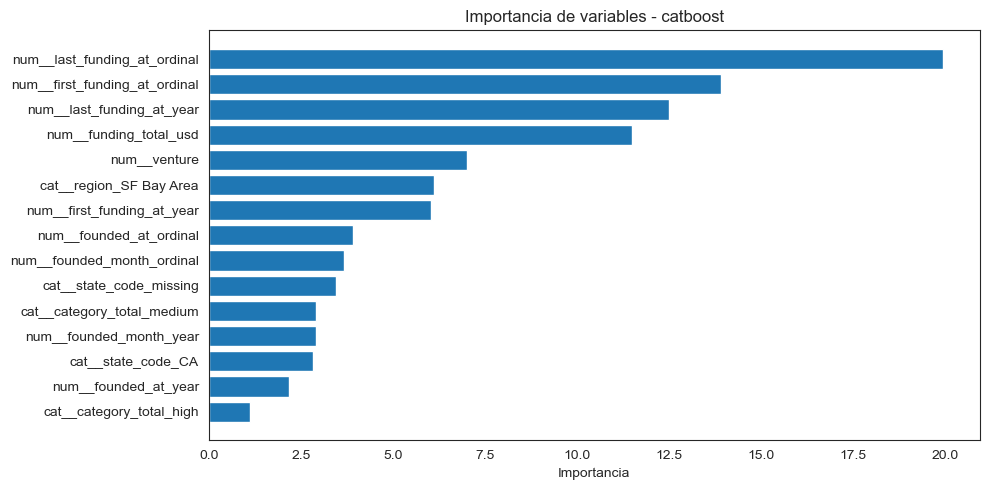

SHAP no está instalado. Para interpretabilidad avanzada, instala shap: pip install shap


In [85]:
# INTERPRETABILIDAD DEL MEJOR MODELO (incluyendo visualización del árbol para CatBoost)
#importar catboost model

# 1. Selecciona el mejor modelo según el F-beta score
best_row = results.iloc[0]
best_model_name = best_row['model']
best_sampler_name = best_row['sampler']
print(f"Mejor modelo: {best_model_name} | Muestreo: {best_sampler_name}")

# 2. Reconstruye el pipeline con los mismos parámetros
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_pipeline = Pipeline([
    ('imputer', best_imputer),
    ('scaler', best_scaler)
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', best_encoder)
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
], remainder='drop')

steps = [('preprocessor', preprocessor)]
if best_sampler_name != 'Ninguno':
    steps.append(('sampler', samplers[best_sampler_name]))
steps.append(('filter', SelectKBest(f_classif, k=15)))
steps.append(('clf', models[best_model_name]))
best_pipeline = ImbPipeline(steps)
best_pipeline.fit(X_train, y_train)

# 3. Obtener nombres de variables seleccionadas (tras SelectKBest)
feature_names = []
try:
    feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
except AttributeError:
    # Para versiones antiguas de sklearn
    from itertools import chain
    num_feats = [f'num__{col}' for col in num_cols]
    if hasattr(best_encoder, 'get_feature_names_out'):
        cat_feats = best_encoder.get_feature_names_out(cat_cols)
    else:
        cat_feats = [f'cat__{col}' for col in cat_cols]
    feature_names = list(chain(num_feats, cat_feats))

mask = best_pipeline.named_steps['filter'].get_support()
selected_features = np.array(feature_names)[mask]
print("Variables seleccionadas por SelectKBest:")
for f in selected_features:
    print(f" - {f}")

# 4. Interpretabilidad modelo (importancia de variables)
clf = best_pipeline.named_steps['clf']

if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    importances = importances[:len(selected_features)]
    sorted_idx = np.argsort(importances)[::-1]
    print("\nImportancia de variables (Random Forest/XGBoost/CatBoost):")
    for i in sorted_idx:
        print(f"{selected_features[i]}: {importances[i]:.4f}")

    plt.figure(figsize=(10, 5))
    plt.barh(selected_features[sorted_idx], importances[sorted_idx])
    plt.xlabel("Importancia")
    plt.title(f"Importancia de variables - {best_model_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
elif hasattr(clf, "coef_"):
    coefs = clf.coef_.ravel()
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    print("\nCoeficientes del modelo (Logistic Regression):")
    for i in sorted_idx:
        print(f"{selected_features[i]}: {coefs[i]:.4f}")

    plt.figure(figsize=(10, 5))
    plt.barh(selected_features[sorted_idx], coefs[sorted_idx])
    plt.xlabel("Coeficiente")
    plt.title(f"Coeficientes - {best_model_name}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Este modelo no permite extraer interpretabilidad directa (importancia o coeficientes).")

# 5. Opcional: SHAP para interpretabilidad avanzada
try:
    import shap
    import numpy as np # Asegúrate de que numpy esté importado
    import pandas as pd # Importar pandas para isinstance check
    from scipy.sparse import issparse # Para verificar si es una matriz dispersa

    print("\n--- Iniciando cálculo de SHAP ---")

    # Preprocesar y filtrar X_val una sola vez
    print("Transformando X_val para SHAP...")
    X_val_processed = best_pipeline.named_steps['preprocessor'].transform(X_val)
    X_val_transformed_for_shap = best_pipeline.named_steps['filter'].transform(X_val_processed)

    print(f"Shape original de X_val_transformed_for_shap: {X_val_transformed_for_shap.shape}")
    print(f"Tipo original de X_val_transformed_for_shap: {type(X_val_transformed_for_shap)}")

    # ***** NUEVO PASO: Convertir a array denso si es disperso *****
    if issparse(X_val_transformed_for_shap):
        print("Convirtiendo X_val_transformed_for_shap de matriz dispersa a densa...")
        X_val_transformed_for_shap = X_val_transformed_for_shap.toarray()
        print(f"  Nuevo shape (denso): {X_val_transformed_for_shap.shape}")
        print(f"  Nuevo tipo (denso): {type(X_val_transformed_for_shap)}")
        print(f"  Nuevo dtype (denso): {X_val_transformed_for_shap.dtype}")
    
    # Asegurarse de que los feature_names coincidan con las columnas de X_val_transformed_for_shap
    # selected_features ya debería tener la longitud correcta después de SelectKBest
    if X_val_transformed_for_shap.shape[1] != len(selected_features):
        print(f"¡ALERTA DE INCOINCIDENCIA DE CARACTERÍSTICAS! ")
        print(f"X_val_transformed_for_shap tiene {X_val_transformed_for_shap.shape[1]} columnas.")
        print(f"selected_features tiene {len(selected_features)} nombres.")
        print("Esto puede causar problemas o errores en el summary_plot de SHAP.")
        # Podrías truncar o ajustar selected_features si es necesario, o investigar por qué no coinciden.
        # Por ahora, procederemos, pero la gráfica SHAP podría tener nombres incorrectos.

    print(f"\nTipo de modelo (clf) para SHAP: {type(clf)}")
    
    # Crear el explainer.
    # El segundo argumento (a veces llamado 'masker' o 'background data') es X_val_transformed_for_shap
    print("Creando SHAP Explainer...")
    explainer = shap.Explainer(clf, X_val_transformed_for_shap)

    print("Calculando SHAP values...")
    shap_values = explainer(X_val_transformed_for_shap)

    print("\nGenerando gráfica SHAP summary plot...")
    shap.summary_plot(shap_values, features=X_val_transformed_for_shap, feature_names=selected_features)
    # import matplotlib.pyplot as plt # Asegúrate de importar plt si no lo has hecho globalmente
    # plt.show() # Descomentar si la gráfica no aparece automáticamente

except ImportError:
    print("SHAP no está instalado. Para interpretabilidad avanzada, instala shap: pip install shap")
except Exception as e:
    print(f"Error al calcular SHAP: {e}")
    import traceback
    print("\n--- Traceback Detallado ---")
    traceback.print_exc()
    print("--- Fin del Traceback ---")



In [86]:

print(f"Intentando obtener información del modelo XGBoost: {best_model_name}")

# Verificar si el clasificador es un modelo XGBoost
is_xgboost = False
if hasattr(clf, 'get_booster'):
    is_xgboost = True
elif 'xgb' in best_model_name.lower():
    is_xgboost = True

if is_xgboost:
    booster = clf.get_booster() # Obtenemos el booster subyacente

    # --- 1. Representación Textual de los Árboles ---
    print("\n--- 1. Representación Textual de los Primeros Árboles ---")
    try:
        tree_dumps_text = booster.get_dump(dump_format='text')
        for i, tree_dump in enumerate(tree_dumps_text):
            if i < 2: # Mostrar solo los primeros 2 árboles para brevedad
                print(f"\n--- Árbol XGBoost {i} (formato texto) ---")
                print(tree_dump)
            else:
                break
    except Exception as e:
        print(f"Error al obtener la representación textual de los árboles: {e}")
    # --- 3. Exportar el Modelo Completo (estructura de árboles) a JSON ---
    print("\n--- 3. Exportar Estructura del Modelo a JSON ---")
    json_dump_filename = 'xgb_model_estructura.json'
    try:
        booster.dump_model(json_dump_filename, dump_format='json', with_stats=True)
        print(f"La estructura del modelo XGBoost ha sido guardada en: '{json_dump_filename}'")
        print("Este archivo JSON contiene la información detallada de todos los árboles y sus divisiones.")
        # Ejemplo de cómo cargar y ver una parte (opcional):
        # with open(json_dump_filename, 'r') as f:
        #     model_json_content = json.load(f)
        # print("\nPrimeros elementos del JSON cargado (para verificar):")
        # if isinstance(model_json_content, list) and len(model_json_content) > 0:
        #     print(model_json_content[0]) # Muestra la estructura del primer árbol del JSON
        # else:
        #     print(model_json_content) # Muestra el contenido si no es una lista de árboles
    except Exception as e:
        print(f"Error al guardar el modelo XGBoost en formato JSON: {e}")


else:
    print(f"El modelo actual ('{best_model_name}', tipo: {type(clf).__name__}) no parece ser XGBoost.")
    print("Estas alternativas son específicas para modelos XGBoost.")



Intentando obtener información del modelo XGBoost: catboost
El modelo actual ('catboost', tipo: CatBoostClassifier) no parece ser XGBoost.
Estas alternativas son específicas para modelos XGBoost.


In [87]:
import json
import numpy as np

# Asegúrate de que este es el nombre del archivo JSON generado por XGBoost
nombre_archivo_json = "xgb_model_estructura.json"

print(f"--- INTERPRETANDO ESTADÍSTICAS DEL MODELO XGBOOST DESDE '{nombre_archivo_json}' ---")

try:
    with open(nombre_archivo_json, 'r') as f:
        # El JSON de XGBoost (con with_stats=True) es una lista de diccionarios,
        # donde cada diccionario representa un árbol (y es el nodo raíz de ese árbol).
        lista_arboles = json.load(f)

    if not isinstance(lista_arboles, list):
        print(f"Error: El contenido del JSON no es una lista como se esperaba para XGBoost. Se encontró tipo: {type(lista_arboles)}")
        # Si dump_model se usó con with_stats=False, podría ser una lista de strings JSON,
        # cada uno necesitando un json.loads() individual. Asumimos with_stats=True por ahora.
        lista_arboles = []

    if not lista_arboles:
        print("No se encontraron árboles en el archivo JSON para analizar o el formato no es el esperado.")
    else:
        print(f"Número total de árboles encontrados en el JSON: {len(lista_arboles)}")

        profundidades_arboles = []
        num_hojas_por_arbol = []
        num_nodos_por_arbol = []

        for i, arbol_raiz_dict in enumerate(lista_arboles):
            if not isinstance(arbol_raiz_dict, dict):
                print(f"Advertencia: El elemento {i} en la lista de árboles no es un diccionario. Se omitirá.")
                continue

            nodos_del_arbol_actual = []
            
            # Función recursiva para recolectar todos los nodos de un árbol
            def recolectar_nodos(nodo_actual_dict, lista_recolectora):
                if not isinstance(nodo_actual_dict, dict): # Comprobación de seguridad
                    return
                lista_recolectora.append(nodo_actual_dict)
                if "children" in nodo_actual_dict and isinstance(nodo_actual_dict["children"], list):
                    for hijo_dict in nodo_actual_dict["children"]:
                        recolectar_nodos(hijo_dict, lista_recolectora)
            
            recolectar_nodos(arbol_raiz_dict, nodos_del_arbol_actual)

            if not nodos_del_arbol_actual:
                print(f"Advertencia: No se recolectaron nodos para el árbol {i}. Se omitirá.")
                continue

            # Calcular estadísticas para el árbol actual
            max_profundidad_en_arbol = 0
            hojas_en_arbol = 0
            
            for nodo in nodos_del_arbol_actual:
                if "depth" in nodo: # La profundidad de un nodo está usualmente presente
                    max_profundidad_en_arbol = max(max_profundidad_en_arbol, nodo["depth"])
                if "leaf" in nodo: # Si el nodo tiene la clave 'leaf', es una hoja
                    hojas_en_arbol += 1
            
            num_nodos_actual = len(nodos_del_arbol_actual)

            profundidades_arboles.append(max_profundidad_en_arbol)
            num_hojas_por_arbol.append(hojas_en_arbol)
            num_nodos_por_arbol.append(num_nodos_actual)

        if profundidades_arboles: # Si hemos podido calcular estadísticas
            print("\n--- Estadísticas de los Árboles (XGBoost) ---")
            print(f"Profundidad de los árboles (0-indexada, valor máximo de 'depth' en nodos):")
            print(f"  Mínima: {np.min(profundidades_arboles)}")
            print(f"  Máxima: {np.max(profundidades_arboles)}")
            print(f"  Promedio: {np.mean(profundidades_arboles):.2f}")
            print(f"  Desviación Estándar: {np.std(profundidades_arboles):.2f}")

            print(f"\nNúmero de hojas por árbol:")
            print(f"  Mínimo: {np.min(num_hojas_por_arbol)}")
            print(f"  Máximo: {np.max(num_hojas_por_arbol)}")
            print(f"  Promedio: {np.mean(num_hojas_por_arbol):.2f}")

            print(f"\nNúmero total de nodos por árbol (internos + hojas):")
            print(f"  Mínimo: {np.min(num_nodos_por_arbol)}")
            print(f"  Máximo: {np.max(num_nodos_por_arbol)}")
            print(f"  Promedio: {np.mean(num_nodos_por_arbol):.2f}")
            
            # Opcional: Histograma de profundidades (necesitarías matplotlib)
            # import matplotlib.pyplot as plt
            # if profundidades_arboles:
            #     plt.figure(figsize=(10, 6))
            #     # Determinar los bins para que cada barra represente una profundidad entera
            #     min_d, max_d = int(np.min(profundidades_arboles)), int(np.max(profundidades_arboles))
            #     bins = range(min_d, max_d + 2) 
            #     plt.hist(profundidades_arboles, bins=bins, align='left', rwidth=0.8)
            #     plt.title('Distribución de las Profundidades de los Árboles (XGBoost)')
            #     plt.xlabel('Profundidad del Árbol (valor máx. de "depth")')
            #     plt.ylabel('Número de Árboles')
            #     plt.xticks(range(min_d, max_d + 1))
            #     plt.grid(axis='y', alpha=0.75)
            #     plt.show()

        else:
            print("No se pudieron calcular estadísticas detalladas de los árboles (no se procesaron árboles válidos).")


except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{nombre_archivo_json}'. Asegúrate de que el nombre y la ruta sean correctos.")
except json.JSONDecodeError:
    print(f"Error: El archivo '{nombre_archivo_json}' no contiene un JSON válido o está corrupto.")
except Exception as e:
    import traceback
    print(f"Ocurrió un error inesperado al procesar el archivo JSON de XGBoost: {e}")
    traceback.print_exc()


--- INTERPRETANDO ESTADÍSTICAS DEL MODELO XGBOOST DESDE 'xgb_model_estructura.json' ---
Número total de árboles encontrados en el JSON: 60

--- Estadísticas de los Árboles (XGBoost) ---
Profundidad de los árboles (0-indexada, valor máximo de 'depth' en nodos):
  Mínima: 4
  Máxima: 4
  Promedio: 4.00
  Desviación Estándar: 0.00

Número de hojas por árbol:
  Mínimo: 28
  Máximo: 32
  Promedio: 30.50

Número total de nodos por árbol (internos + hojas):
  Mínimo: 55
  Máximo: 63
  Promedio: 60.00


In [88]:
fin = time() - inicio
print(f"Tiempo de ejecución: {fin:.2f} segundos")

Tiempo de ejecución: 2659.08 segundos
